# **LG01 - EDA - Tabular (Based on SPI) PCB Defects Detection - RISTEK FASILKOM UI DATATHON 2025**

---



Dalam industri manufaktur elektronik, keandalan fungsional sebuah produk sangat bergantung pada integritas Printed Circuit Board (PCB) sebagai komponen inti. Salah satu tantangan terbesar dalam kontrol kualitas adalah proses diagnosis cacat, di mana tidak hanya keberadaan anomali yang perlu diidentifikasi, tetapi juga jenis spesifik dari cacat tersebut.

Proyek ini bertujuan untuk mengatasi tantangan diagnostik tersebut dengan mengembangkan sebuah sistem cerdas berbasis analisis data tabular. Dengan memanfaatkan dataset yang berisi data numerik dan kategorikal dari proses produksi dan hasil inspeksi PCB, termasuk parameter-parameter dari berbagai tahap produksi, tugas kami adalah membangun model machine learning yang mampu melakukan klasifikasi jenis cacat secara presisi tinggi. Model ini diharapkan dapat meniru keahlian seorang inspektur berpengalaman dalam menginterpretasikan data proses, namun dengan kecepatan, konsistensi, dan skalabilitas yang lebih tinggi.

Analisis ini bertujuan untuk melakukan eksplorasi data secara mendalam pada dataset proses manufaktur Printed Circuit Board (PCB). Fokus utama adalah pada data dari dua tahap inspeksi kritis: Solder Paste Inspection (SPI) dan Automated Optical Inspection (AOI). Melalui analisis ini, diharapkan dapat teridentifikasi pola, anomali, serta faktor-faktor kunci yang memengaruhi kualitas hasil produksi. Wawasan yang diperoleh akan menjadi dasar untuk membangun model prediktif dan memberikan rekomendasi strategis guna meningkatkan efisiensi dan menekan tingkat kecacatan dalam lini produksi.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, r2_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from itertools import combinations
from collections import Counter
import matplotlib.gridspec as gridspec

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
#!/bin/bash
!kaggle datasets download rizkyfadhilahjhhhh/dataset-lg01

Dataset URL: https://www.kaggle.com/datasets/rizkyfadhilahjhhhh/dataset-lg01
License(s): unknown
 96% 312M/323M [00:01<00:00, 216MB/s]
100% 323M/323M [00:01<00:00, 225MB/s]


In [ ]:
!unzip dataset-lg01.zip

Archive:  dataset-lg01.zip
  inflating: PCB Dataset/AOI_testing.csv  
  inflating: PCB Dataset/AOI_training.csv  
  inflating: PCB Dataset/SPI_testing_0.csv  
  inflating: PCB Dataset/SPI_testing_1.csv  
  inflating: PCB Dataset/SPI_training_0.csv  
  inflating: PCB Dataset/SPI_training_1.csv  
  inflating: PCB Dataset/SPI_training_2.csv  
  inflating: PCB Dataset/SPI_training_3.csv  


In [ ]:
pd.set_option("display.max_column", None)
pd.set_option("display.width", 1000)

Data historis dari tahap Solder Paste Inspection (SPI) tersedia dalam bentuk beberapa file CSV yang terfragmentasi. Untuk memungkinkan analisis yang holistik, langkah konsolidasi data perlu dilakukan. Proses ini melibatkan penggabungan seluruh file SPI_training menjadi sebuah dataframe tunggal. Dengan menyatukan data ini, kita dapat memperoleh gambaran yang utuh dan komprehensif mengenai seluruh kejadian yang tercatat selama inspeksi SPI.

In [ ]:
aoi_train = pd.read_csv('/content/PCB Dataset/AOI_training.csv')
spi_0 = pd.read_csv('/content/PCB Dataset/SPI_training_0.csv')
spi_1 = pd.read_csv('/content/PCB Dataset/SPI_training_1.csv')
spi_2 = pd.read_csv('/content/PCB Dataset/SPI_training_2.csv')
spi_3 = pd.read_csv('/content/PCB Dataset/SPI_training_3.csv')

/tmp/ipython-input-6-4124030820.py:4: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  spi_2 = pd.read_csv('/content/PCB Dataset/SPI_training_2.csv')


## **Menganalisa File Merged SPI**

---



In [ ]:
merged_spi = pd.concat([spi_0, spi_1, spi_2, spi_3])
merged_spi.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5985382 entries, 0 to 1496346
Data columns (total 21 columns):
 #   Column       Dtype  
---  ------       -----  
 0   PanelID      object 
 1   FigureID     float64
 2   Date         object 
 3   Time         object 
 4   ComponentID  object 
 5   PinNumber    object 
 6   PadID        float64
 7   PadType      float64
 8   Volume(%)    float64
 9   Height(um)   float64
 10  Area(%)      float64
 11  OffsetX(%)   float64
 12  OffsetY(%)   float64
 13  SizeX        float64
 14  SizeY        float64
 15  Volume(um3)  float64
 16  Area(um2)    float64
 17  Shape(um)    object 
 18  PosX(mm)     float64
 19  PosY(mm)     float64
 20  Result       object 
dtypes: float64(14), object(7)
memory usage: 1004.6+ MB


> Penanganan Nilai Hilang dan Inkonsistensi Data

**Pada tahap ini, dilakukan pemeriksaan dan pembersihan pada kolom Shape(um). Kolom ini, yang seharusnya merepresentasikan fitur numerik, teridentifikasi memiliki nilai yang tidak valid (non-numerik) dan nilai yang hilang (NaN).**

**Untuk mengatasi hal ini, tipe data kolom Shape(um) dikonversi menjadi numerik, di mana entri yang bermasalah akan diubah menjadi NaN (Not a Number). Selanjutnya, seluruh baris yang mengandung nilai NaN pada kolom ini akan dihapus dari dataset.**

**Selain itu, fitur baru bernama Datetime dikonstruksi dengan menggabungkan kedua kolom tersebut dan mengonversinya ke dalam format datetime yang standar.**

In [ ]:
merged_spi['Shape(um)'] = pd.to_numeric(merged_spi['Shape(um)'], errors='coerce')
missing_values = merged_spi['Shape(um)'].isnull().sum()
print(missing_values)

merged_spi.dropna(subset=['Shape(um)'], inplace=True)
missing_values = merged_spi['Shape(um)'].isnull().sum()
print(missing_values)

merged_spi["Datetime"] = merged_spi["Date"] + ' ' + merged_spi["Time"]
merged_spi["Datetime"] = pd.to_datetime(merged_spi["Datetime"])
merged_spi = merged_spi.drop(columns=["Date", "Time"])
merged_spi['Hour'] = merged_spi['Datetime'].dt.hour
merged_spi['DayOfWeek'] = merged_spi['Datetime'].dt.day_name()


1
0


In [ ]:
merged_spi.describe()

FigureID         PadID       PadType     Volume(%)    Height(um)       Area(%)    OffsetX(%)    OffsetY(%)         SizeX         SizeY   Volume(um3)     Area(um2)     Shape(um)      PosX(mm)      PosY(mm)                       Datetime          Hour
count  5.985381e+06  5.985381e+06  5.985381e+06  5.985381e+06  5.985381e+06  5.985381e+06  5.985381e+06  5.985381e+06  5.985381e+06  5.985381e+06  5.985381e+06  5.985381e+06  5.985381e+06  5.985381e+06  5.985381e+06                        5985381  5.985381e+06
mean   4.499461e+00  1.579488e+03  4.550248e+00  9.255412e+01  1.123681e+02  9.919887e+01  9.643866e-01  2.834259e-01  8.716995e-01  7.721099e-01  1.130025e+08  1.074501e+06  4.592468e+01  1.217285e+02  7.223208e+01  2019-08-18 22:29:56.247686656  1.258368e+01
min    1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  3.500000e+01  0.000000e+00 -3.881200e+01 -1.031800e+02  1.870000e-01  2.200000e-01  0.000000e+00  0.000000e+00 -1.006000e+02  9.100000e+00  1.180000e+01            2019-07-25 16:53:07  0.000000e+00
25%    2.000000e+00  7.900000e+02  0.000000e+00  8.550800e+01  1.061450e+02  9.392500e+01 -4.260000e-01 -2.741000e+00  5.000000e-01  5.000000e-01  2.458427e+07  2.201700e+05  3.610000e+01  6.140000e+01  4.220000e+01            2019-07-26 17:31:02  6.000000e+00
50%    4.000000e+00  1.580000e+03  0.000000e+00  9.218300e+01  1.124810e+02  9.936600e+01  6.440000e-01  1.150000e-01  5.000000e-01  5.000000e-01  2.768921e+07  2.385830e+05  4.460000e+01  1.196000e+02  6.070000e+01            2019-07-29 07:56:53  1.500000e+01
75%    6.000000e+00  2.370000e+03  1.000000e+01  9.914200e+01  1.185710e+02  1.039100e+02  2.130000e+00  3.150000e+00  1.070000e+00  8.890000e-01  6.674604e+07  6.471490e+05  5.450000e+01  1.778000e+02  1.073000e+02            2019-09-20 20:24:03  1.800000e+01
max    8.000000e+00  3.160000e+03  1.000000e+01  3.880840e+02  3.338740e+02  1.801730e+02  4.097600e+01  9.119700e+01  5.100000e+00  5.100000e+00  7.892045e+09  2.745635e+07  3.580000e+02  2.361000e+02  1.258000e+02            2019-09-25 16:51:04  2.300000e+01
std    2.291336e+00  9.123164e+02  4.979732e+00  1.139325e+01  9.597775e+00  7.689098e+00  2.750223e+00  5.828129e+00  8.159855e-01  7.505808e-01  3.719017e+08  3.680356e+06  1.555493e+01  6.602616e+01  3.516836e+01                            NaN  7.083744e+00

In [ ]:
print("SPI Data")
print(f"Data Shape: {merged_spi.shape}")
print(f"Date Range: {merged_spi['Datetime'].min()} to {merged_spi['Datetime'].max()}")
print(f"Total Duration {(merged_spi['Datetime'].max() - merged_spi['Datetime'].min()).days} days")
print("\nMissing Value:")
missing = merged_spi.isnull().sum()
missing = missing[missing > 0]
if len(missing) > 0:
    print(missing)
else:
    print("No Missing Value")

print("\nAOI Training Data")
print(f"Data Shape: {aoi_train.shape}")
print("\nMissing Value:")
missing_aoi = aoi_train.isnull().sum()
missing_aoi = missing_aoi[missing_aoi > 0]
if len(missing_aoi) > 0:
    print(missing_aoi)
else:
    print("No Missing Value")

SPI Data
Data Shape: (5985381, 22)
Date Range: 2019-07-25 16:53:07 to 2019-09-25 16:51:04
Total Duration 61 days

Missing Value:
No Missing Value

AOI Training Data
Data Shape: (31617, 8)

Missing Value:
PinNumber       9124
RepairLabel    30261
dtype: int64


Dataset SPI yang telah dikonsolidasi memiliki skala yang sangat besar, mencakup lebih dari 5,9 juta catatan inspeksi yang terkumpul dalam rentang waktu produksi selama 61 hari. Volume data yang substansial ini mengindikasikan intensitas produksi yang tinggi dan menyediakan fondasi data yang kaya untuk analisis statistik yang mendalam.

Dari seluruh kolom tersebut, investigasi awal akan difokuskan pada kolom Result, yang merupakan variabel target utama, untuk memahami distribusi hasil kualitas produksi secara keseluruhan.

SPI Analysis (Result)
              Jumlah  Persentase
Result                          
GOOD         5910387       98.75
W.Insuffi.     73336        1.23
E.Shape          639        0.01
E.Position       591        0.01
E.Insuffi.       174        0.00
W.Excessive       83        0.00
W.Position        66        0.00
E.Exessive        47        0.00
E.Bridging        42        0.00
W.HeightU          8        0.00
E.HeightU          6        0.00
E.AreaL            2        0.00


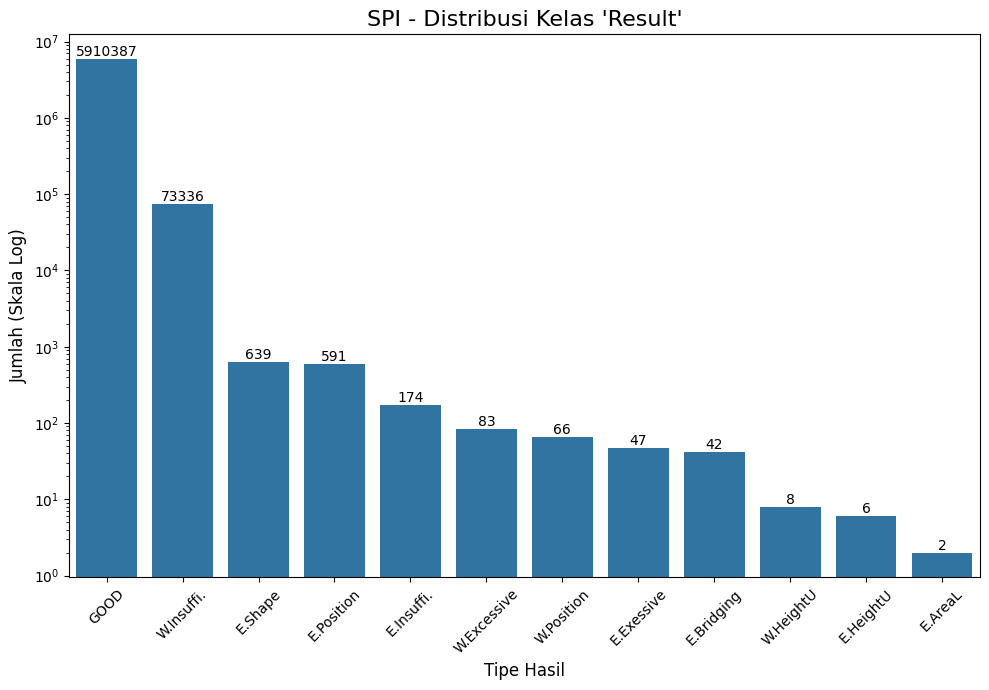

In [ ]:
print("SPI Analysis (Result)")
result_counts = merged_spi['Result'].value_counts()
result_props = merged_spi['Result'].value_counts(normalize=True) * 100
print(pd.DataFrame({'Jumlah': result_counts, 'Persentase': result_props.round(2)}))

plt.figure(figsize=(10, 7))

ax = sns.barplot(x=result_counts.index, y=result_counts.values)
ax.set_yscale("log")

plt.title("SPI - Distribusi Kelas 'Result'", fontsize=16)
plt.xlabel("Tipe Hasil", fontsize=12)
plt.ylabel("Jumlah (Skala Log)", fontsize=12)
plt.xticks(rotation=45)

for i, v in enumerate(result_counts.values):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

Analisis terhadap distribusi variabel target Result mengungkap sebuah fakta bahwa terdapat ketidakseimbangan kelas yang ekstrem. Data menunjukkan bahwa lebih dari 98.7% dari total inspeksi diklasifikasikan sebagai '**GOOD**', yang mengindikasikan bahwa kasus cacat adalah sebuah peristiwa langka dalam proses produksi.

Temuan ini menjadi landasan strategis untuk tahap pemodelan, di mana metrik evaluasi standar seperti akurasi tidak akan efektif. Selain itu, teridentifikasi bahwa 'W.Insuffi.' (Warning Insufficient) merupakan kategori cacat yang paling dominan, menjadikannya prioritas utama untuk analisis akar masalah.

Investigasi mendalam pada W.Insuff

Berdasarkan temuan sebelumnya bahwa 'W.Insuffi.' merupakan kategori cacat yang paling sering terjadi, analisis ini difokuskan untuk mengidentifikasi faktor-faktor pemicunya. Investigasi dilakukan dengan membandingkan distribusi data antara hasil inspeksi 'GOOD' dengan 'W.Insuffi.' dari berbagai perspektif: parameter numerik, waktu, dan komponen.

In [ ]:
df_compare = merged_spi[merged_spi['Result'].isin(['GOOD', 'W.Insuffi.'])].copy()

good_sample = df_compare[df_compare['Result'] == 'GOOD'].sample(n=len(df_compare[df_compare['Result'] == 'W.Insuffi.']), random_state=42)
df_compare_balanced = pd.concat([good_sample, df_compare[df_compare['Result'] == 'W.Insuffi.']])

print(f"Jumlah data 'W.Insuffi.': {len(df_compare[df_compare['Result'] == 'W.Insuffi.'])}")
print(f"Jumlah sampel 'GOOD': {len(good_sample)}")

Jumlah data 'W.Insuffi.': 73336
Jumlah sampel 'GOOD': 73336


Dengan dataset yang kini seimbang secara proporsional, kita dapat melangkah ke tahap investigasi untuk menguji hipotesis pertama: apakah terdapat perbedaan karakteristik yang signifikan pada parameter-parameter pengukuran fisik antara hasil 'GOOD' dan 'W.Insuffi.'?

Perbandingan Statistik Deskriptif:
Result                    GOOD    W.Insuffi.
Volume(%)  count  5.910387e+06  73336.000000
           mean   9.290759e+01     63.858453
           std    1.096367e+01      5.904756
           min    5.283300e+01     40.051000
           25%    8.579500e+01     59.193000
           50%    9.233500e+01     66.350500
           75%    9.924400e+01     68.613250
           max    1.872310e+02     70.000000
Height(um) count  5.910387e+06  73336.000000
           mean   1.126394e+02     90.172131
           std    9.268288e+00      7.096663
           min    7.280200e+01     65.223000
           25%    1.064170e+02     85.636000
           50%    1.126220e+02     89.582000
           75%    1.186550e+02     94.831000
           max    2.276920e+02    131.349000
Area(%)    count  5.910387e+06  73336.000000
           mean   9.930719e+01     90.533436
           std    7.627907e+00      7.179604
           min    5.324900e+01     50.613000
           25%    9.

/tmp/ipython-input-13-684237677.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_compare_balanced, x='Result', y=col, palette=['#34A853', '#EA4335'])
/tmp/ipython-input-13-684237677.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_compare_balanced, x='Result', y=col, palette=['#34A853', '#EA4335'])
/tmp/ipython-input-13-684237677.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_compare_balanced, x='Result', y=col, palette=['#34A853', '#EA4335'])
/tmp/ipython-input-13-684237677.py:10: FutureWarning: 

Passi

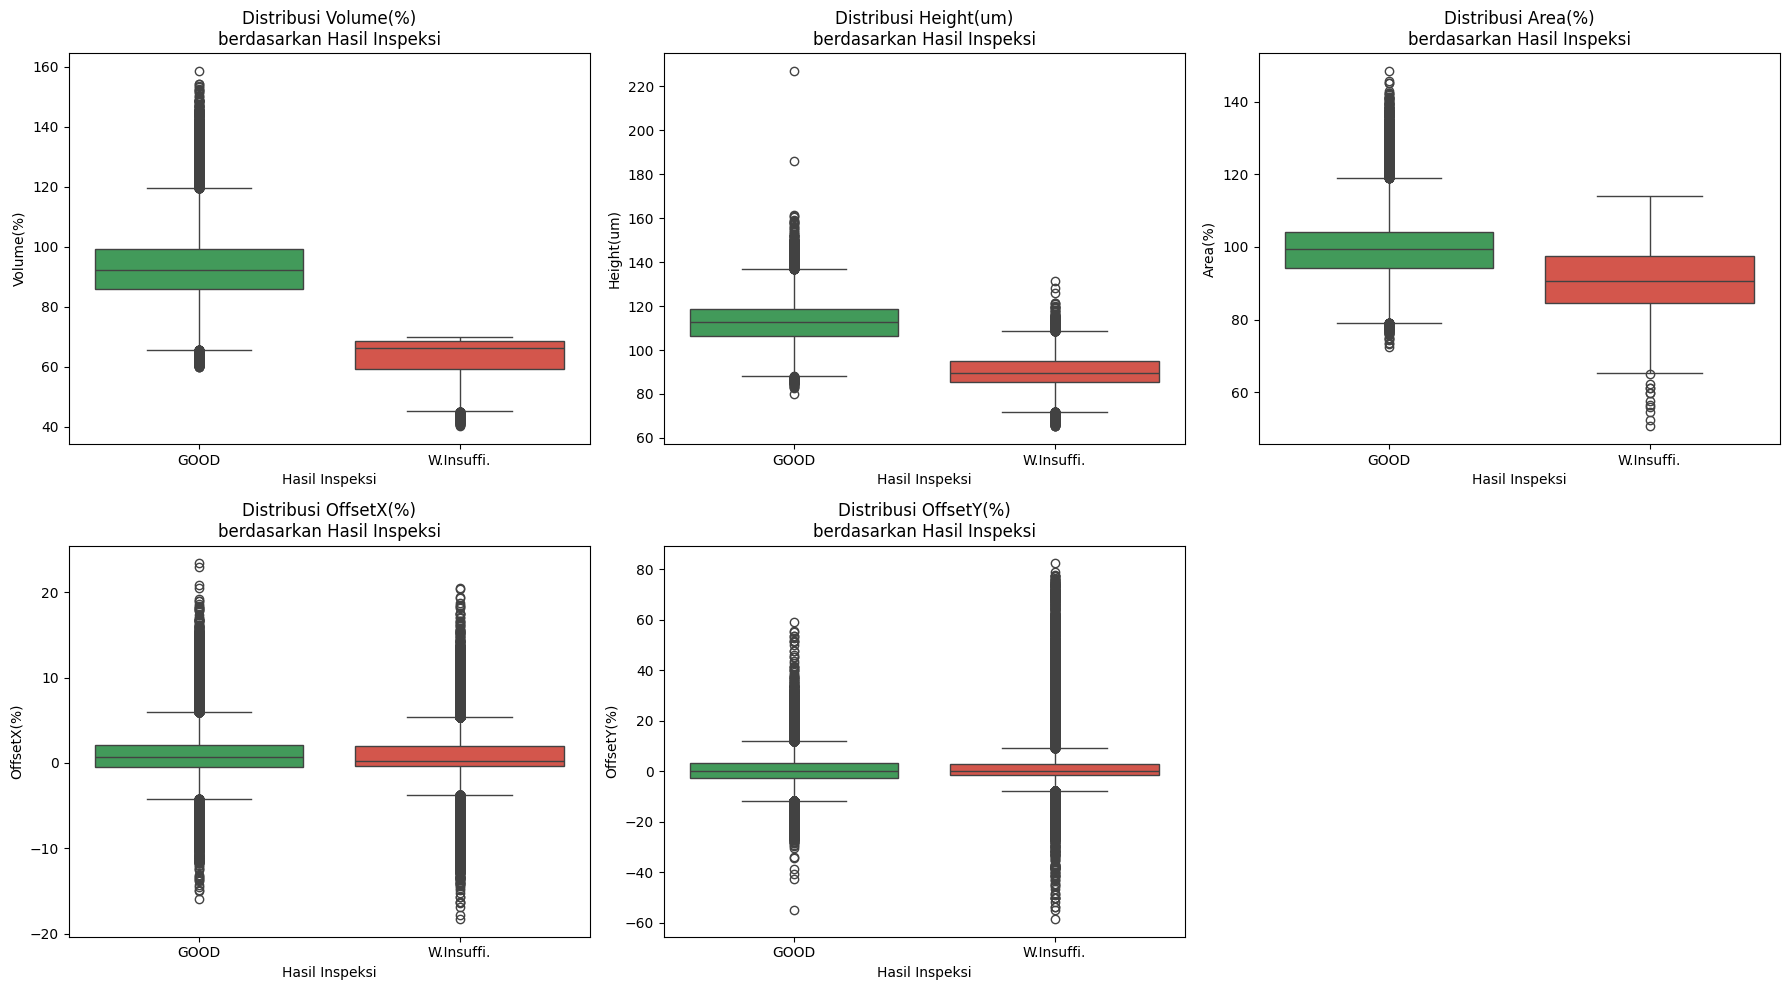

In [ ]:
#Kolom numerik utama yang akan kami analisis
numeric_cols = ['Volume(%)', 'Height(um)', 'Area(%)', 'OffsetX(%)', 'OffsetY(%)']

print("Perbandingan Statistik Deskriptif:")
print(df_compare.groupby('Result')[numeric_cols].describe().T)

plt.figure(figsize=(18, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=df_compare_balanced, x='Result', y=col, palette=['#34A853', '#EA4335'])
    plt.title(f'Distribusi {col}\nberdasarkan Hasil Inspeksi', fontsize=12)
    plt.xlabel('Hasil Inspeksi')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

Terdapat perbedaan yang sangat jelas dan signifikan pada tiga parameter utama:

*   Volume (Volume(%)): Rata-rata volume pada cacat 'W.Insuffi.' (~64%) berada jauh di bawah rata-rata hasil 'GOOD' (~93%).

*   Ketinggian (Height(um)): Pola serupa terlihat pada ketinggian pasta solder, di mana hasil cacat memiliki ketinggian yang jauh lebih rendah.

*   Luas (Area(%)): Luas area pasta solder pada hasil cacat juga secara konsisten lebih kecil.

Visualisasi box plot memperkuat temuan ini, di mana hampir tidak ada tumpang tindih (overlap) antara distribusi ketiga parameter tersebut untuk kategori 'GOOD' dan 'W.Insuffi.'. Sebaliknya, parameter OffsetX(%) dan OffsetY(%) menunjukkan distribusi yang sangat mirip antara kedua kategori.

Cacat 'W.Insuffi.' secara valid disebabkan oleh kurangnya kuantitas pasta solder yang diaplikasikan, bukan karena pergeseran posisi (offset). Temuan ini mempersempit fokus investigasi ke masalah pada proses deposisi pasta solder itu sendiri.

Setelah mengonfirmasi "apa" masalahnya (kuantitas solder), investigasi selanjutnya akan berfokus pada "kapan" dan "di mana" masalah ini paling sering terjadi.






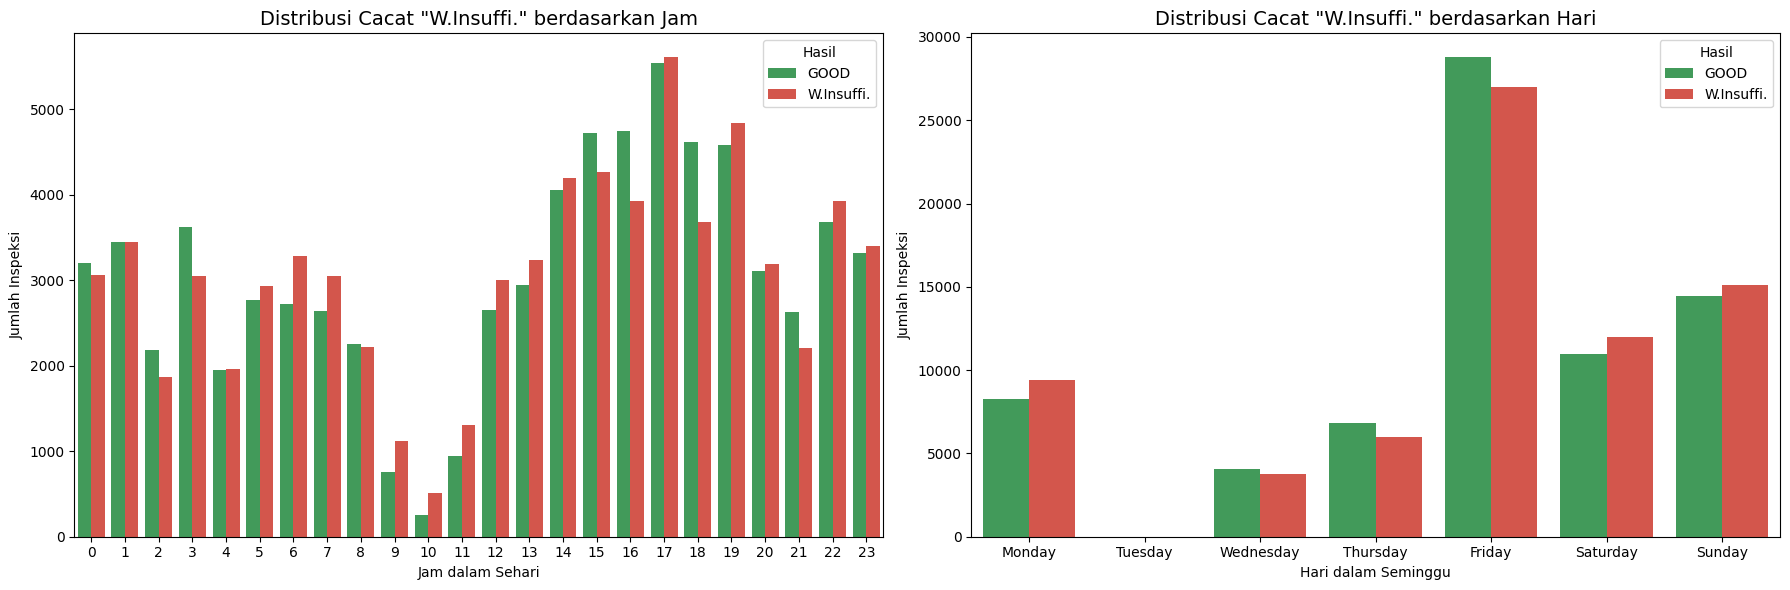

In [ ]:
df_compare = merged_spi[merged_spi['Result'].isin(['GOOD', 'W.Insuffi.'])].copy()

good_sample = df_compare[df_compare['Result'] == 'GOOD'].sample(n=len(df_compare[df_compare['Result'] == 'W.Insuffi.']), random_state=42)
df_compare_balanced = pd.concat([good_sample, df_compare[df_compare['Result'] == 'W.Insuffi.']])


fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.countplot(data=df_compare_balanced, x='Hour', hue='Result', ax=axes[0], palette=['#34A853', '#EA4335'])
axes[0].set_title('Distribusi Cacat "W.Insuffi." berdasarkan Jam', fontsize=14)
axes[0].set_xlabel('Jam dalam Sehari')
axes[0].set_ylabel('Jumlah Inspeksi')
axes[0].legend(title='Hasil')
sns.countplot(data=df_compare_balanced, x='DayOfWeek', hue='Result', ax=axes[1], palette=['#34A853', '#EA4335'], order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
axes[1].set_title('Distribusi Cacat "W.Insuffi." berdasarkan Hari', fontsize=14)
axes[1].set_xlabel('Hari dalam Seminggu')
axes[1].set_ylabel('Jumlah Inspeksi')
axes[1].legend(title='Hasil')

plt.tight_layout()
plt.show()

Hasil visualisasi menunjukkan bahwa distribusi cacat 'W.Insuffi.' tidak terjadi secara acak, melainkan terkonsentrasi pada periode-periode waktu tertentu.

Analisis per jam:
Terlihat adanya proporsi cacat 'W.Insuffi.' yang lebih tinggi secara signifikan pada jam-jam kerja sore-malam. Hal ini dapat mengindikasikan adanya faktor-faktor seperti kelelahan operator, kurangnya supervisi, atau perubahan kondisi mesin setelah beroperasi seharian penuh.

Analisis per hari:
Data secara konsisten menunjukkan bahwa Hari Jumat merupakan hari dengan insiden cacat 'W.Insuffi.' tertinggi. Fenomena ini bisa jadi berkaitan dengan upaya pemenuhan target produksi mingguan atau akumulasi kelelahan sepanjang minggu kerja. Hari Minggu juga menunjukkan tingkat cacat yang relatif tinggi.

Terdapat bukti kuat bahwa shift malam dan akhir pekan kerja (terutama hari Jumat) merupakan periode kritis yang paling rentan terhadap cacat kekurangan pasta solder. Temuan ini memberikan dasar untuk rekomendasi tindakan yang terfokus, seperti peningkatan frekuensi patroli kualitas atau kalibrasi mesin pada periode-periode rawan tersebut.

Terakhir, mari lihat apakah ada Part atau Component tertentu yang lebih rentan mengalami cacat 'W.Insuffi.'.

/tmp/ipython-input-15-3614616298.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_defective_components.values, y=top_10_defective_components.index, palette='Reds_r')


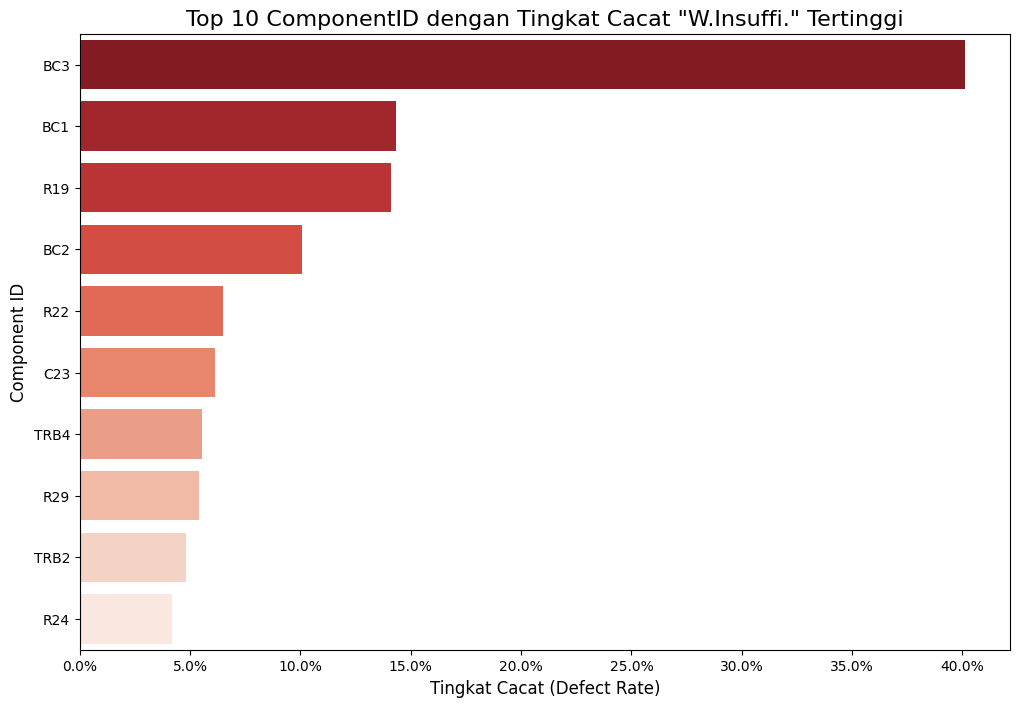


Top 10 ComponentID Paling Bermasalah (dengan >1000 inspeksi):
ComponentID
BC3     0.401413
BC1     0.143108
R19     0.141209
BC2     0.100910
R22     0.064840
C23     0.061261
TRB4    0.055520
R29     0.054046
TRB2    0.048036
R24     0.041738
Name: Result, dtype: float64


In [ ]:

defect_rate_per_component = df_compare.groupby('ComponentID')['Result'].apply(lambda x: (x == 'W.Insuffi.').sum() / len(x)).sort_values(ascending=False)

component_counts = df_compare['ComponentID'].value_counts()
reliable_components = component_counts[component_counts >= 1000].index
defect_rate_reliable = defect_rate_per_component[defect_rate_per_component.index.isin(reliable_components)]


top_10_defective_components = defect_rate_reliable.head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_10_defective_components.values, y=top_10_defective_components.index, palette='Reds_r')
plt.title('Top 10 ComponentID dengan Tingkat Cacat "W.Insuffi." Tertinggi', fontsize=16)
plt.xlabel('Tingkat Cacat (Defect Rate)', fontsize=12)
plt.ylabel('Component ID', fontsize=12)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter('{:.1%}'.format))
plt.show()
print("\nTop 10 ComponentID Paling Bermasalah (dengan >1000 inspeksi):")
print(top_10_defective_components)

Investigasi mendalam terhadap cacat 'W.Insuffi.' telah berhasil mengidentifikasi akar masalahnya secara spesifik. Ditemukan bahwa cacat ini disebabkan oleh kurangnya volume pasta solder, dengan insiden tertinggi terjadi pada shift malam dan hari Jumat. Lebih krusial lagi, analisis menunjukkan bahwa komponen dengan ComponentID BC3 merupakan sumber utama dari masalah ini dengan tingkat cacat mencapai 40%.

Setelah investigasi spesifik terhadap 'W.Insuffi.' selesai, analisis kini diperluas kembali untuk membedah pola temporal dari seluruh jenis cacat secara umum. Tujuannya adalah untuk memahami ritme produksi secara keseluruhan dan untuk memastikan tidak ada tren atau pola penting lainnya yang terlewatkan.

Mari kita lihat kapan saja kecacatan lebih sering terjadi. Apakah pada jam tertentu? Hari tertentu? Apakah tren cacat meningkat dari minggu ke minggu?

SPI Data


/tmp/ipython-input-16-3239482990.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hourly_defects.index, y=hourly_defects.values, ax=axes[1, 0], palette='viridis')
/tmp/ipython-input-16-3239482990.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=daily_defects.index, y=daily_defects.values, ax=axes[1, 1], palette='plasma')


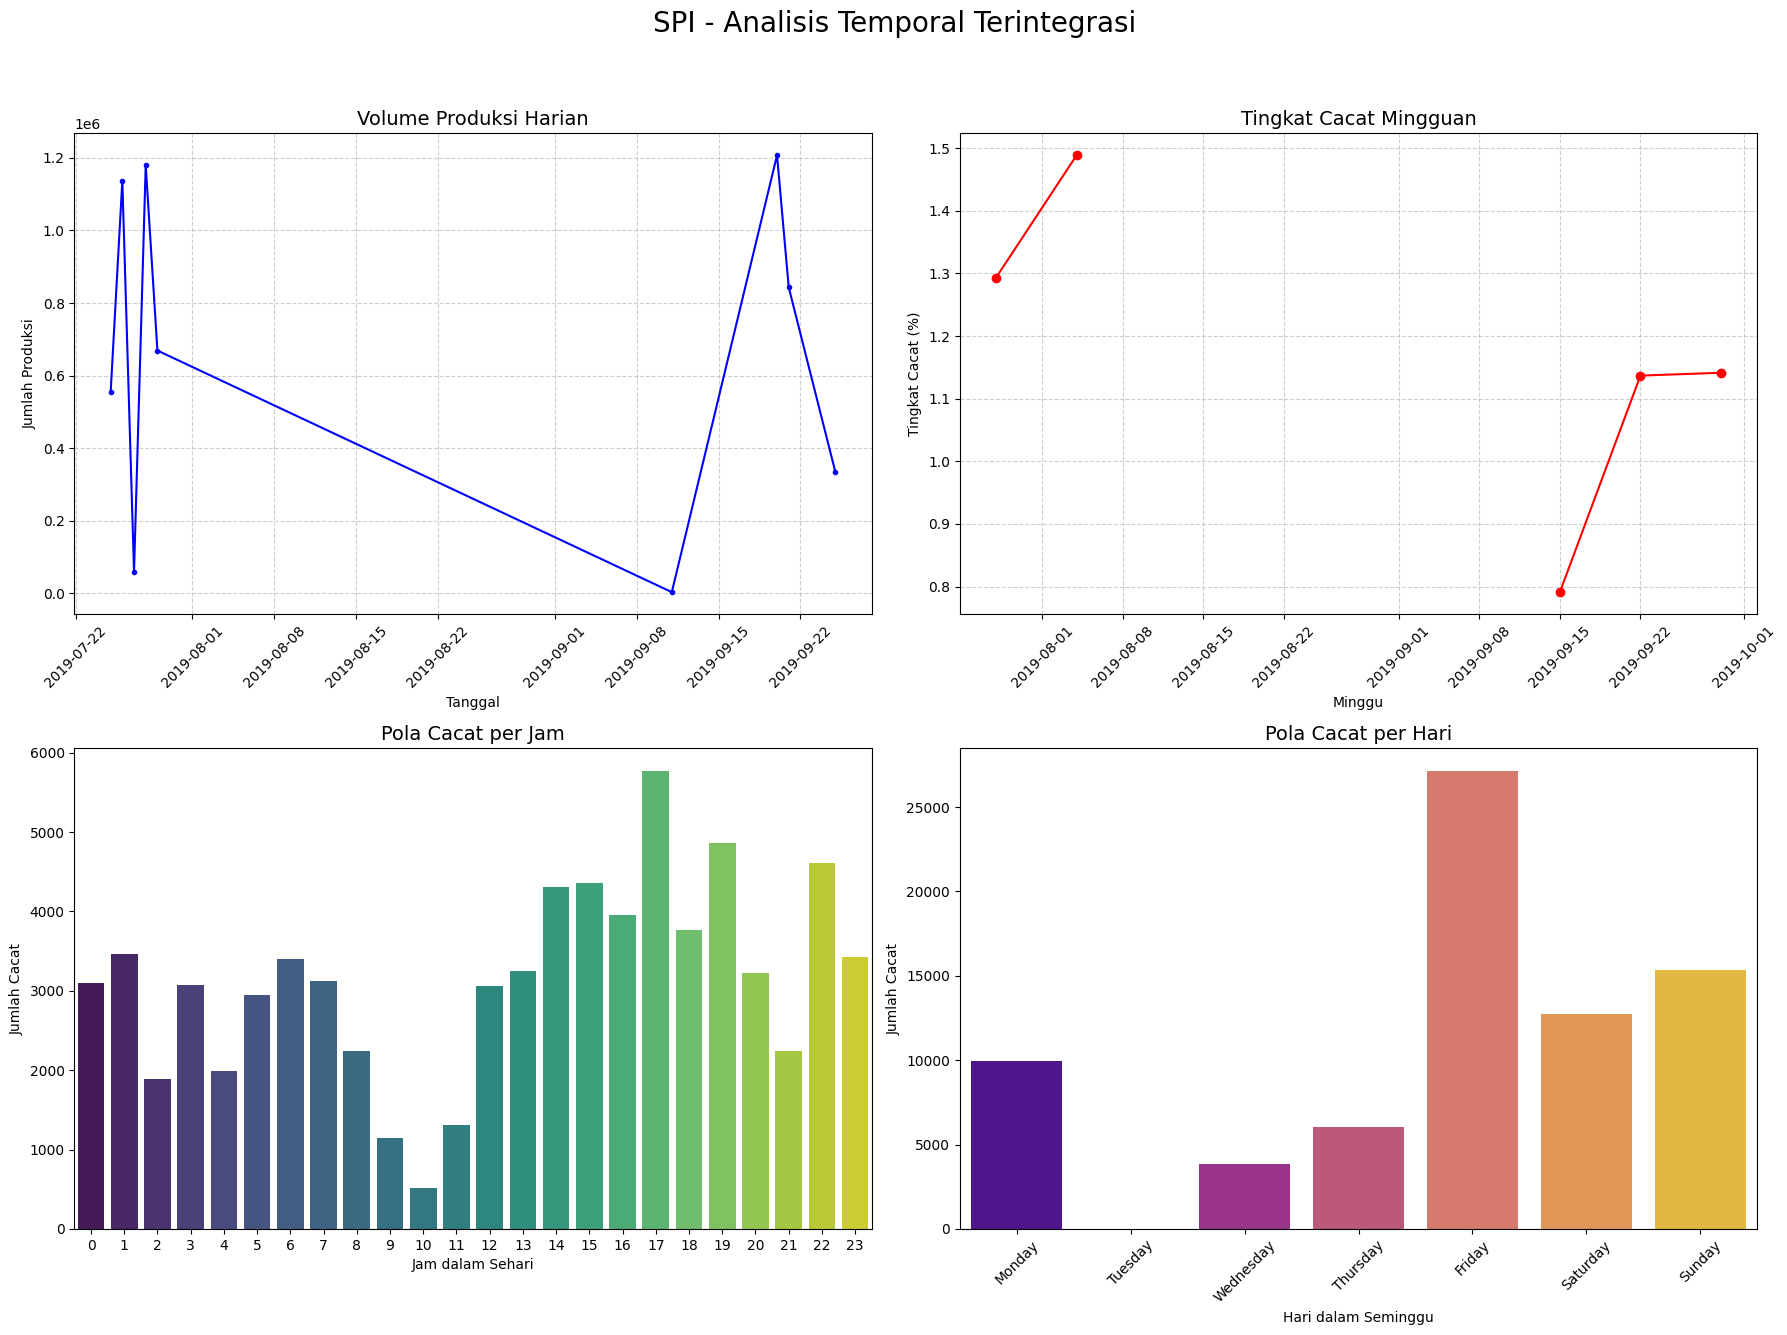

In [ ]:
#SPI - Temporal Analysis

print("SPI Data")
merged_spi['Hour'] = merged_spi['Datetime'].dt.hour
merged_spi['DayOfWeek'] = merged_spi['Datetime'].dt.day_name()
merged_spi['Is_Defect'] = merged_spi['Result'] != 'GOOD'

daily_counts = merged_spi.groupby(merged_spi['Datetime'].dt.date).size()
weekly_defect_rate = merged_spi.groupby(pd.Grouper(key='Datetime', freq='W'))['Is_Defect'].mean() * 100
hourly_defects = merged_spi[merged_spi['Is_Defect']].groupby('Hour').size()
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_defects = merged_spi[merged_spi['Is_Defect']].groupby('DayOfWeek').size().reindex(dow_order)


fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('SPI - Analisis Temporal Terintegrasi', fontsize=20)

axes[0, 0].plot(daily_counts.index, daily_counts.values, marker='.', linestyle='-', color='b')
axes[0, 0].set_title('Volume Produksi Harian', fontsize=14)
axes[0, 0].set_xlabel('Tanggal')
axes[0, 0].set_ylabel('Jumlah Produksi')
axes[0, 0].grid(True, linestyle='--', alpha=0.6)
axes[0, 0].tick_params(axis='x', rotation=45)


axes[0, 1].plot(weekly_defect_rate.index, weekly_defect_rate.values, marker='o', linestyle='-', color='r')
axes[0, 1].set_title('Tingkat Cacat Mingguan', fontsize=14)
axes[0, 1].set_xlabel('Minggu')
axes[0, 1].set_ylabel('Tingkat Cacat (%)')
axes[0, 1].grid(True, linestyle='--', alpha=0.6)
axes[0, 1].tick_params(axis='x', rotation=45)

sns.barplot(x=hourly_defects.index, y=hourly_defects.values, ax=axes[1, 0], palette='viridis')
axes[1, 0].set_title('Pola Cacat per Jam', fontsize=14)
axes[1, 0].set_xlabel('Jam dalam Sehari')
axes[1, 0].set_ylabel('Jumlah Cacat')


sns.barplot(x=daily_defects.index, y=daily_defects.values, ax=axes[1, 1], palette='plasma')
axes[1, 1].set_title('Pola Cacat per Hari', fontsize=14)
axes[1, 1].set_xlabel('Hari dalam Seminggu')
axes[1, 1].set_ylabel('Jumlah Cacat')
axes[1, 1].tick_params(axis='x', rotation=45)


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

analisis temporal ini menyajikan empat perspektif berbeda mengenai dinamika produksi dan kualitas dari waktu ke waktu. Dari sini, kita dapat menarik beberapa wawasan strategis:

* Grafik "Volume Produksi Harian" menunjukkan adanya volatilitas yang tinggi dalam output harian. Hal ini kontras dengan "Tingkat Cacat Mingguan" yang, meskipun juga berfluktuasi, tidak menunjukkan korelasi langsung dengan volume. Artinya, peningkatan volume produksi tidak selalu diikuti dengan penurunan kualitas secara proporsional, dan sebaliknya. Kualitas memiliki dinamikanya sendiri.

* Grafik "Pola Cacat per Jam" dan "per Hari" mengonfirmasi temuan dari investigasi sebelumnya. Puncak jumlah cacat secara konsisten terjadi pada shift sore-malam dan mencapai puncaknya pada hari Jumat. Karena analisis ini mencakup semua jenis cacat, maka dapat disimpulkan bahwa fenomena ini bersifat sistemik dan tidak hanya terbatas pada cacat 'W.Insuffi.'.

Pola waktu kritis (shift malam dan hari Jumat) yang teridentifikasi sebelumnya ternyata berlaku secara umum untuk semua jenis cacat. Ini memperkuat argumen bahwa ada masalah fundamental yang terjadi pada periode-periode tersebut—kemungkinan terkait manajemen proses, kelelahan operator, atau perawatan mesin—yang perlu menjadi fokus utama untuk perbaikan kualitas secara menyeluruh.

Setelah memahami pola temporal produksi, langkah selanjutnya adalah membedah distribusi dan karakteristik dari setiap parameter pengukuran fisik itu sendiri. Analisis ini bertujuan untuk memahami sebaran data, mengidentifikasi keberadaan nilai-nilai ekstrem (outliers), dan mendapatkan gambaran umum mengenai variabilitas proses dari setiap fitur numerik yang terekam selama inspeksi SPI.

                 count          mean           std      min           25%           50%           75%           max
PadType      5985381.0  4.550248e+00  4.979732e+00    0.000  0.000000e+00  0.000000e+00  1.000000e+01  1.000000e+01
Volume(%)    5985381.0  9.255412e+01  1.139325e+01    0.000  8.550800e+01  9.218300e+01  9.914200e+01  3.880840e+02
Height(um)   5985381.0  1.123681e+02  9.597775e+00   35.000  1.061450e+02  1.124810e+02  1.185710e+02  3.338740e+02
Area(%)      5985381.0  9.919887e+01  7.689098e+00    0.000  9.392500e+01  9.936600e+01  1.039100e+02  1.801730e+02
OffsetX(%)   5985381.0  9.643866e-01  2.750223e+00  -38.812 -4.260000e-01  6.440000e-01  2.130000e+00  4.097600e+01
OffsetY(%)   5985381.0  2.834259e-01  5.828129e+00 -103.180 -2.741000e+00  1.150000e-01  3.150000e+00  9.119700e+01
SizeX        5985381.0  8.716995e-01  8.159855e-01    0.187  5.000000e-01  5.000000e-01  1.070000e+00  5.100000e+00
SizeY        5985381.0  7.721099e-01  7.505808e-01    0.220  5.000000e-0

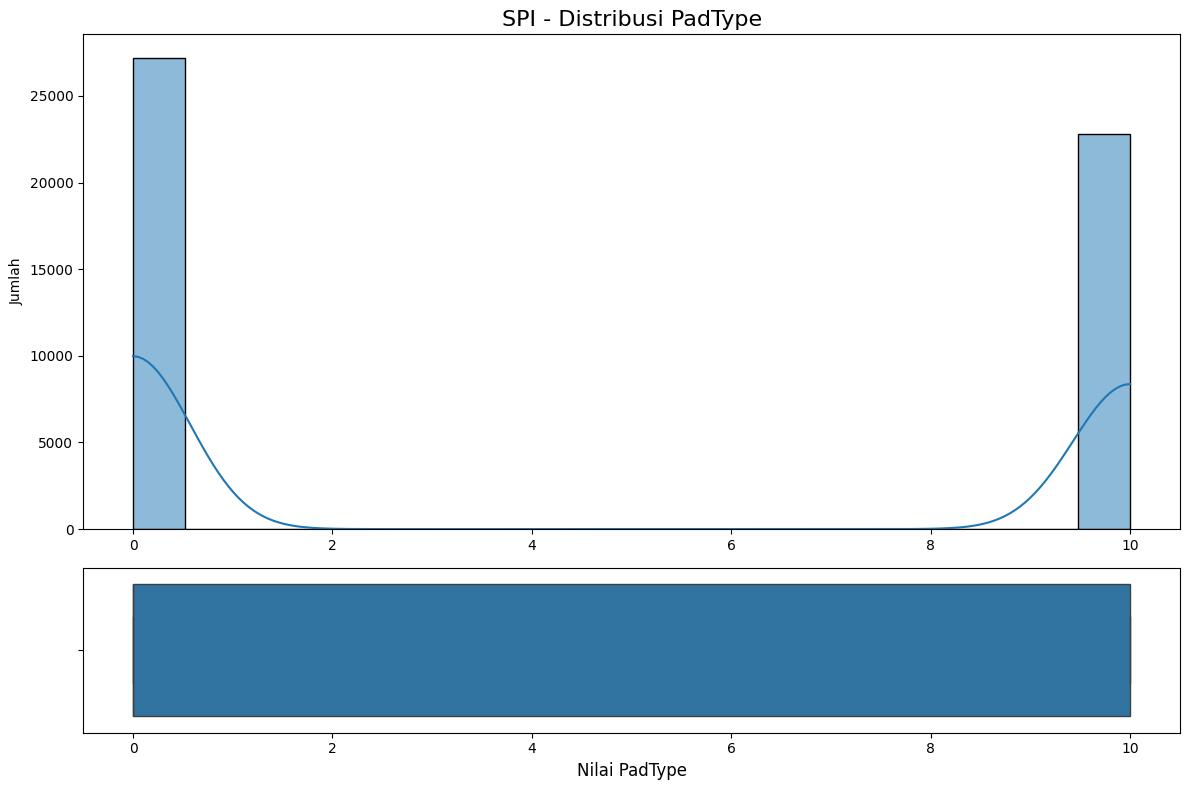

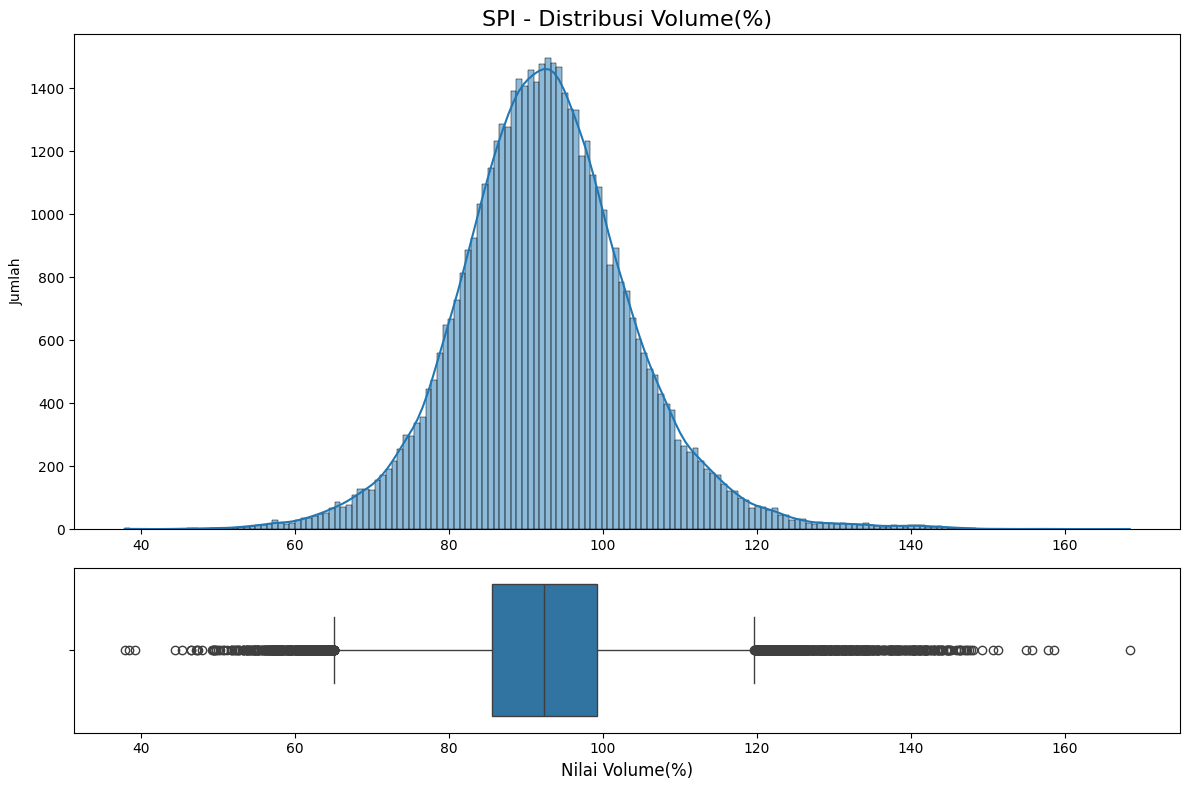

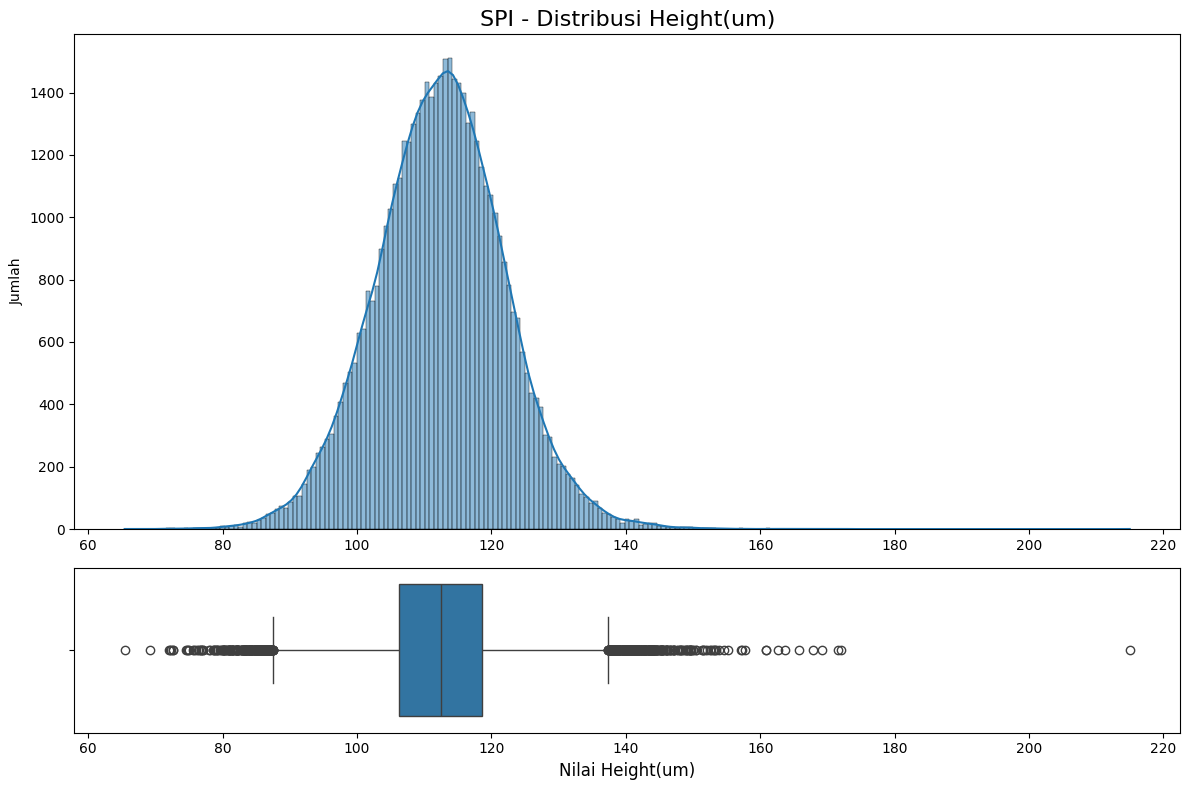

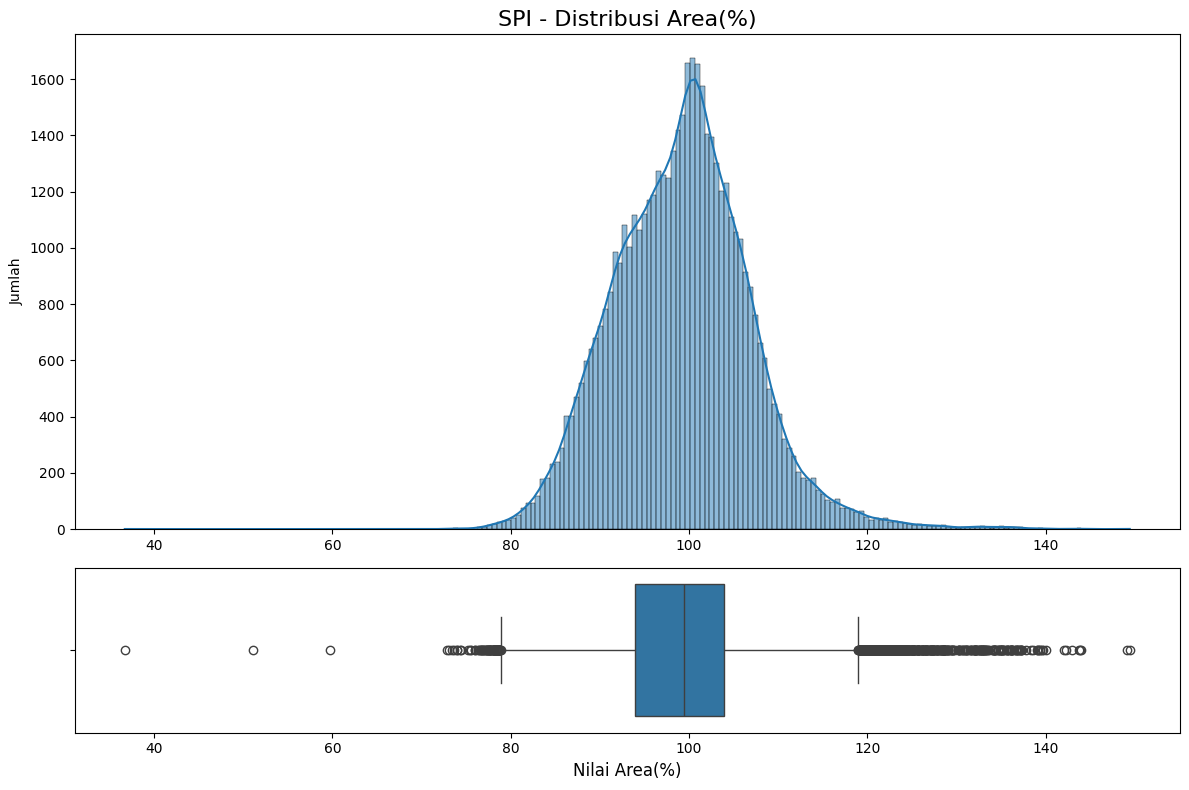

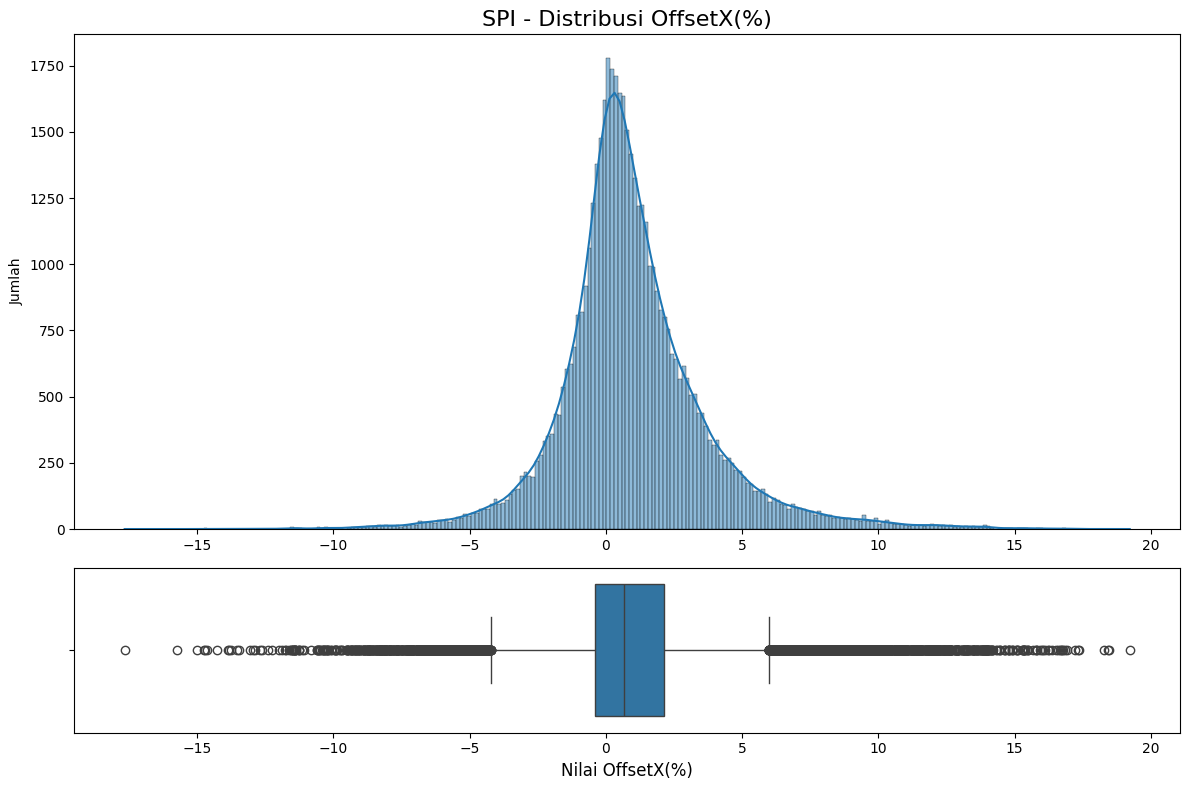

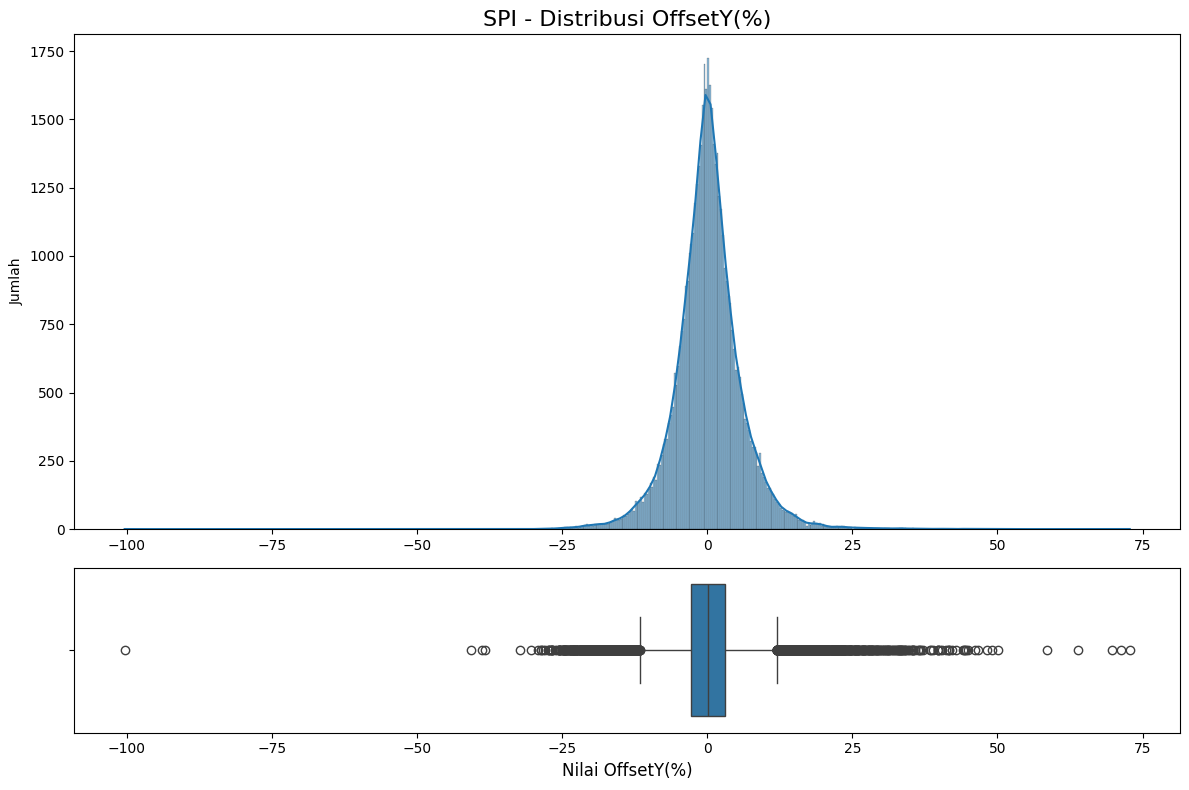

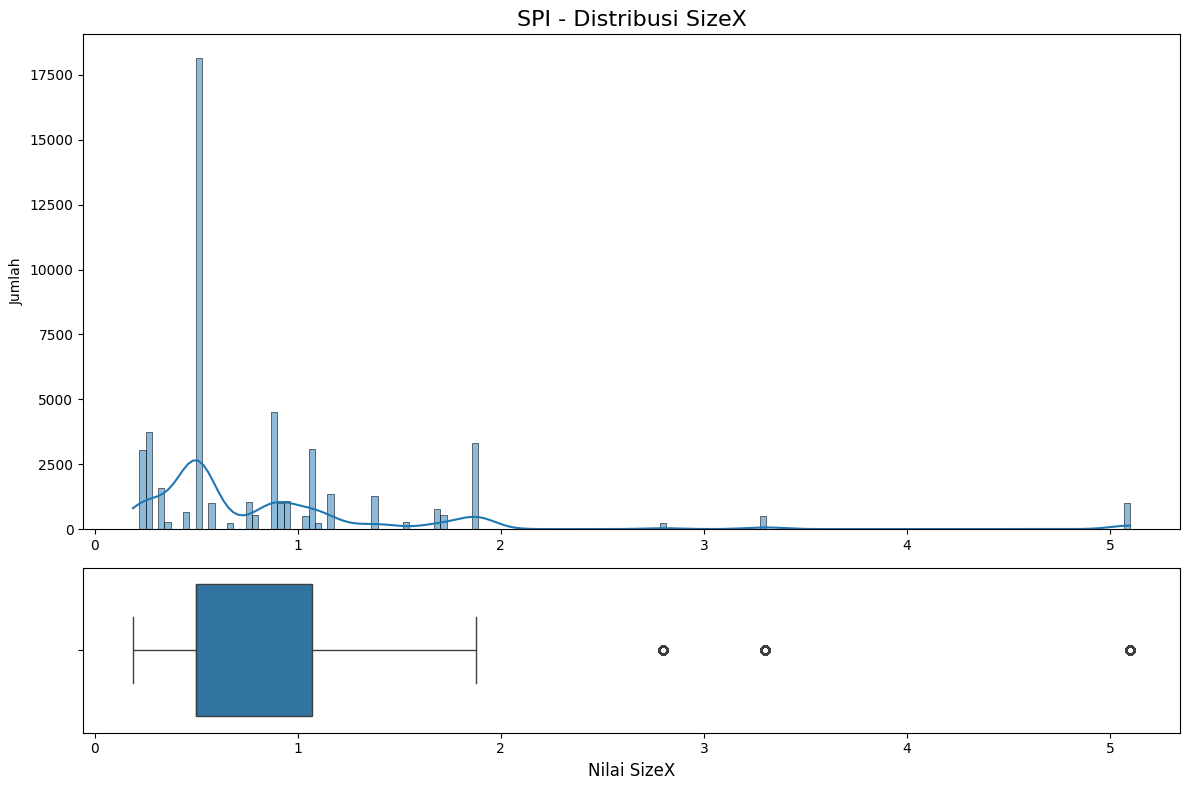

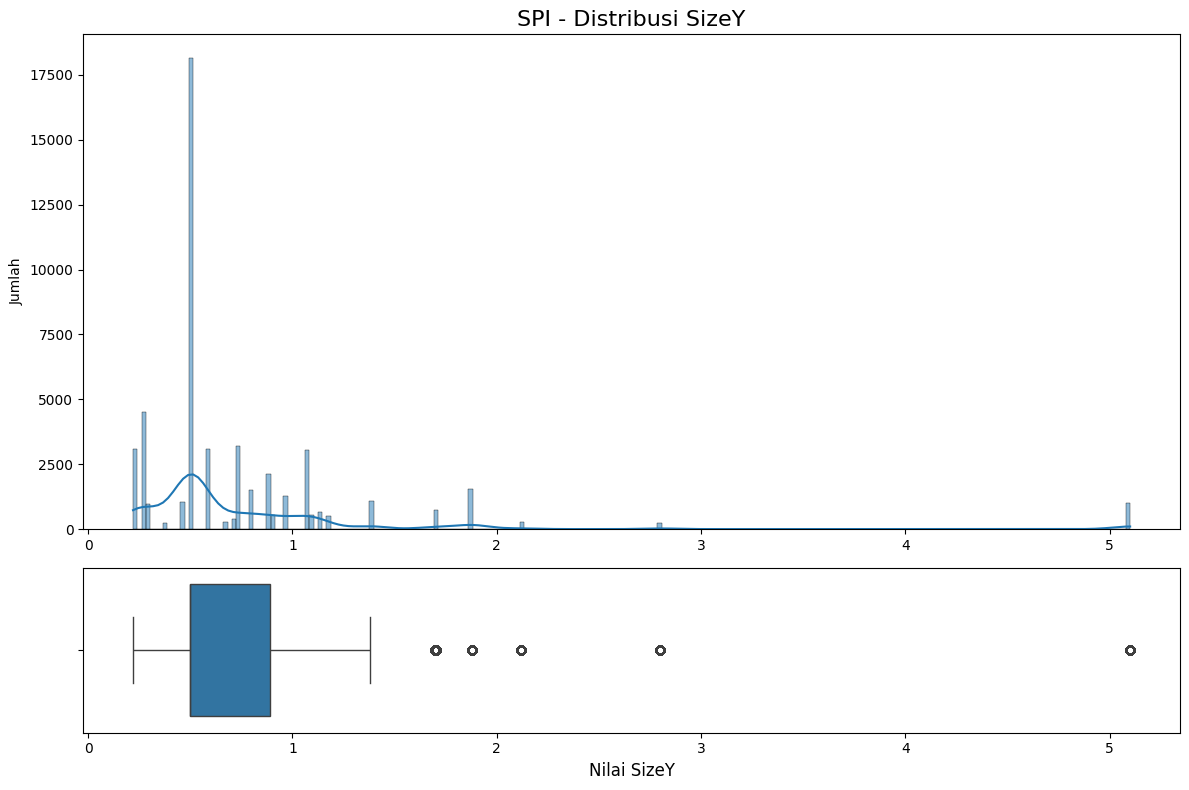

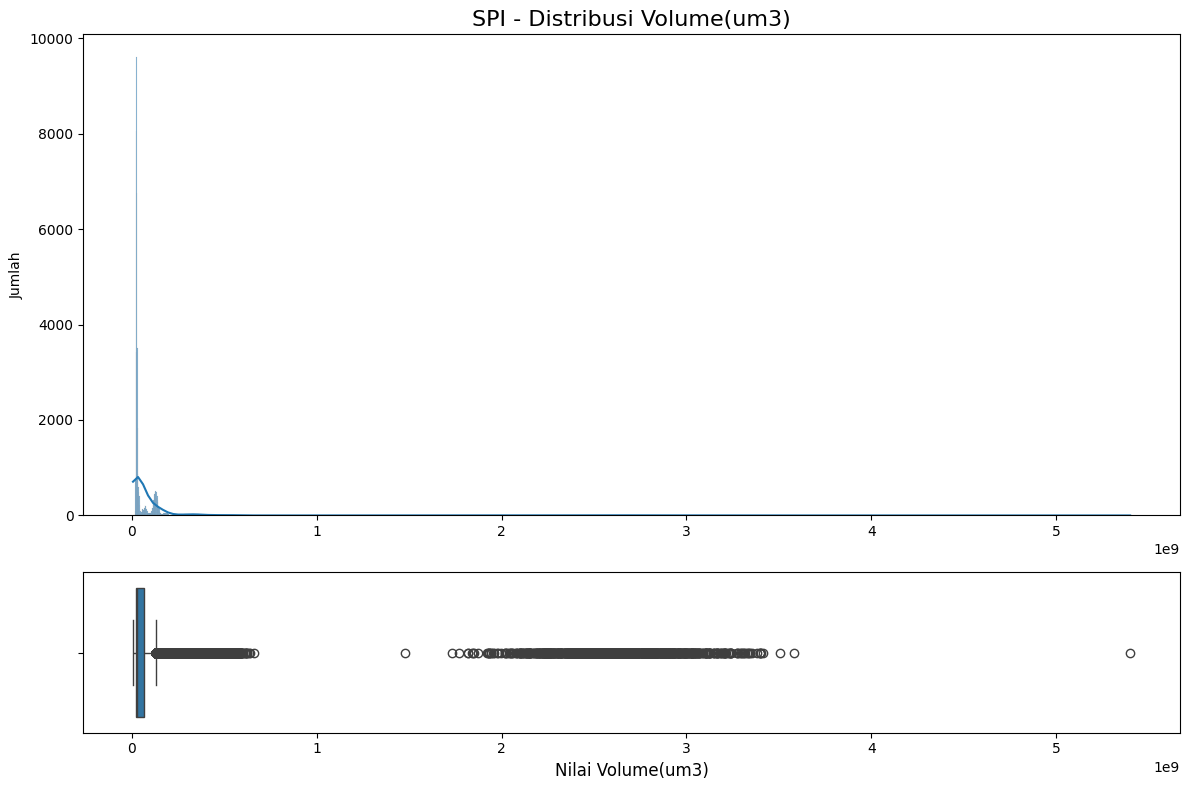

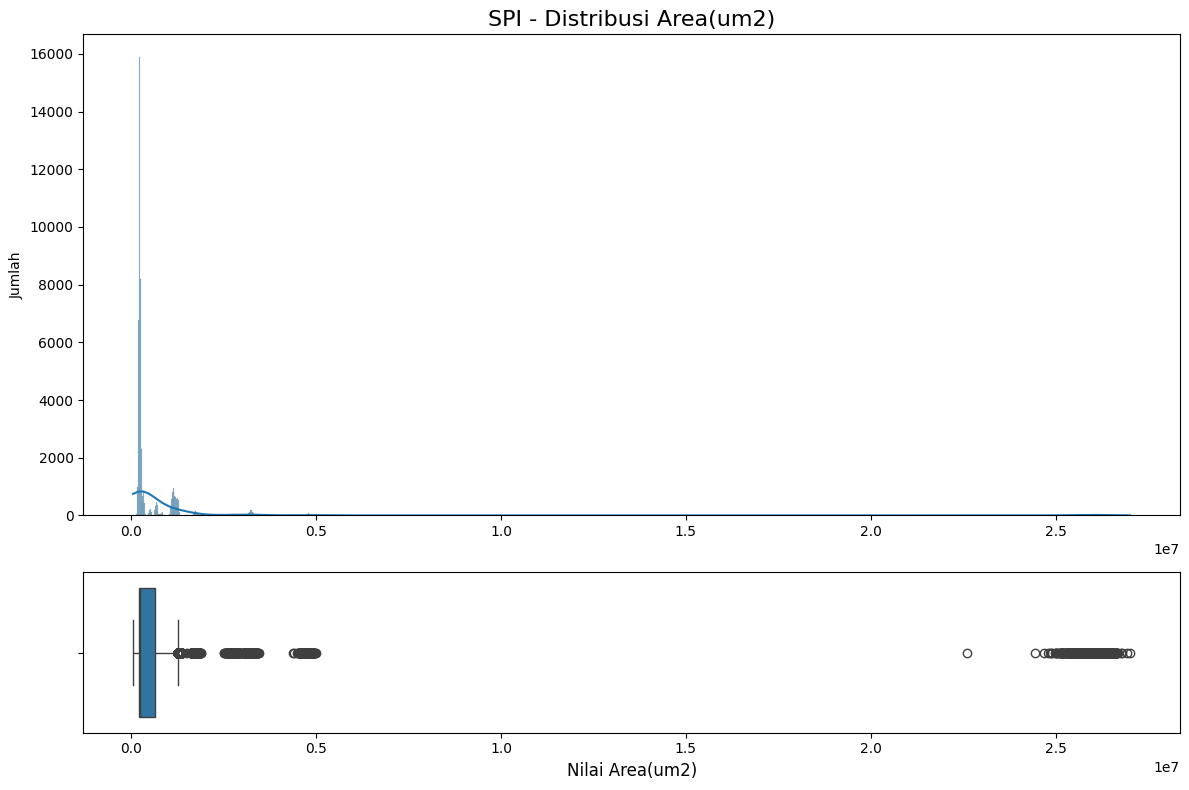

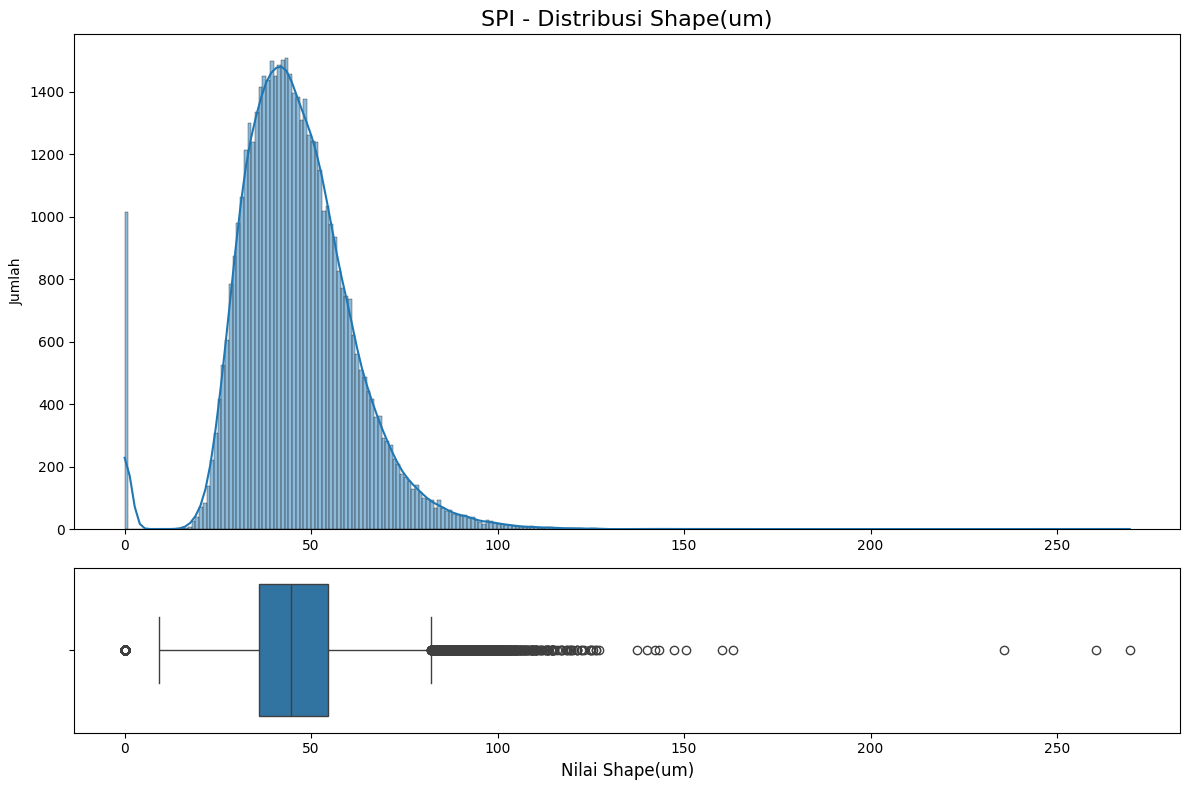

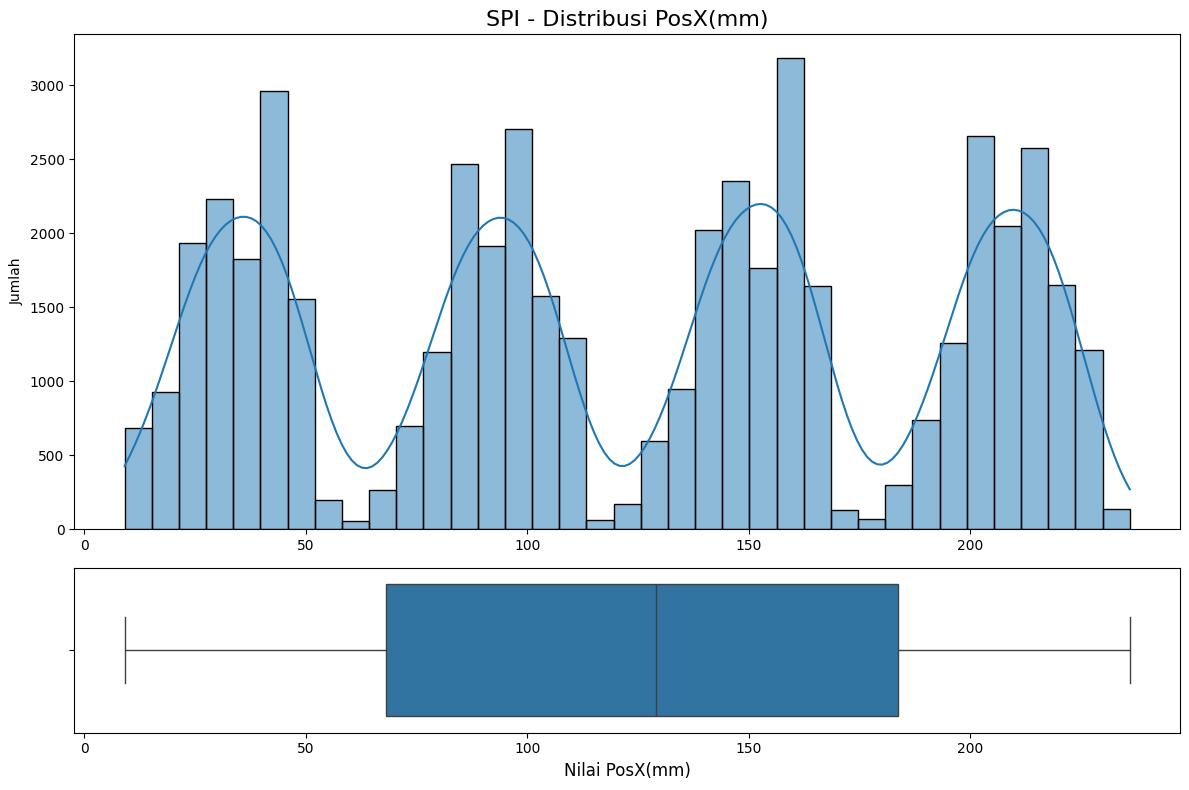

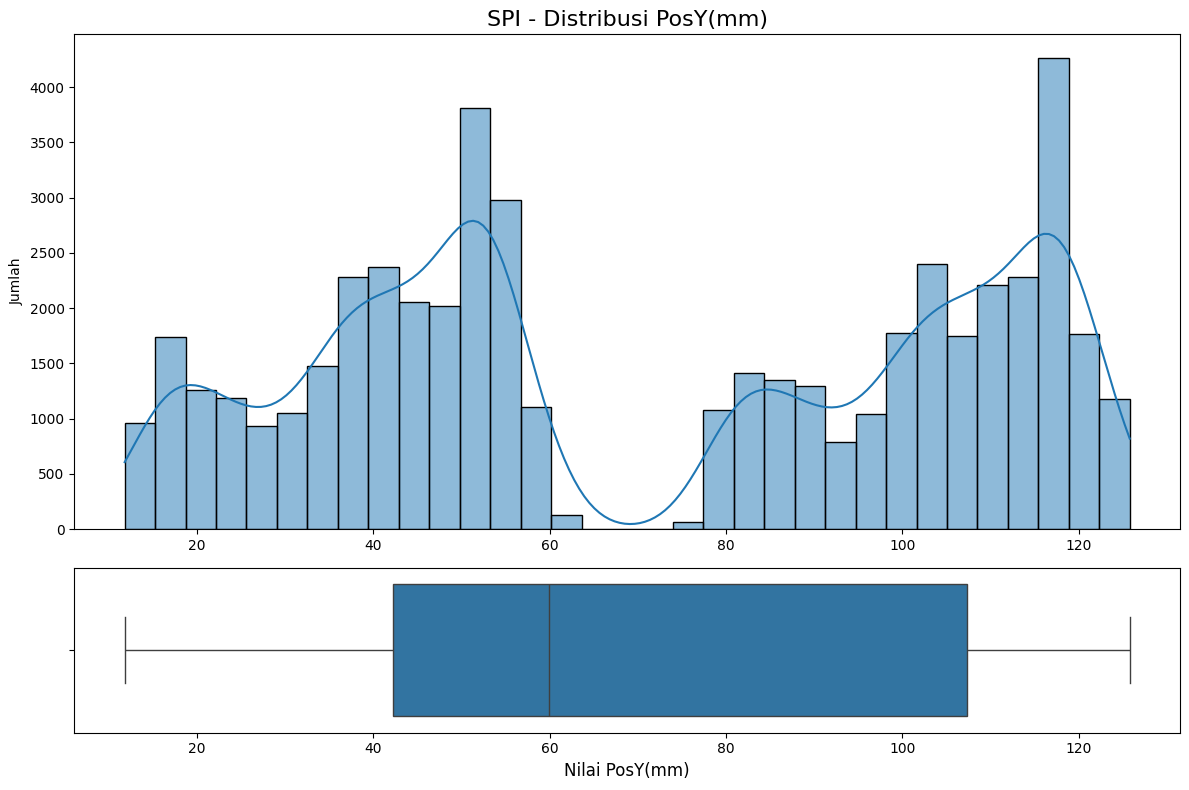

In [ ]:
#SPI - NUMERICAL ANALYSIS
numerical_cols = merged_spi.select_dtypes(include=np.number).columns.tolist()
cols_to_remove = [col for col in ['FigureID', 'PadID', 'Is_Defect', 'Hour'] if col in numerical_cols]
for col in cols_to_remove:
    numerical_cols.remove(col)

print(merged_spi[numerical_cols].describe().transpose())
df_sample = merged_spi.sample(n=50000, random_state=42)

for col in numerical_cols:

    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

    ax_hist = fig.add_subplot(gs[0])
    sns.histplot(data=df_sample, x=col, kde=True, ax=ax_hist)
    ax_hist.set_title(f'SPI - Distribusi {col}', fontsize=16)
    ax_hist.set_xlabel('')
    ax_hist.set_ylabel('Jumlah')

    ax_box = fig.add_subplot(gs[1], sharex=ax_hist)
    sns.boxplot(data=df_sample, x=col, ax=ax_box)
    ax_box.set_xlabel(f'Nilai {col}', fontsize=12)

    plt.tight_layout()
    plt.show()

Analisis distribusi pada seluruh fitur numerik memberikan gambaran yang jelas mengenai variabilitas dalam proses produksi. Baik dari tabel statistik deskriptif maupun dari visualisasi histogram, terlihat sebuah pola yang konsisten:

* Hampir semua parameter pengukuran utama (Volume(%), Height(um), Area(%), OffsetX/Y(%)) menunjukkan distribusi yang tidak normal (terlihat dari perbedaan antara mean dan median/50%). Distribusi ini cenderung sangat terpusat pada nilai rata-rata, namun memiliki "ekor" yang panjang, yang menandakan adanya nilai-nilai ekstrem atau outliers.

* Pada Volume(%) dan Area(%), keberadaan outliers di sisi kanan (nilai max yang jauh lebih tinggi dari 75% persentil) mengindikasikan adanya kasus di mana volume pasta solder yang diaplikasikan jauh berlebih. Ini adalah kebalikan dari cacat 'W.Insuffi.' dan berpotensi menyebabkan cacat lain.

* Meskipun rata-rata OffsetX(%) dan OffsetY(%) mendekati nol (menandakan penempatan yang akurat secara umum), rentang nilai dari min ke max sangat lebar. Ini menunjukkan bahwa meskipun jarang, terjadi kasus pergeseran posisi komponen yang signifikan.

Proses produksi SPI secara umum berjalan dengan konsisten (terlihat dari data yang terpusat), namun tidak kebal dari adanya variasi proses yang ekstrem. Keberadaan outliers ini, baik pada kuantitas solder maupun pada posisi, adalah sumber utama dari potensi cacat. Memahami karakteristik outliers ini akan menjadi sangat penting untuk pemodelan selanjutnya.

Selanjutnya, Analisis korelasi ini bertujuan untuk mengidentifikasi adanya hubungan linear antar variabel, yang dapat mengindikasikan redundansi informasi dan membantu dalam proses seleksi fitur untuk pemodelan.

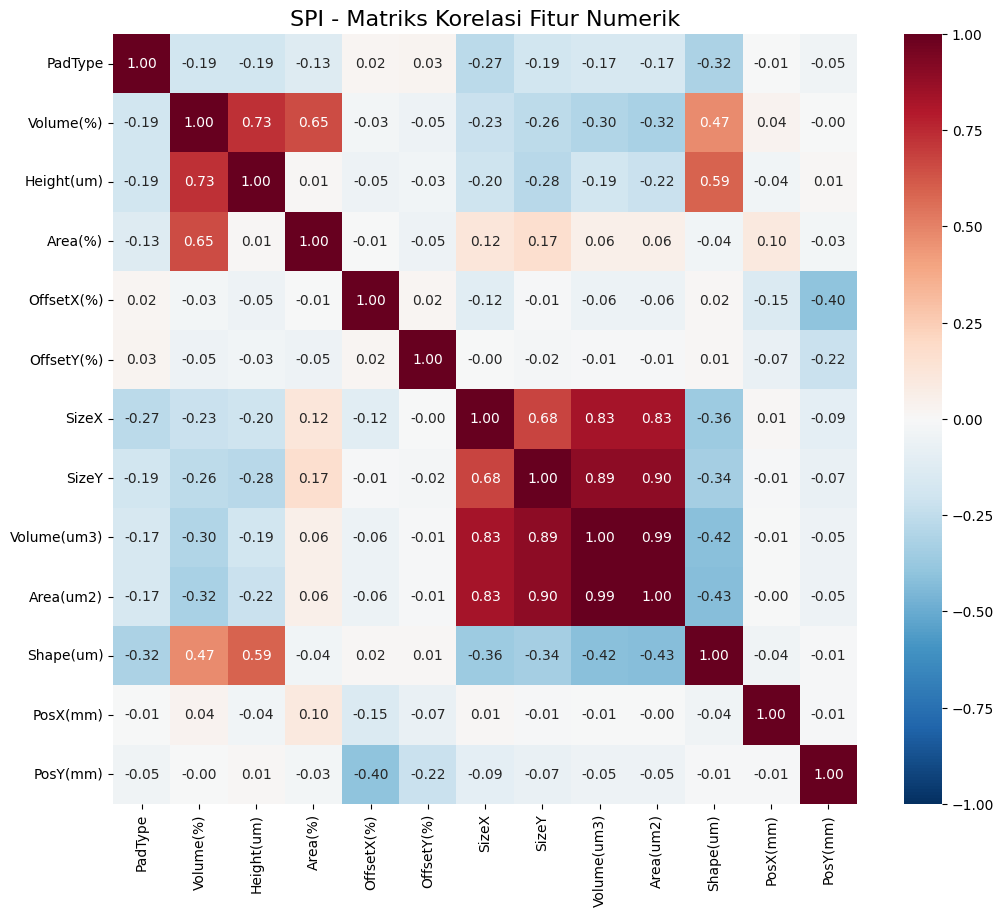


Fitur dengan Korelasi Tinggi (|r| > 0.7):
Volume(um3)  Area(um2)     0.993254
SizeY        Area(um2)     0.896064
Volume(um3)  SizeY         0.891054
SizeX        Area(um2)     0.832414
Volume(um3)  SizeX         0.831265
Volume(%)    Height(um)    0.732496
dtype: float64


In [ ]:
#SPI - CORRELATION
corr_matrix = merged_spi[numerical_cols].corr()

plt.figure(figsize=(12, 10))

sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', vmin=-1, vmax=1)


plt.title('SPI - Matriks Korelasi Fitur Numerik', fontsize=16)
plt.show()

high_corr_pairs = corr_matrix.abs().unstack().sort_values(ascending=False)
high_corr_pairs = high_corr_pairs[high_corr_pairs > 0.7]
high_corr_pairs = high_corr_pairs[high_corr_pairs < 1.0]
print("\nFitur dengan Korelasi Tinggi (|r| > 0.7):")
print(high_corr_pairs.drop_duplicates())

Terdapat beberapa kelompok fitur yang memiliki hubungan linear yang sangat kuat.
Teridentifikasi adanya korelasi yang mendekati sempurna (r > 0.99) antara Volume(um3) dan Area(um2). Hubungan yang sangat kuat juga terlihat antara dimensi fisik (SizeX dan SizeY) dengan Area(um2) dan Volume(um3). Hal ini sangat wajar karena fitur-fitur ini secara matematis saling terkait (misalnya, volume adalah turunan dari luas dan tinggi).

Terdapat korelasi positif yang kuat (r = 0.73) antara Volume(%) dan Height(um). Ini secara logis mengonfirmasi bahwa semakin tinggi pasta solder yang diaplikasikan, semakin besar pula persentase volume relatif terhadap ukuran pad.

In [ ]:
# SPI - CATEGORICAL
categorical_cols = merged_spi.select_dtypes(include=['object', 'category']).columns.tolist()
cols_to_remove_cat = [col for col in ['Result', 'DayOfWeek'] if col in categorical_cols]
for col in cols_to_remove_cat:
    categorical_cols.remove(col)
for col in categorical_cols:
    counts = merged_spi[col].value_counts()
    print(f"\nunique value: {len(counts)}")
    print("10 most common value:")
    print(counts.head(10))


unique value: 1924
10 most common value:
PanelID
25319088000520102844    3160
26919050700520102844    3112
26919050600520102844    3112
26919050300520102844    3112
26919050000520102844    3112
26919049800520102844    3112
26919049700520102844    3112
26919049500520102844    3112
26919049300520102844    3112
26919045000520102844    3112
Name: count, dtype: int64

unique value: 129
10 most common value:
ComponentID
U3      753865
TR1     123096
IC1     123096
TR2     123096
RA1     123096
RA3     123096
RA2     123096
TR3     123090
U5      123080
TRB5     92316
Name: count, dtype: int64

unique value: 49
10 most common value:
PinNumber
1           1969523
2           1969522
3            307727
4            292341
5            292341
6            246186
7            138478
8            138478
THERMAL1      15385
9             15385
Name: count, dtype: int64


Setelah menganalisis hubungan antar fitur numerik, fokus analisis kini beralih ke hubungan antara fitur-fitur tersebut dengan variabel target (Is_Defect). Tahap ini krusial untuk mengidentifikasi fitur-fitur mana yang memiliki daya pembeda (discriminative power) paling kuat antara produk 'GOOD' dan 'DEFECT'.

/tmp/ipython-input-20-1187428981.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_sample_violin, x='Is_Defect_Label', y=col, palette=['#34A853', '#EA4335'], inner='box')


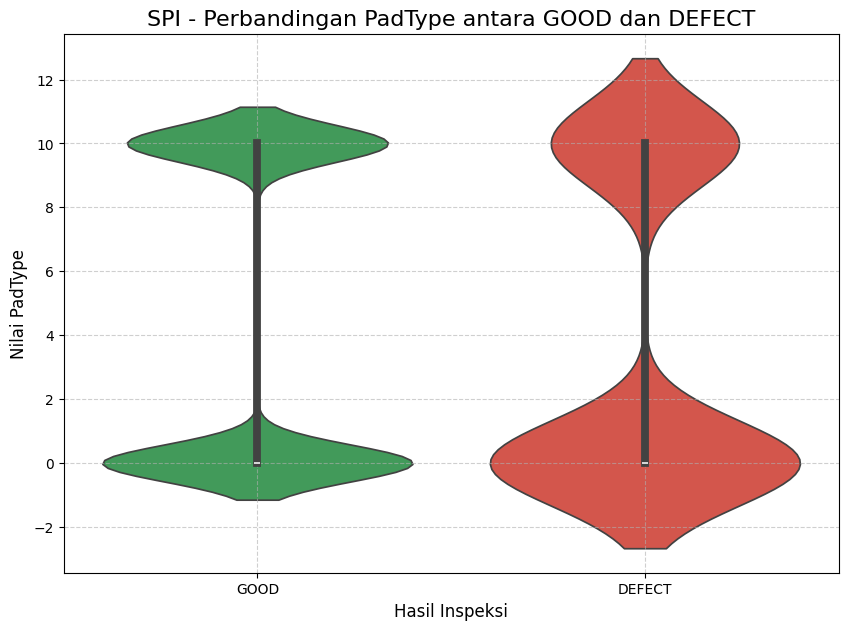

/tmp/ipython-input-20-1187428981.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_sample_violin, x='Is_Defect_Label', y=col, palette=['#34A853', '#EA4335'], inner='box')


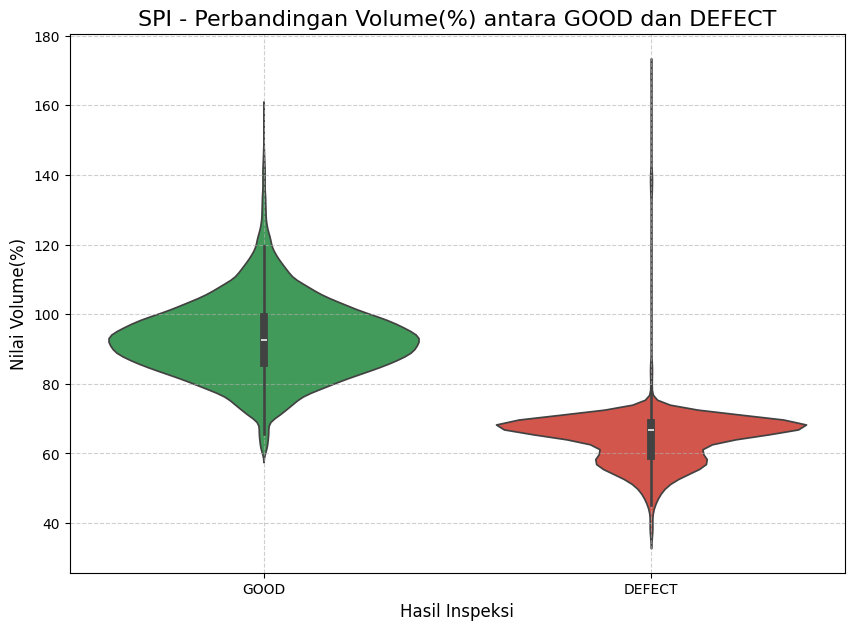

/tmp/ipython-input-20-1187428981.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_sample_violin, x='Is_Defect_Label', y=col, palette=['#34A853', '#EA4335'], inner='box')


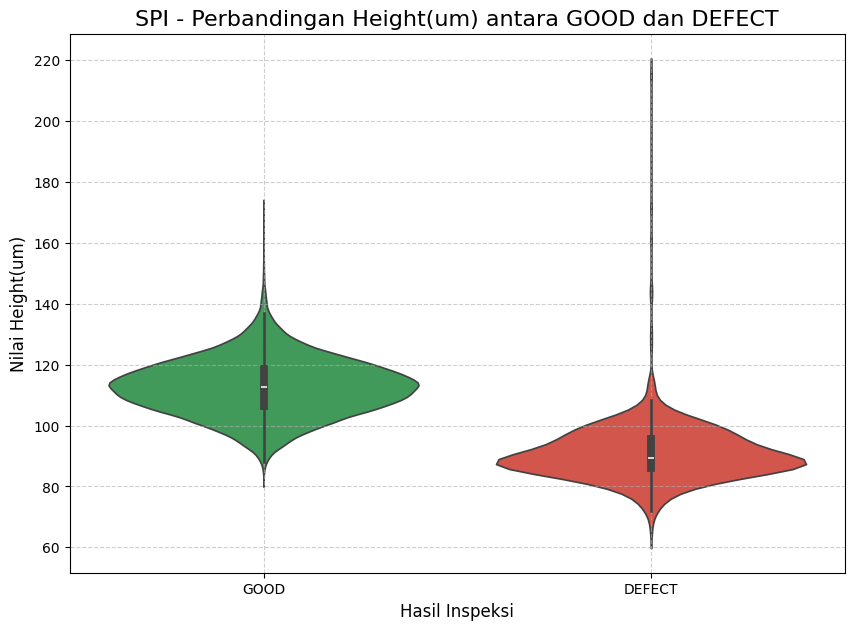

/tmp/ipython-input-20-1187428981.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_sample_violin, x='Is_Defect_Label', y=col, palette=['#34A853', '#EA4335'], inner='box')


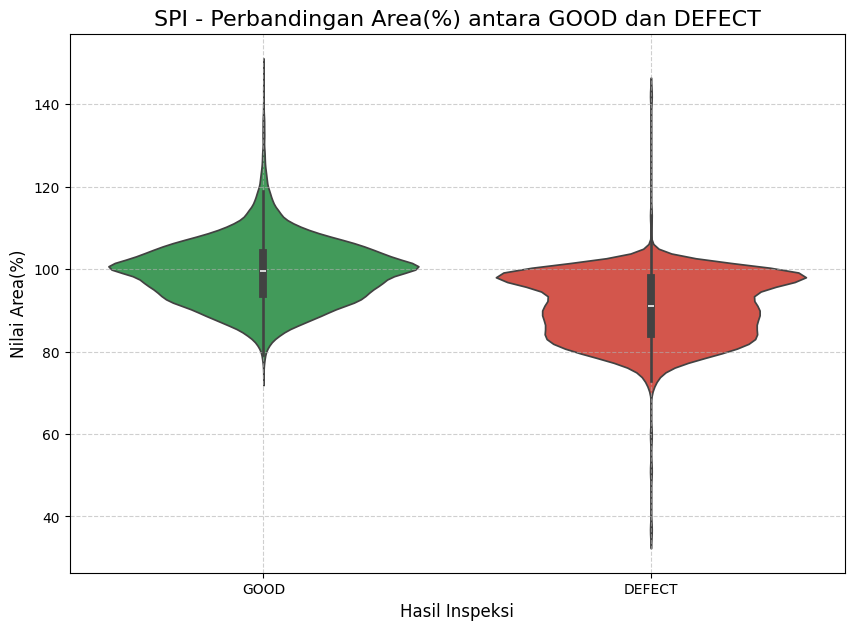

/tmp/ipython-input-20-1187428981.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_sample_violin, x='Is_Defect_Label', y=col, palette=['#34A853', '#EA4335'], inner='box')


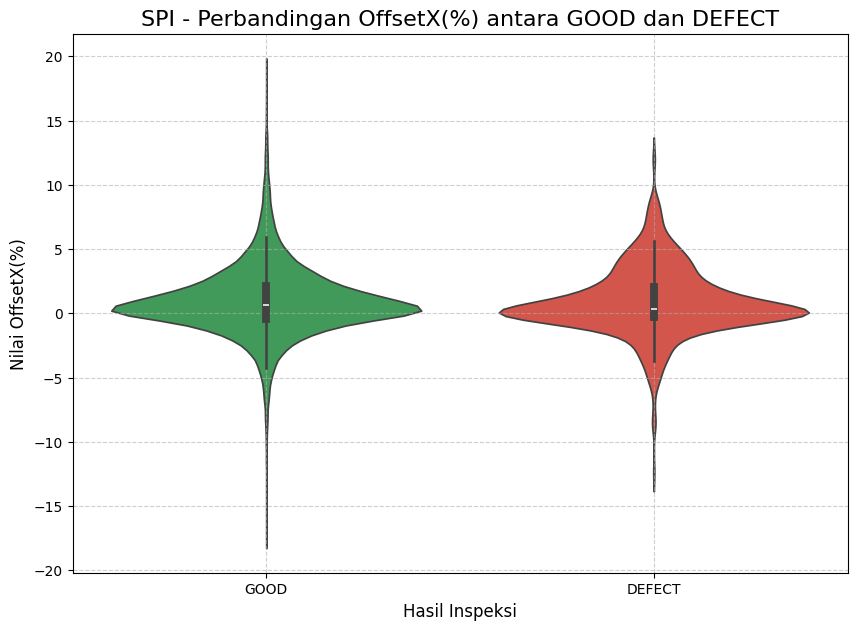

In [ ]:
#Bivariate Analysis

merged_spi['Is_Defect_Label'] = merged_spi['Is_Defect'].map({False: 'GOOD', True: 'DEFECT'})

df_sample_violin = merged_spi.sample(n=50000, random_state=42)

for col in numerical_cols[:5]:
    plt.figure(figsize=(10, 7))

    sns.violinplot(data=df_sample_violin, x='Is_Defect_Label', y=col, palette=['#34A853', '#EA4335'], inner='box')

    plt.title(f'SPI - Perbandingan {col} antara GOOD dan DEFECT', fontsize=16)
    plt.xlabel('Hasil Inspeksi', fontsize=12)
    plt.ylabel(f'Nilai {col}', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

Visualisasi perbandingan distribusi menggunakan violin plot memberikan salah satu wawasan paling fundamental dalam analisis ini yaitu variabilitas adalah penyebab utama dari cacat produksi.

* Untuk semua parameter (Volume(%), Height(um), Area(%)), distribusi untuk produk 'GOOD' terlihat tinggi dan ramping. Ini menunjukkan bahwa produk yang berkualitas memiliki variansi yang sangat rendah dan pengukurannya sangat konsisten di sekitar nilai ideal.

* Sebaliknya, distribusi untuk produk 'DEFECT' terlihat lebar dan pendek. Ini menandakan adanya variansi yang sangat tinggi. Cacat terjadi ketika parameter pengukuran menyimpang secara signifikan dari titik ideal, baik ke arah yang lebih rendah maupun ke arah yang lebih tinggi (yang berpotensi menyebabkan cacat lain).

* Plot ini dengan jelas menunjukkan bahwa fitur seperti Volume(%) dan Height(um) memiliki daya pembeda yang sangat kuat, karena bentuk distribusi antara kategori 'GOOD' dan 'DEFECT' sangat berbeda.

Kunci untuk mencapai kualitas produksi yang tinggi adalah dengan menjaga konsistensi dan meminimalkan variabilitas proses

Analisis ini membantu kita untuk melihat apakah ada pola atau "hotspot" geografis pada panel itu sendiri, yang dapat memberikan petunjuk tambahan mengenai akar masalah.

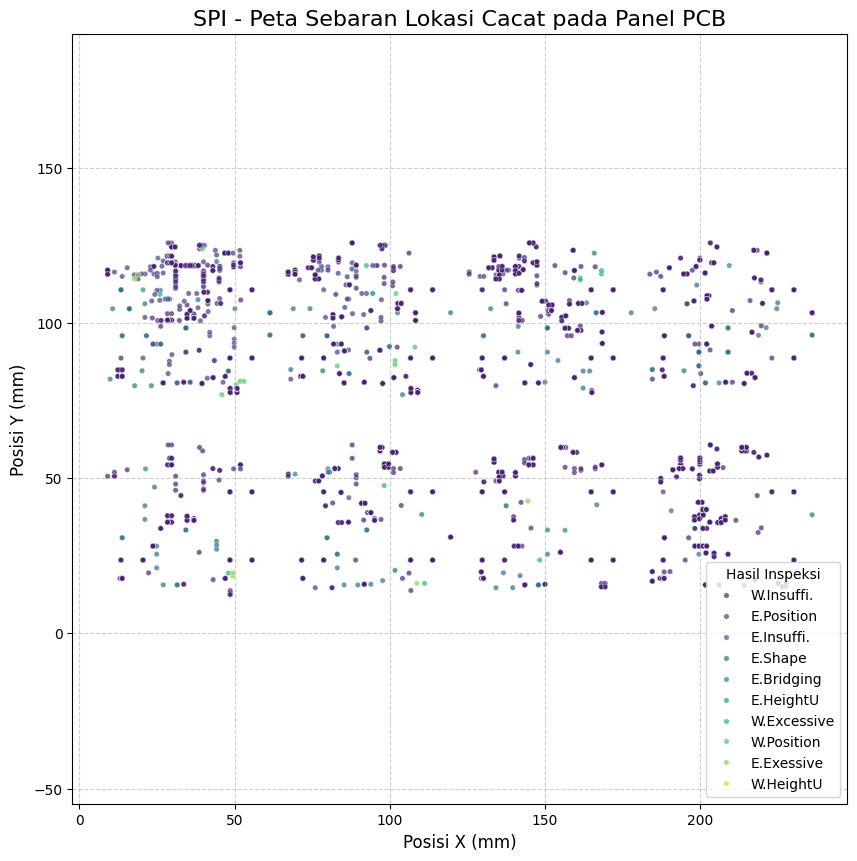

In [ ]:
#SPATIAL ANANLYSIS

df_defects_sample = merged_spi[merged_spi['Is_Defect']].sample(n=20000, random_state=42)

plt.figure(figsize=(10, 10))

sns.scatterplot(data=df_defects_sample, x='PosX(mm)', y='PosY(mm)', hue='Result', palette='viridis', s=15, alpha=0.7)

plt.title('SPI - Peta Sebaran Lokasi Cacat pada Panel PCB', fontsize=16)
plt.xlabel('Posisi X (mm)', fontsize=12)
plt.ylabel('Posisi Y (mm)', fontsize=12)
plt.legend(title='Hasil Inspeksi')
plt.grid(True, linestyle='--', alpha=0.6)

plt.axis('equal')

plt.show()

* Poin paling signifikan adalah sebaran cacat sama sekali tidak acak. Cacat membentuk pola yang sangat terstruktur, berupa klaster-klaster dan barisan-barisan yang jelas, yang merefleksikan tata letak fisik komponen di atas papan sirkuit.

Masalah kualitas tidak hanya terikat pada jenis komponen atau waktu produksi, tetapi juga pada lokasi fisik di panel. Adanya hotspot dapat mengindikasikan masalah yang lebih dalam, seperti ketidakrataan pada proses aplikasi pasta solder atau pemanasan di area tertentu.

In [ ]:
component_defect_rate = merged_spi.groupby(["ComponentID"])["Is_Defect"].mean().sort_values(ascending=False) * 100
component_total_count = merged_spi['ComponentID'].value_counts()
component_summary = pd.DataFrame({
    'Defect_Rate(%)': component_defect_rate,
    'Total_Count': component_total_count
})

significant_components = component_summary[component_summary['Total_Count'] > 1000].sort_values(by='Defect_Rate(%)', ascending=False)

print("Top 10 Komponen Paling Bermasalah (>1000 kemunculan):\n")
print(significant_components.head(10))

Top 10 Komponen Paling Bermasalah (>1000 kemunculan):

             Defect_Rate(%)  Total_Count
ComponentID                             
BC3               40.238513        30774
BC1               14.349776        30774
R19               14.132060        30774
BC2               10.131930        30774
R22                6.502242        30774
C23                6.138299        30774
TRB4               5.577581        92316
R29                5.416910        30774
TRB2               4.856146        92316
R24                4.208098        30774


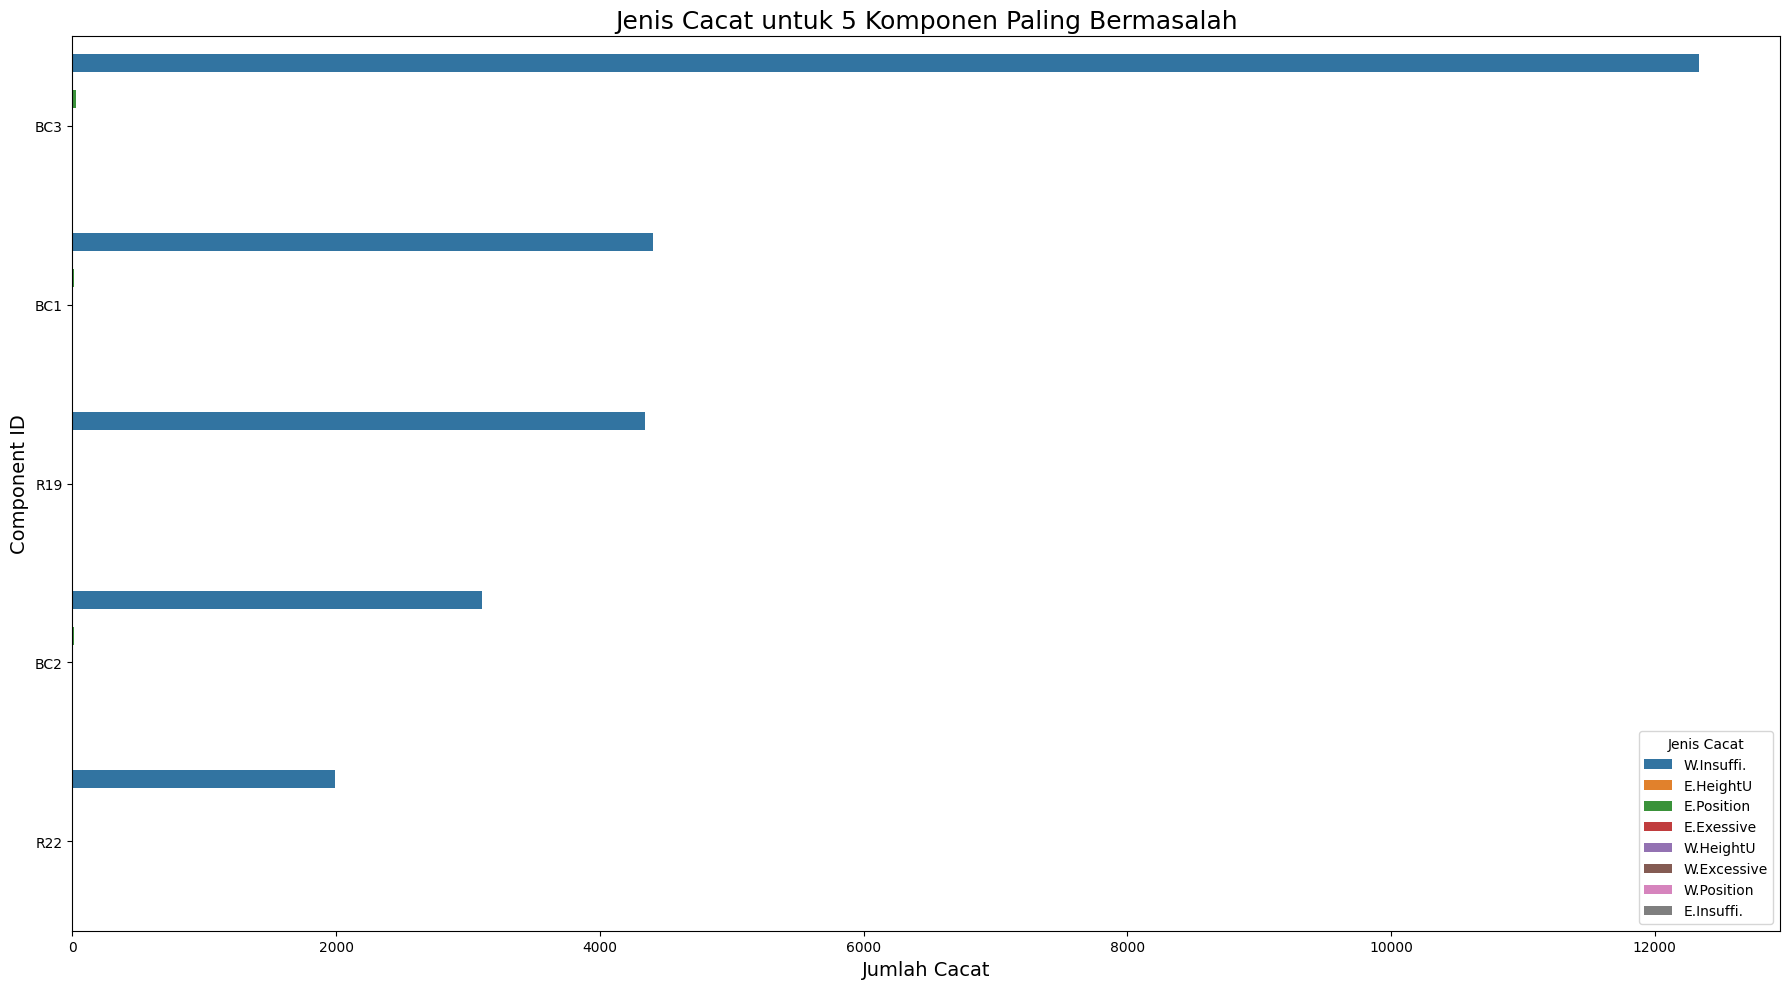

In [ ]:
top_5_problem_components = significant_components.head(5).index

plt.figure(figsize=(18, 10))
top_defects_df = merged_spi[merged_spi['ComponentID'].isin(top_5_problem_components) & (merged_spi['Is_Defect'])]
sns.countplot(data=top_defects_df, y='ComponentID', hue='Result', order=top_5_problem_components)
plt.title('Jenis Cacat untuk 5 Komponen Paling Bermasalah', fontsize=18)
plt.xlabel('Jumlah Cacat', fontsize=14)
plt.ylabel('Component ID', fontsize=14)
plt.legend(title='Jenis Cacat')
plt.tight_layout()
plt.show()

Setelah membandingkan distribusi antara 'GOOD' dan 'DEFECT' secara umum, analisis ini melangkah lebih jauh dengan membedah distribusi fitur numerik untuk setiap jenis cacat spesifik. Tujuannya adalah untuk memahami karakteristik unik dari masing-masing jenis kegagalan.

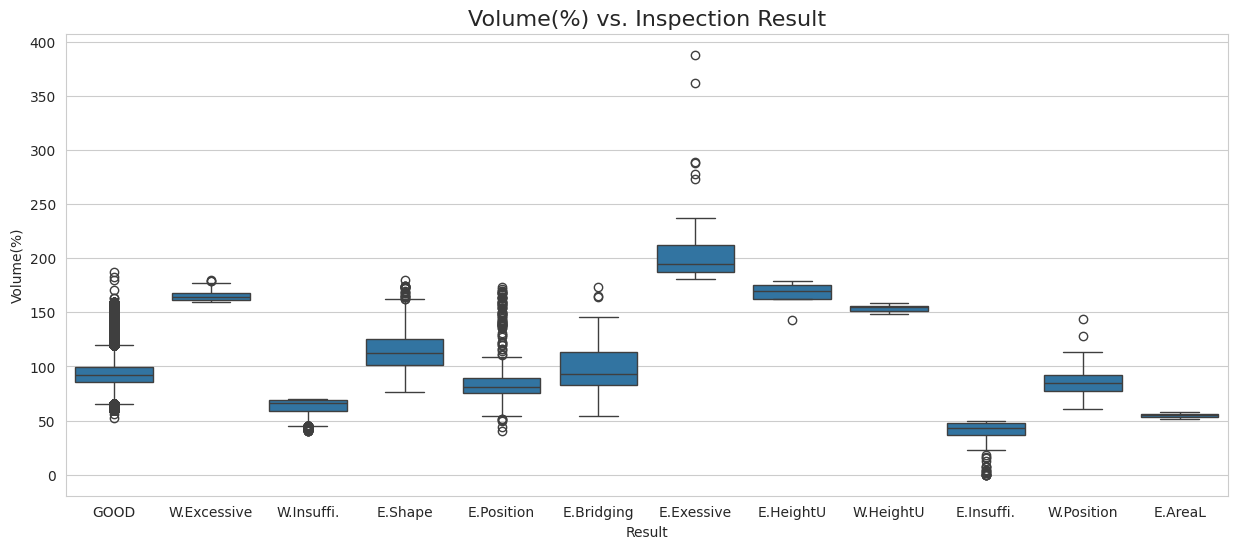

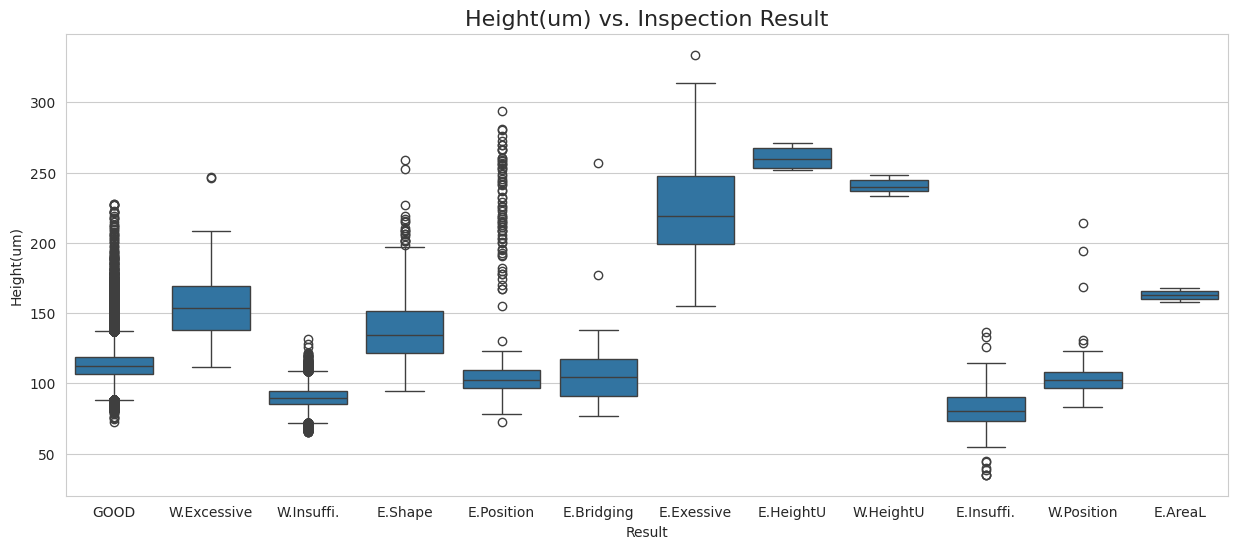

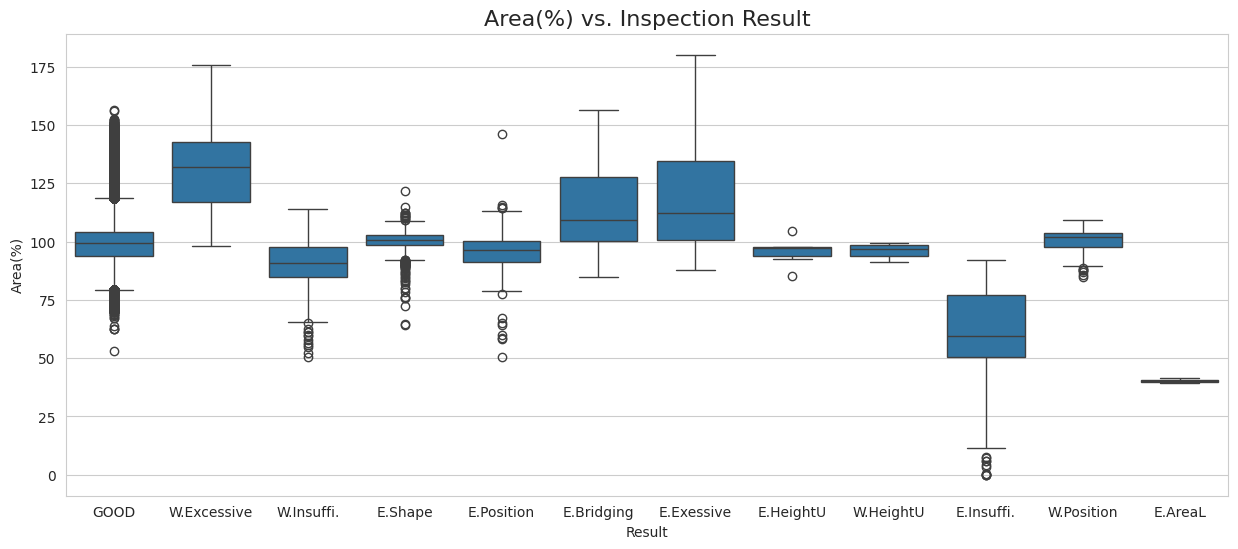

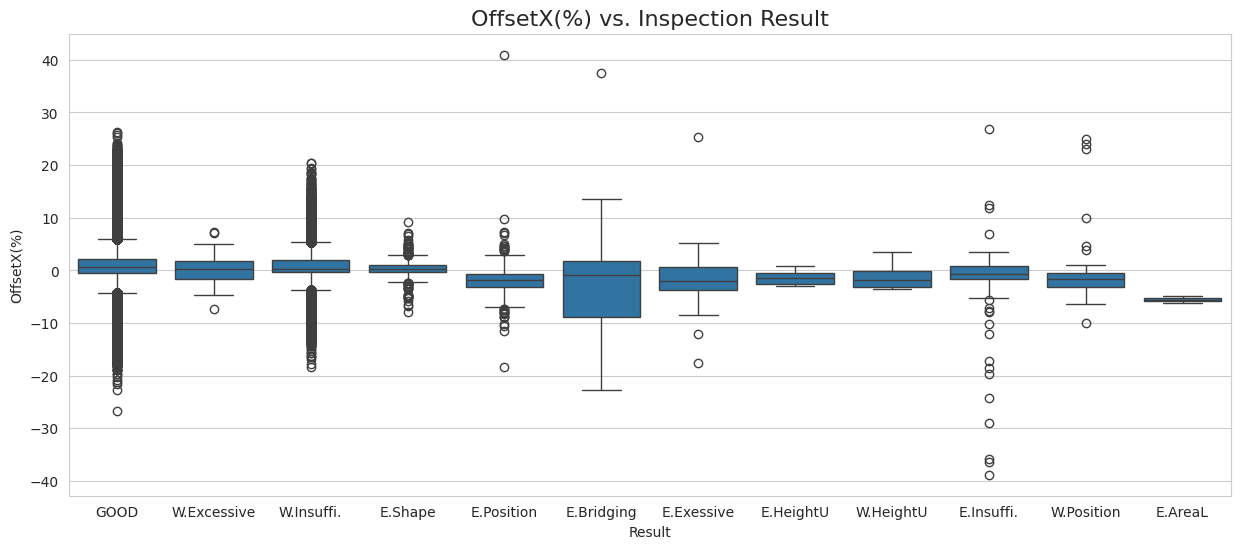

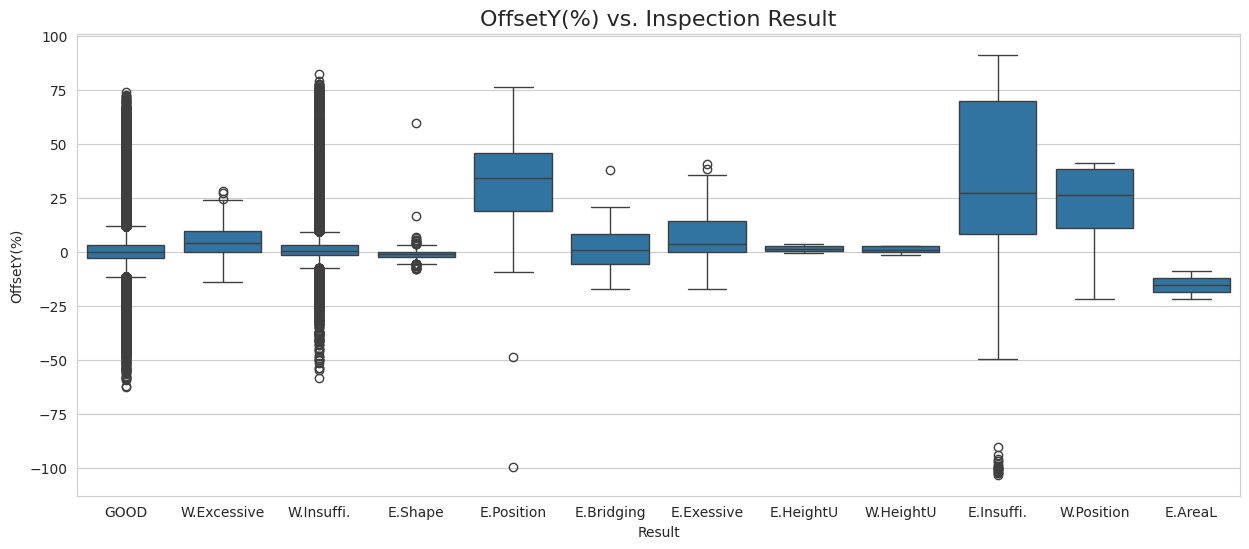

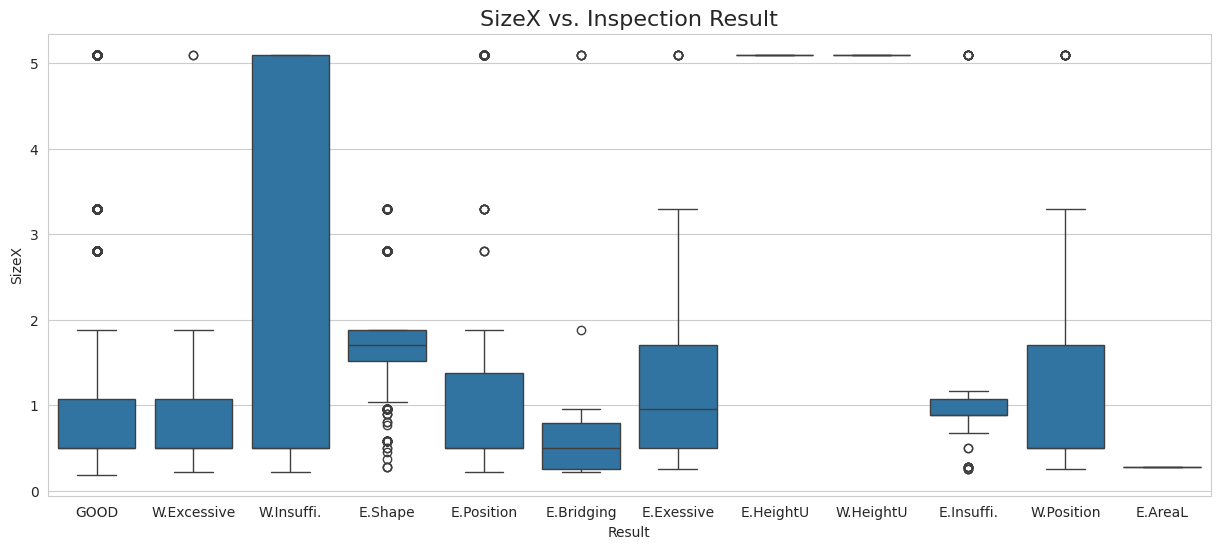

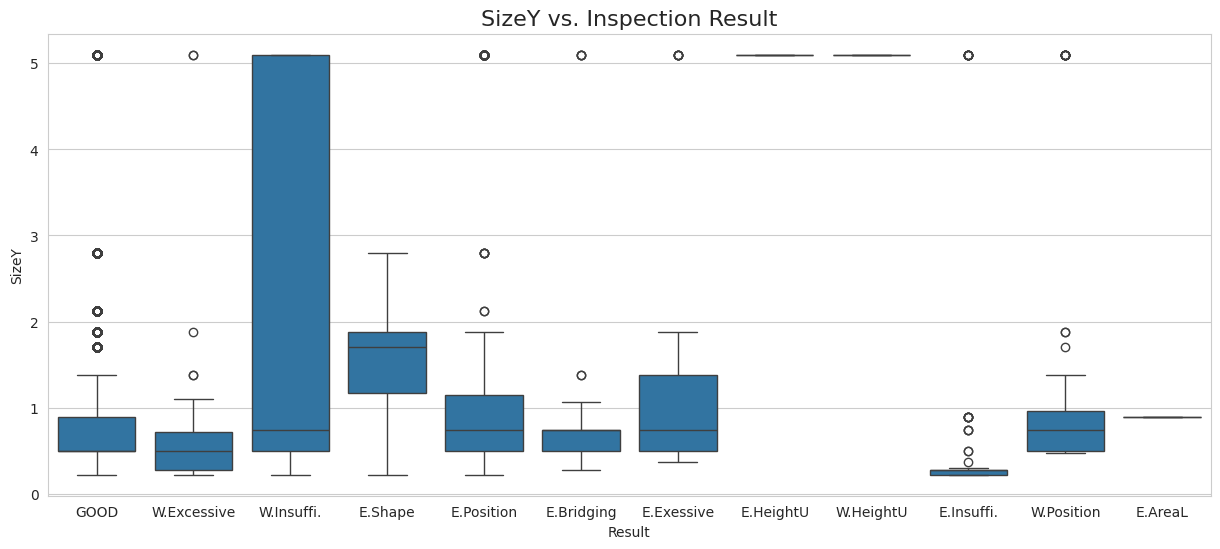

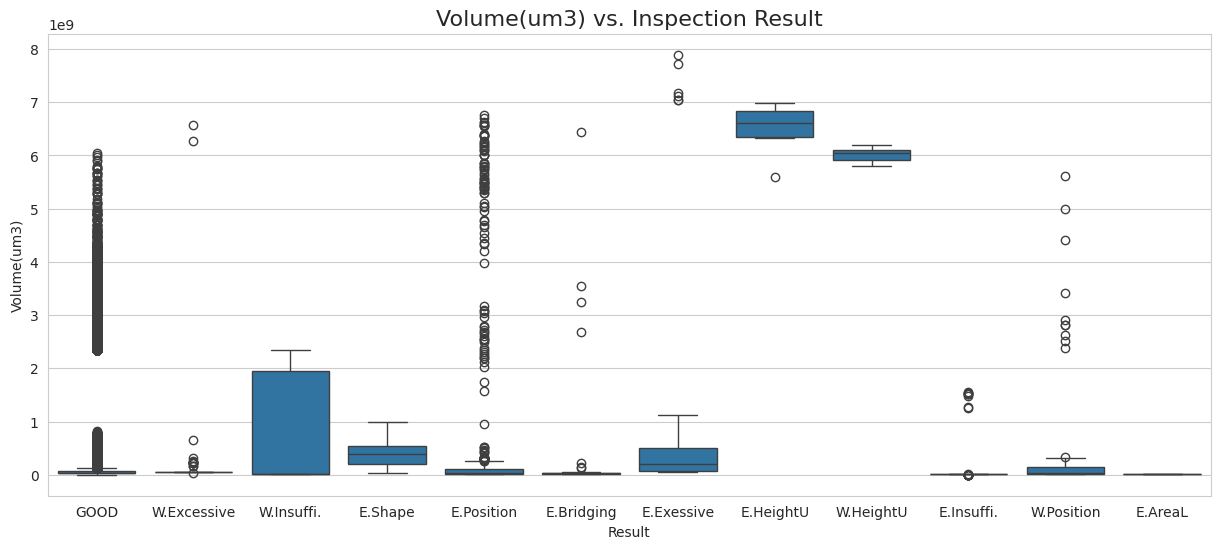

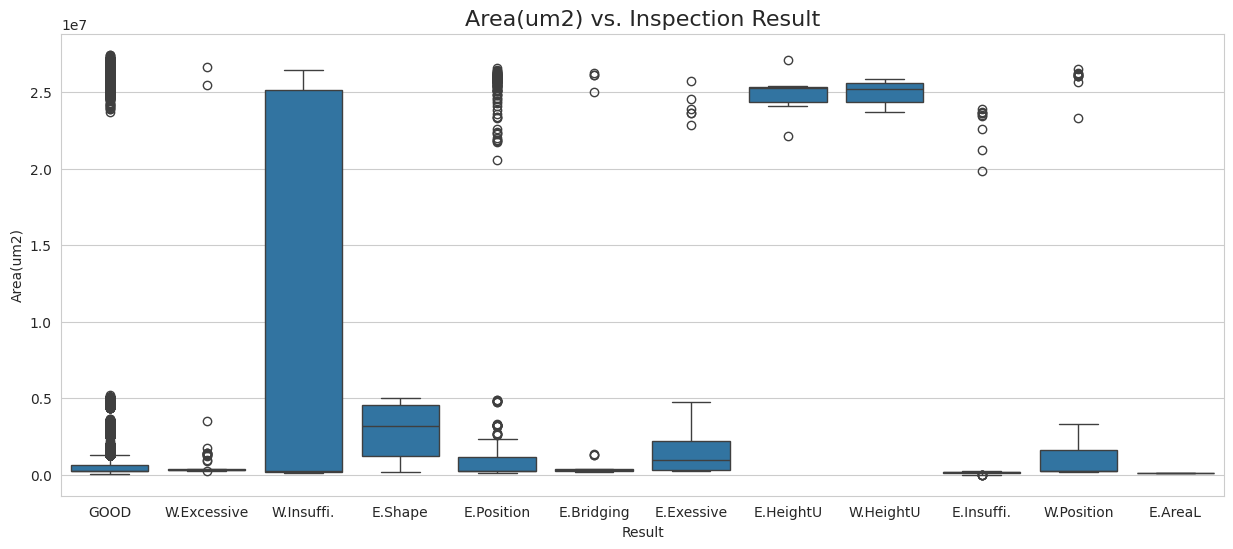

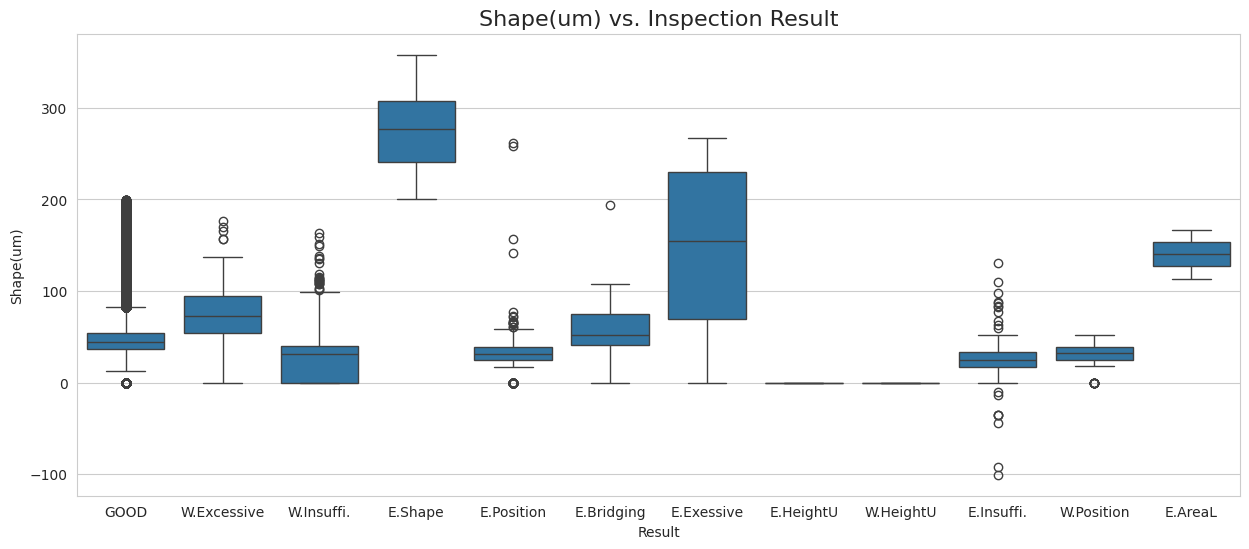

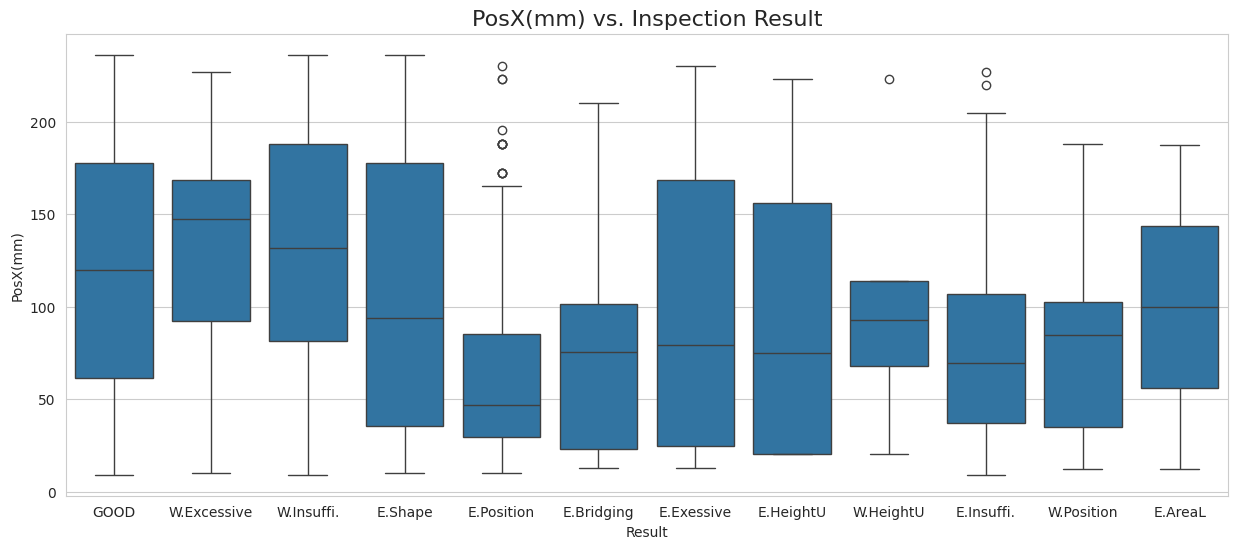

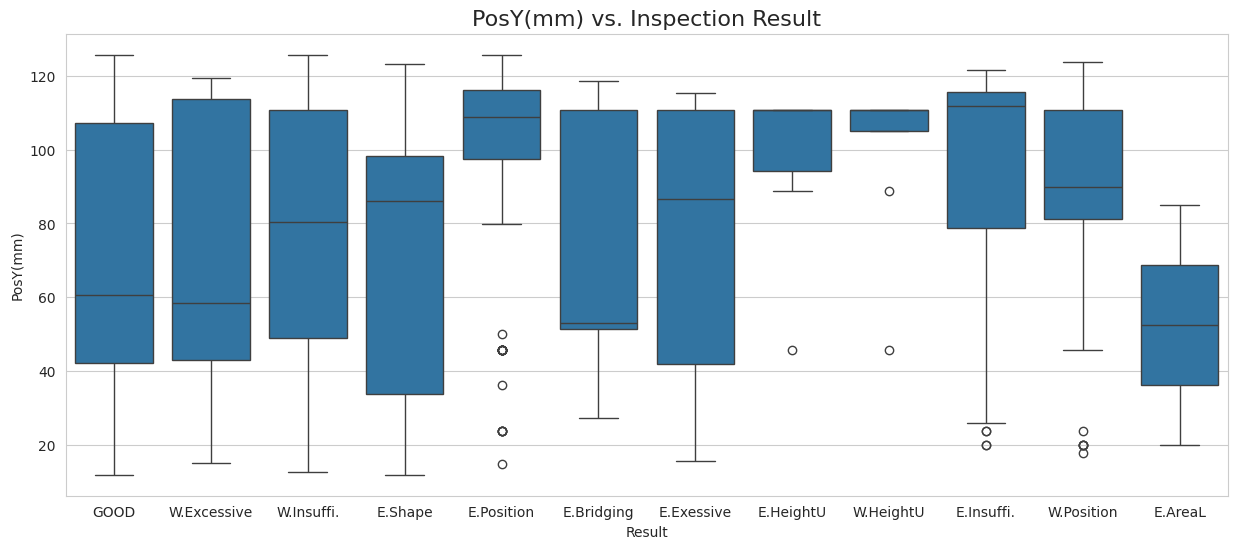

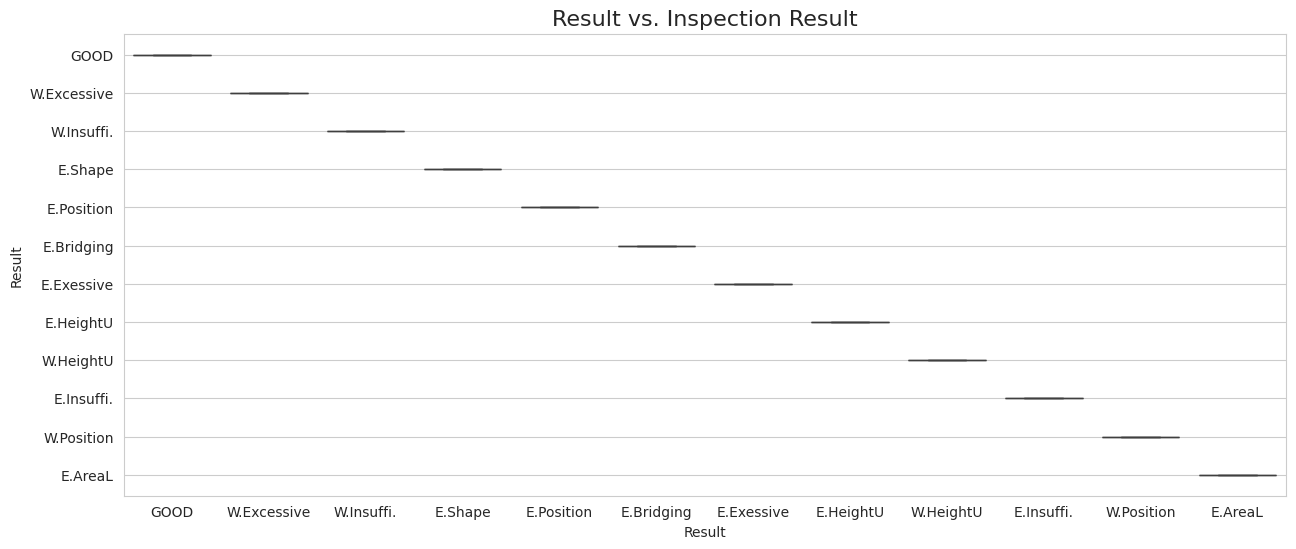

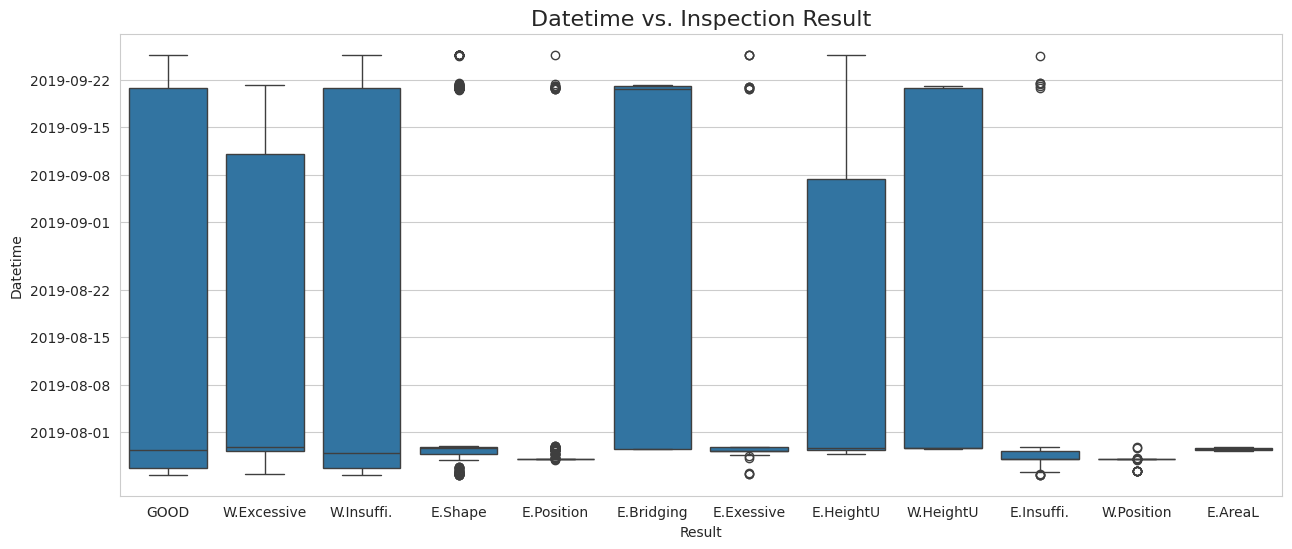

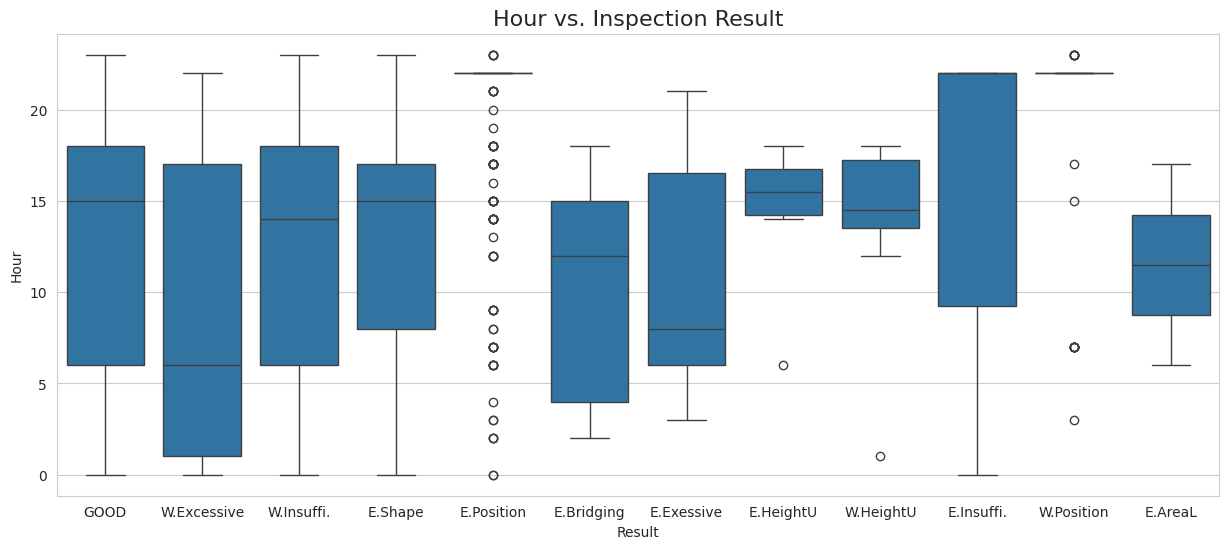

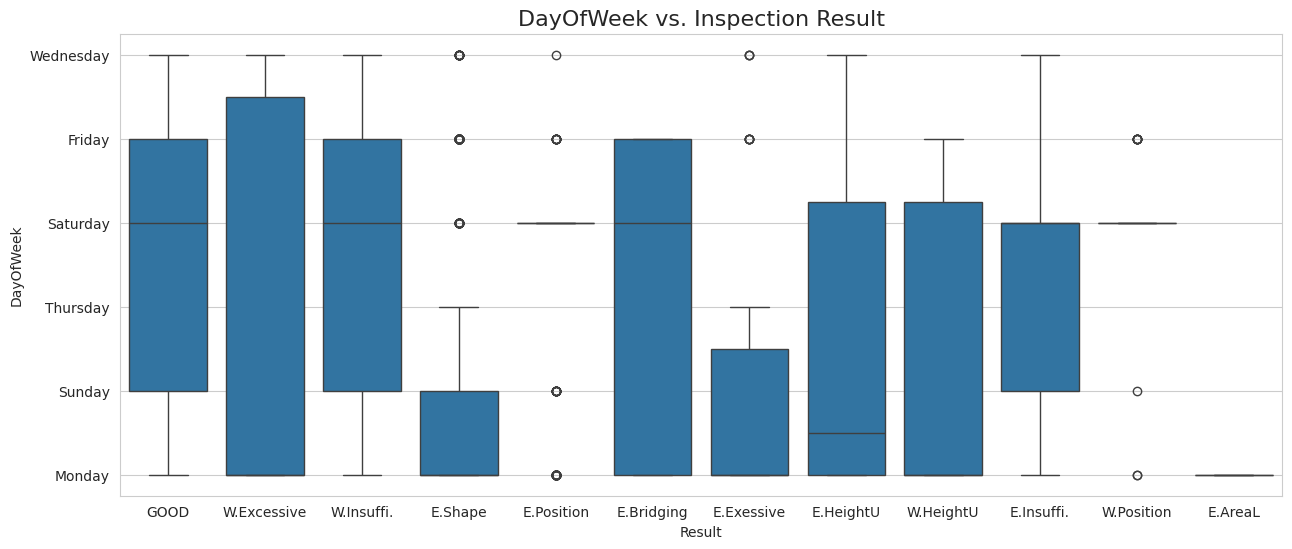

In [ ]:
sns.set_style("whitegrid")
merged_spi.reset_index(drop=True, inplace=True)
merged_spi['Shape(um)'] = pd.to_numeric(merged_spi['Shape(um)'], errors='coerce')
for col in merged_spi.columns[6:-2]:
  plt.figure(figsize=(15, 6))
  sns.boxplot(data=merged_spi, x='Result', y=col)
  plt.title(f'{col} vs. Inspection Result', fontsize=16)
  plt.show()

Analisis ini membuktikan bahwa fitur-fitur numerik yang ada tidak hanya berguna untuk membedakan antara "baik" dan "cacat", tetapi juga memiliki daya prediksi yang sangat kuat untuk mengklasifikasikan jenis cacat yang terjadi. Sebuah model machine learning dapat dilatih untuk mengenali karakteristik ini. Dengan demikian, sistem tidak hanya dapat menandai adanya cacat, tetapi juga secara otomatis mendiagnosis jenis masalahnya, yang merupakan langkah besar menuju otomatisasi proses kontrol kualitas.

Grafik berikutnya akan memvisualisasikan jumlah unit produk yang lolos inspeksi SPI (kategori 'GOOD') setiap minggunya, yang secara efektif merepresentasikan output bersih dari proses produksi.



Weekly Good Counts:
Datetime
2019-07-28    2891582
2019-08-04     659118
2019-08-11          0
2019-08-18          0
2019-08-25          0
Freq: W-SUN, dtype: int64


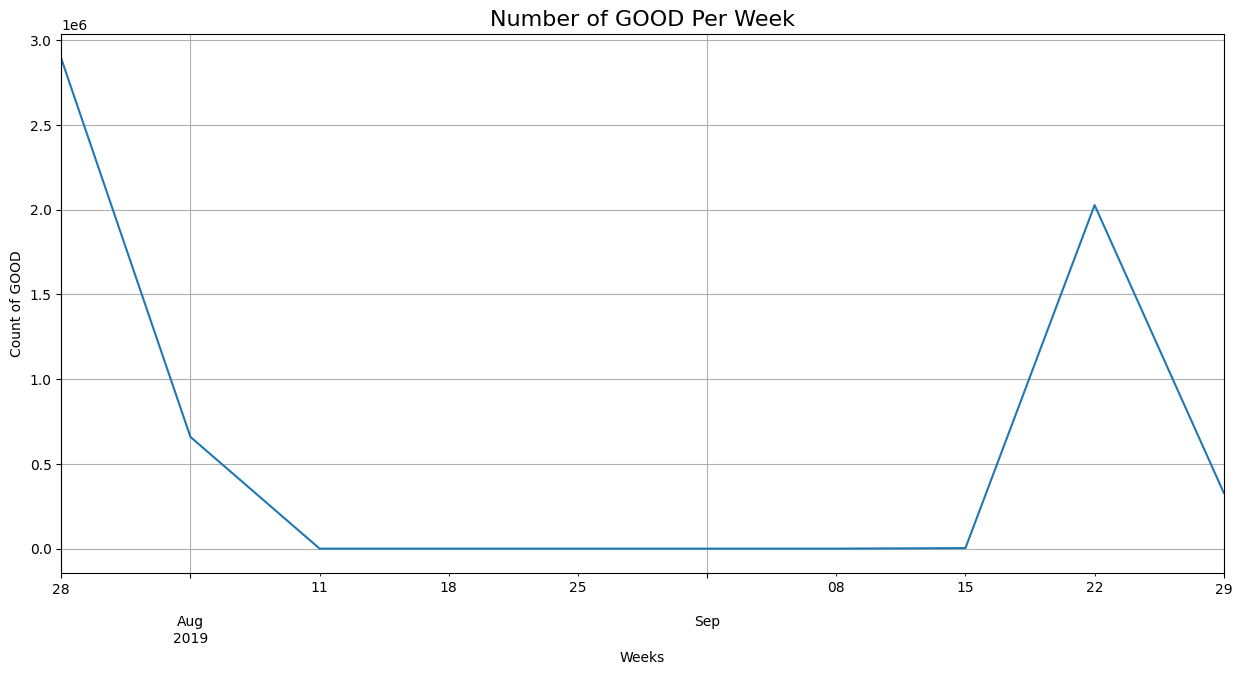

In [ ]:
temp_df = merged_spi[merged_spi['Result'] == 'GOOD'].copy()
weekly_good = temp_df.groupby(pd.Grouper(key='Datetime', freq='W')).size()
print("Weekly Good Counts:")
print(weekly_good.head())
plt.figure(figsize=(15, 7))
weekly_good.plot(kind='line', linestyle='-')
plt.title('Number of GOOD Per Week', fontsize=16)
plt.ylabel('Count of GOOD')
plt.xlabel('Weeks')
plt.grid(True)
plt.show()

* Wawasan utama dari plot ini adalah adanya volatilitas yang sangat tinggi pada throughput mingguan. Jumlah produk 'GOOD' bisa sangat bervariasi, dari di bawah 200.000 unit pada satu minggu hingga melonjak di atas 1,2 juta unit pada minggu lainnya.

* Fluktuasi yang tajam ini mengindikasikan bahwa stabilitas proses produksi menjadi sebuah tantangan. Minggu-minggu dengan throughput rendah bisa disebabkan oleh berbagai faktor, seperti permintaan yang menurun, jadwal libur atau perawatan mesin, atau bisa juga karena tingginya tingkat cacat pada minggu tersebut yang mengurangi jumlah produk 'GOOD'.



**Setelah melihat fluktuasi output produk 'GOOD', analisis selanjutnya akan membedah tren mingguan dari setiap jenis cacat secara individual. Tujuannya adalah untuk memahami dinamika masing-masing jenis kegagalan dan melihat apakah ada lonjakan insiden pada periode waktu tertentu, yang bisa mengindikasikan adanya masalah proses yang bersifat sementara.**

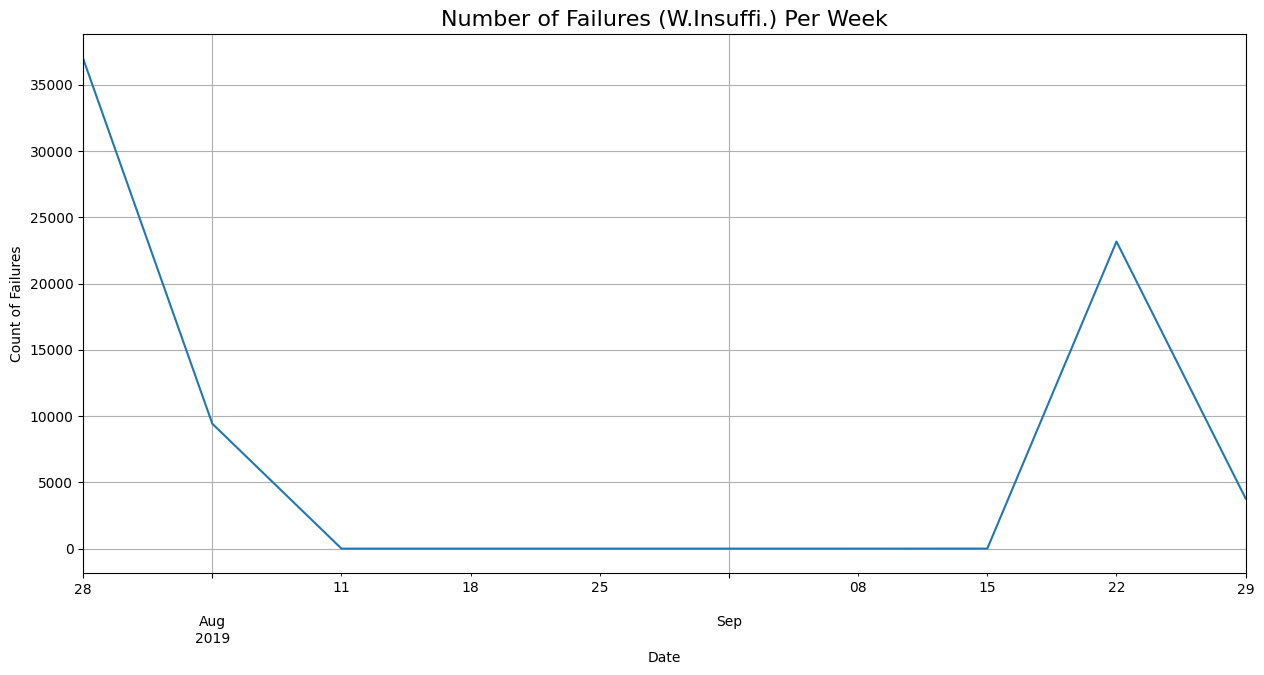

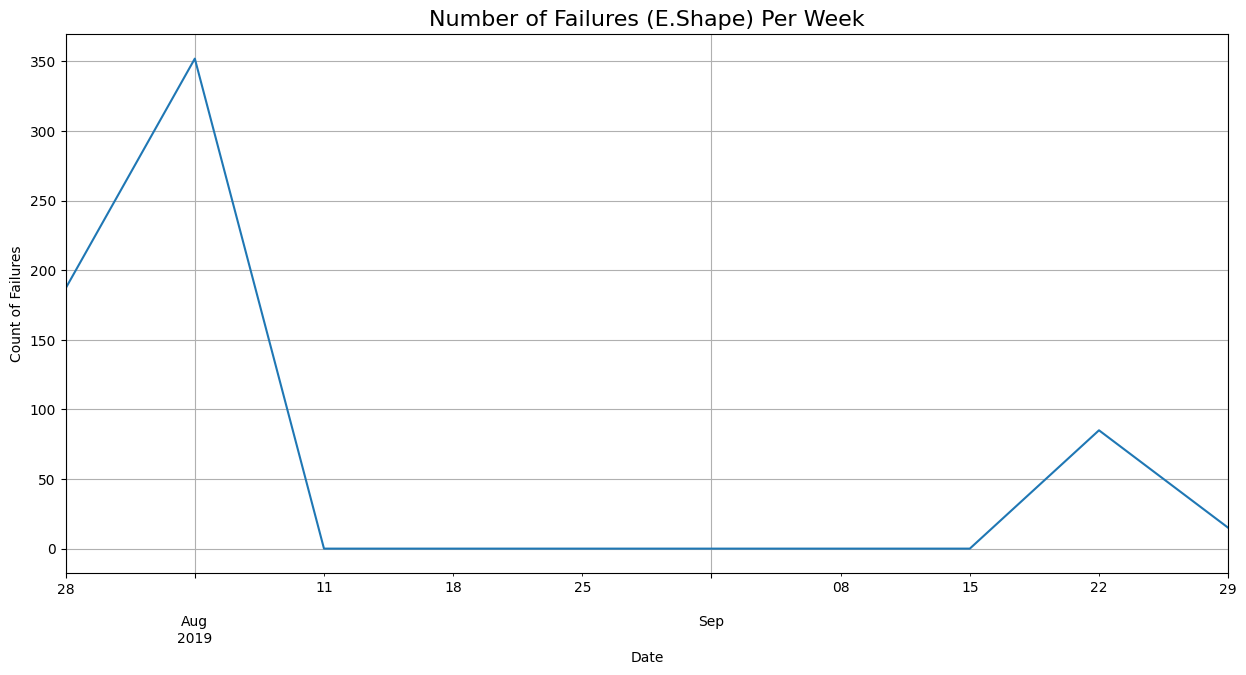

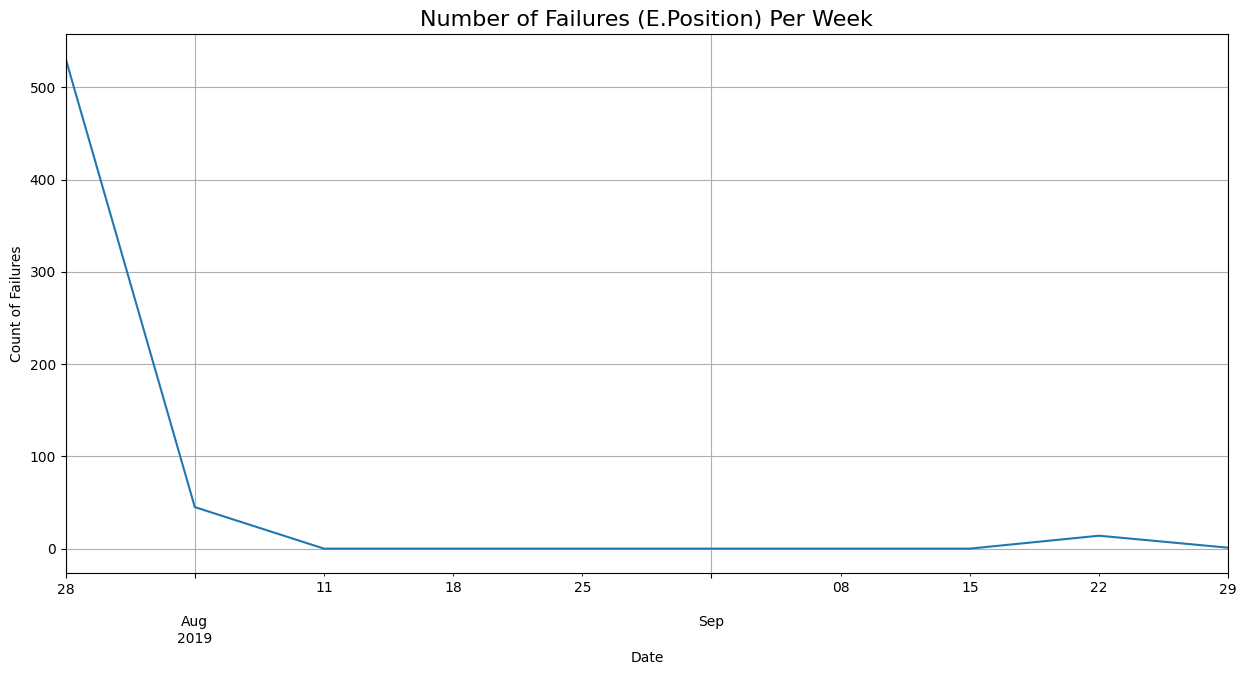

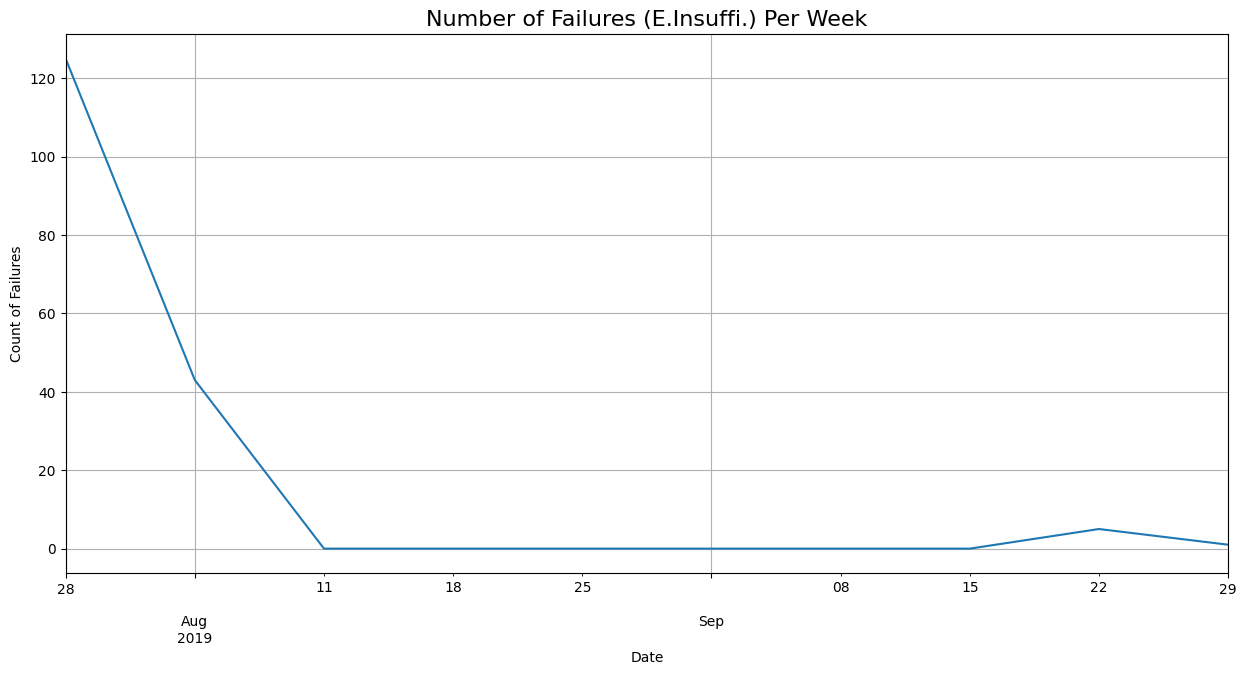

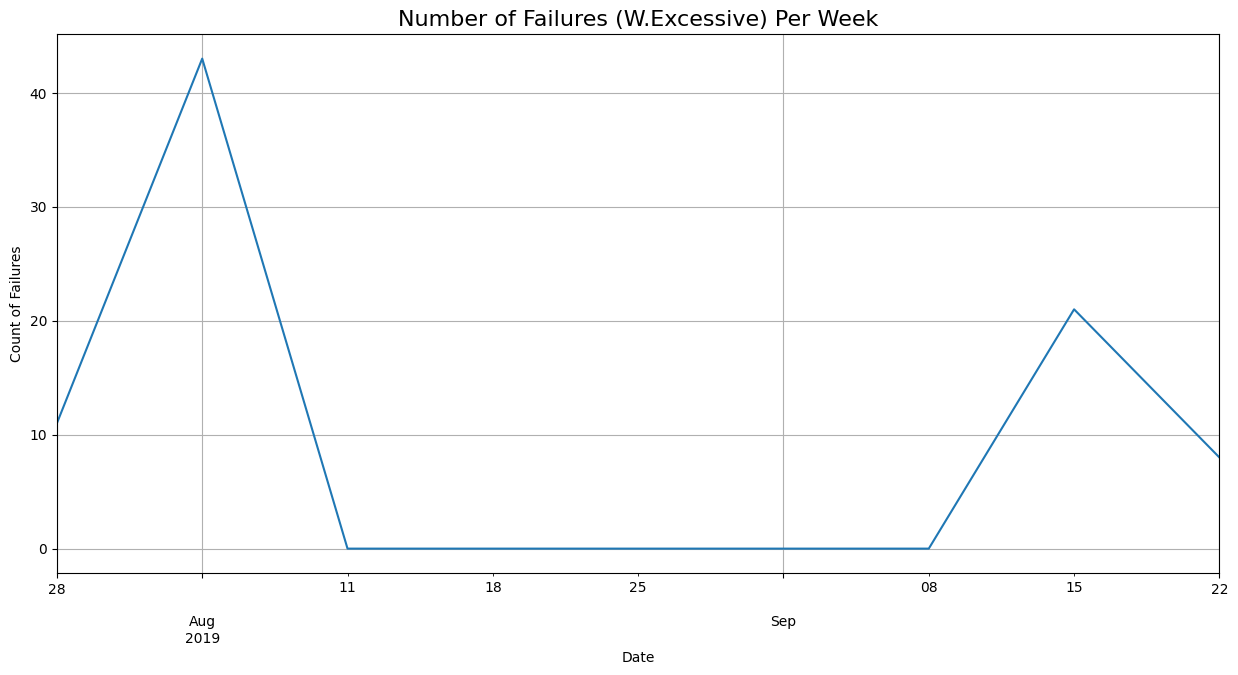

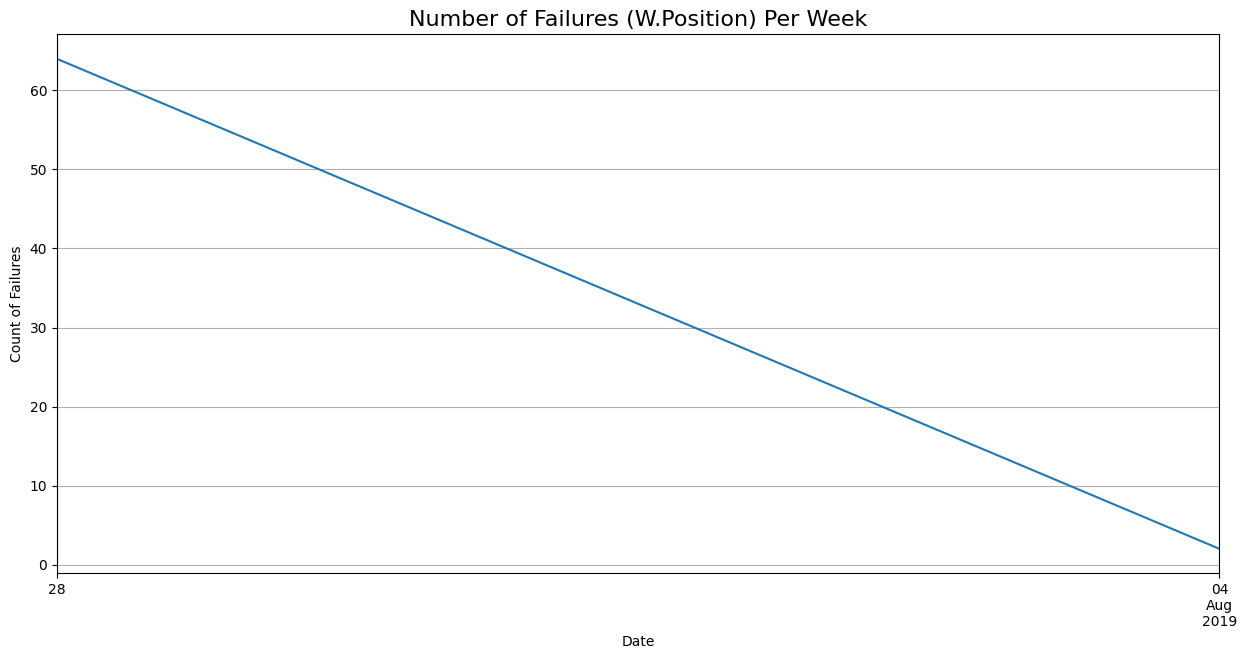

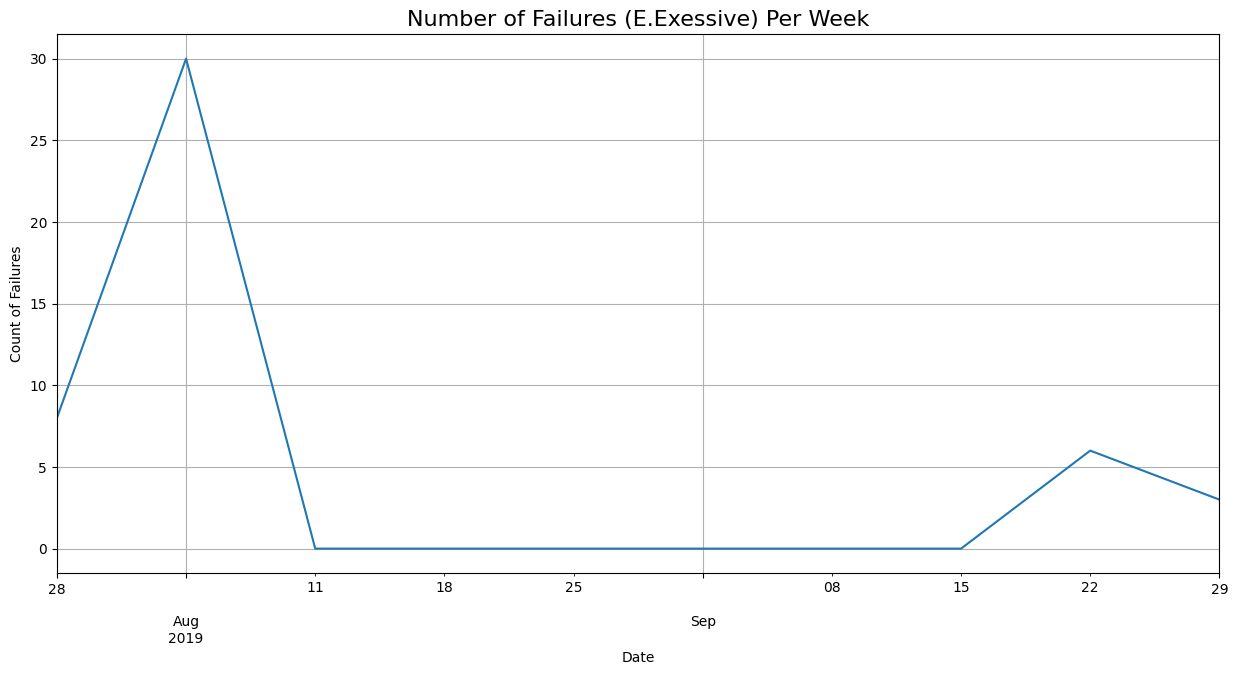

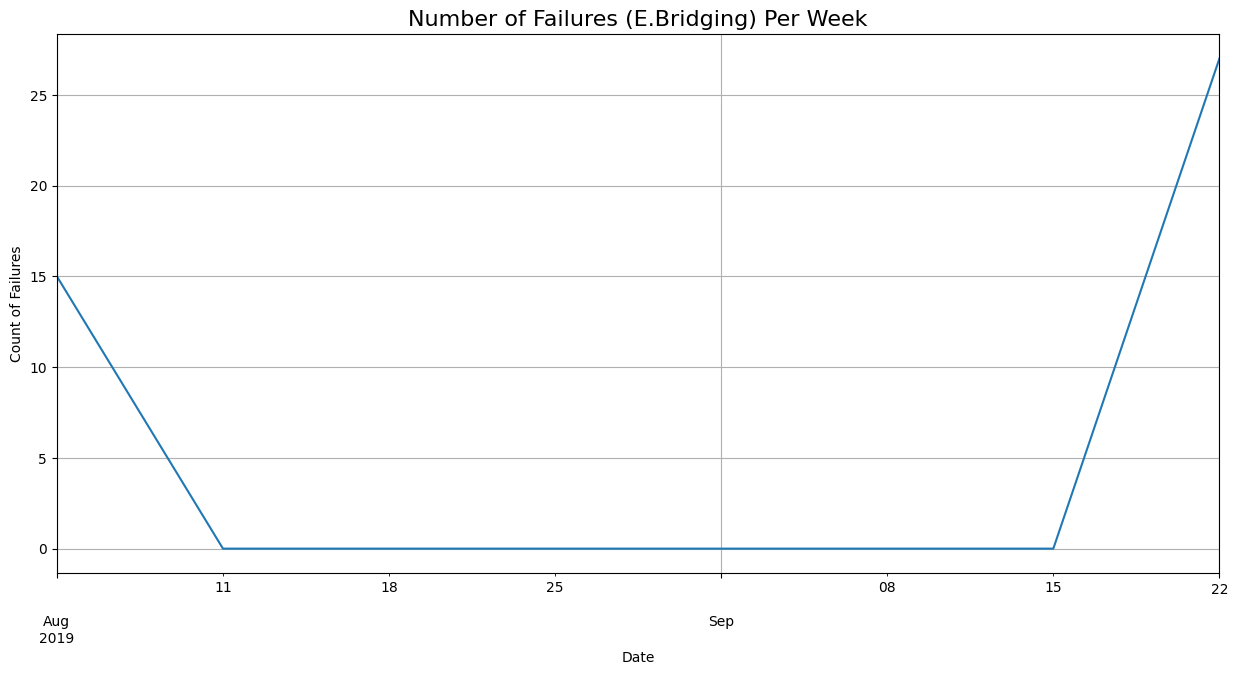

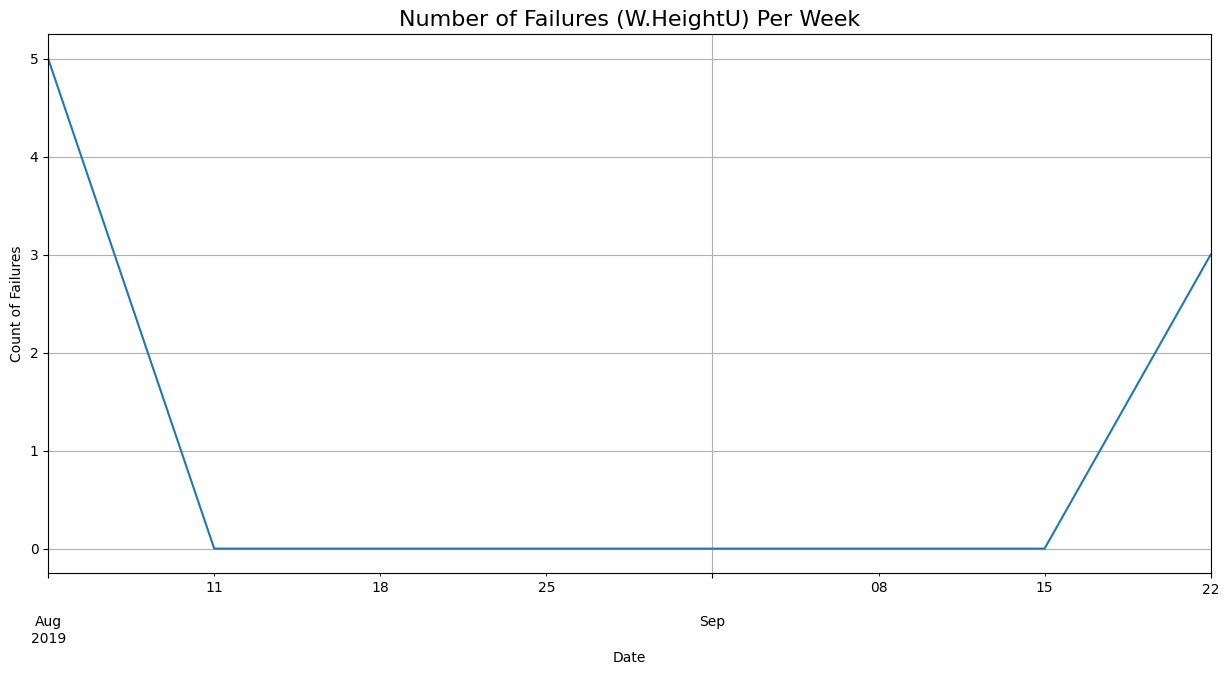

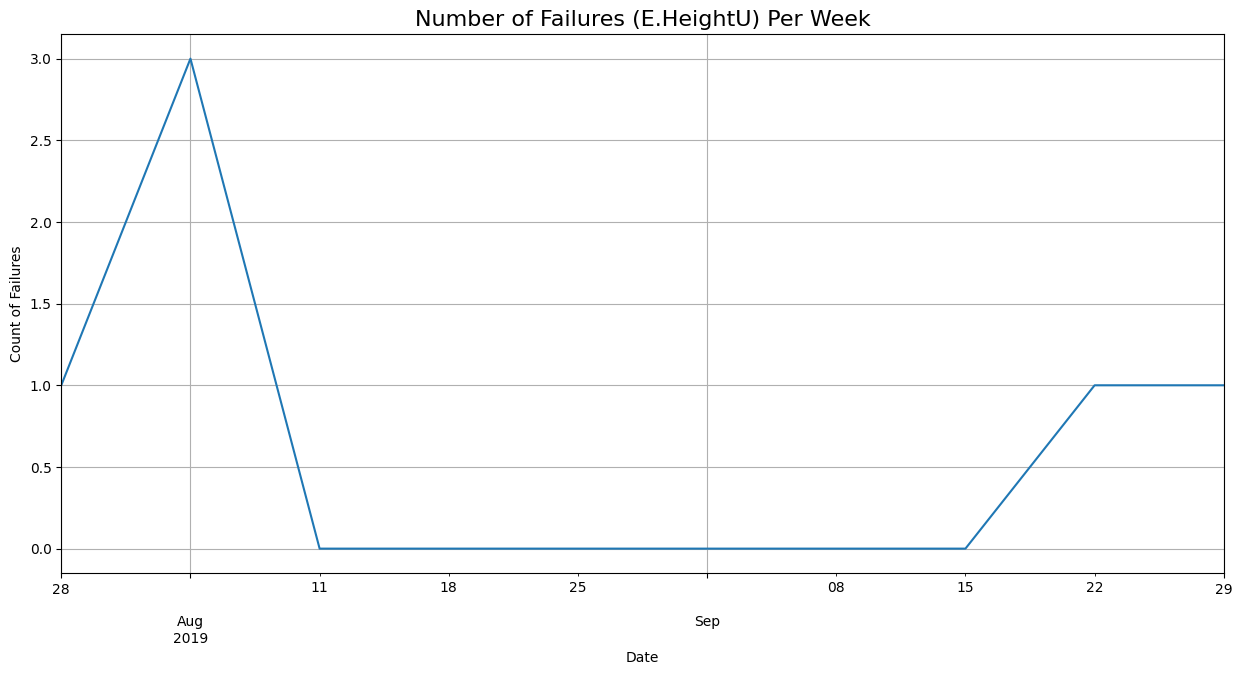

/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


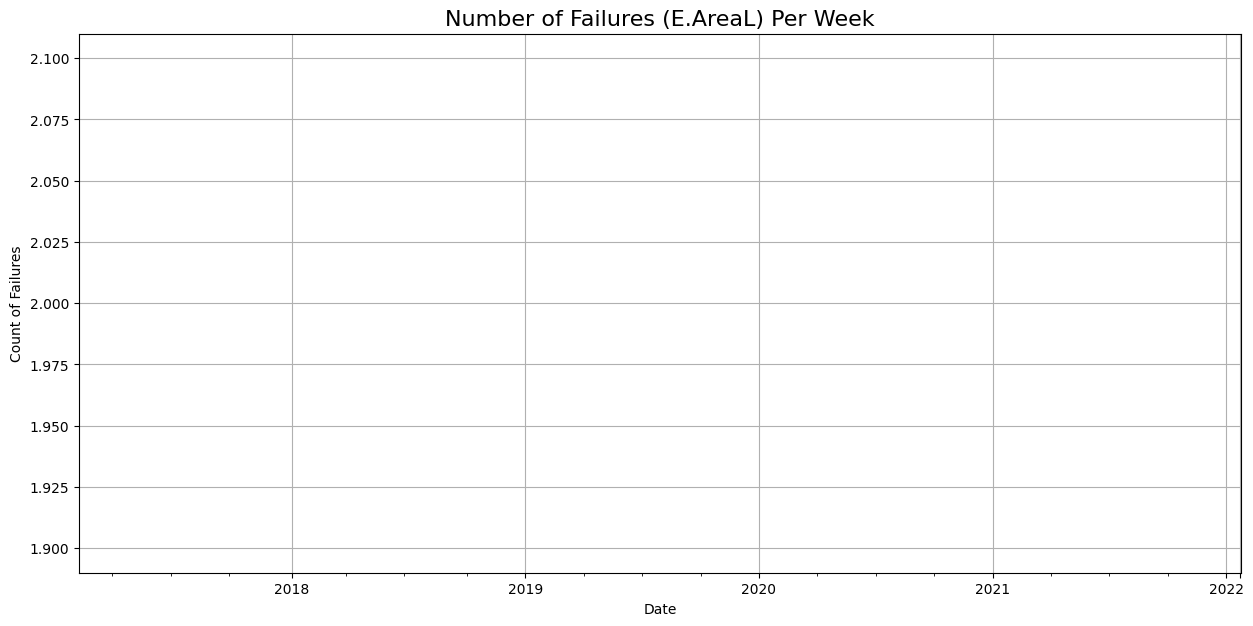

In [ ]:
catList = ['W.Insuffi.', 'E.Shape','E.Position', 'E.Insuffi.',
           'W.Excessive' , 'W.Position' , 'E.Exessive', 'E.Bridging', 'W.HeightU', 'E.HeightU',
           'E.AreaL']
for category in catList:
  temp_df = merged_spi[merged_spi['Result'] == category].copy()
  weekly_failures = temp_df.groupby(pd.Grouper(key='Datetime', freq='W')).size()
  plt.figure(figsize=(15, 7))
  weekly_failures.plot(kind='line', linestyle='-')
  plt.title(f'Number of Failures ({category}) Per Week', fontsize=16)
  plt.ylabel('Count of Failures')
  plt.xlabel('Date')
  plt.grid(True)
  plt.show()

* Informasi paling signifikan datang dari perbandingan tren W.Insuffi. (kekurangan solder) dan W.Excessive (kelebihan solder). Kedua jenis cacat ini, meskipun berlawanan, menunjukkan lonjakan besar pada periode waktu yang sama (sekitar awal September). Hal ini sangat mengindikasikan adanya masalah fundamental pada kontrol volume pasta solder selama minggu tersebut, yang menyebabkan proses menjadi tidak stabil dan menghasilkan kedua jenis cacat volume secara bersamaan.

* Sekelompok cacat lain, terutama yang berkaitan dengan bentuk dan ketinggian (E.Shape, E.Exessive, W.HeightU), menunjukkan lonjakan yang lebih kecil namun terjadi serempak pada periode yang berbeda (sekitar akhir Agustus).

Adanya lonjakan simultan pada beberapa jenis cacat menyiratkan adanya penyebab akar masalah yang sama (common root cause) pada periode waktu tersebut.

Adanya temuan lonjakan cacat pada periode waktu tertentu mendorong investigasi lebih lanjut terhadap sumber variabilitas lainnya. Selain variasi dari waktu ke waktu, penting juga untuk memeriksa konsistensi struktural dari unit ke unit. Analisis berikut ini bertujuan untuk memverifikasi apakah setiap panel yang diproduksi memiliki jumlah titik inspeksi yang sama, untuk mendeteksi adanya anomali pada level unit.

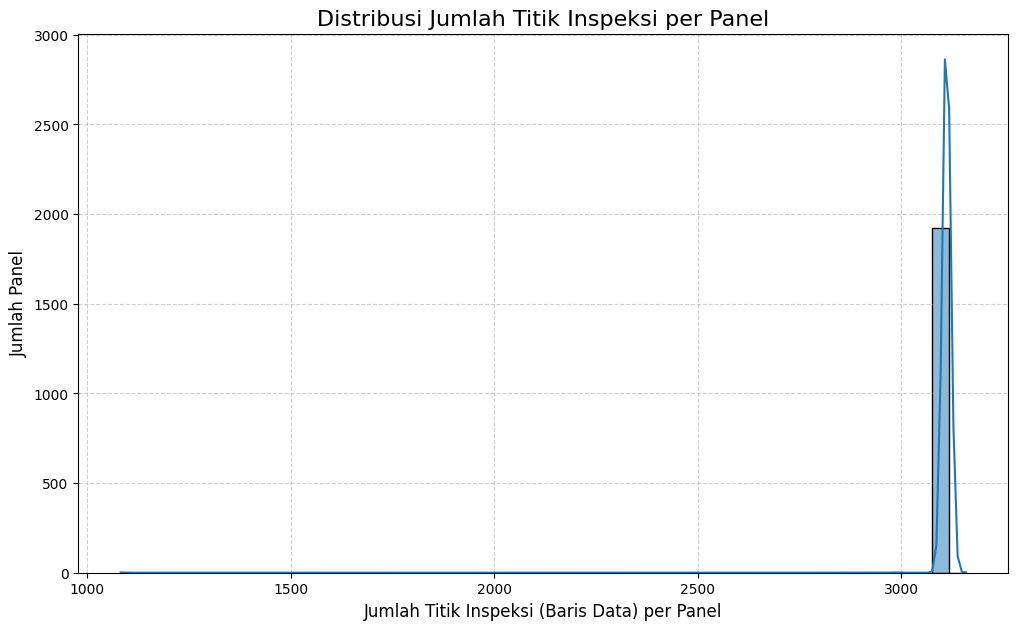

Statistik Jumlah Data per Panel:
count    1924.000000
mean     3110.904886
std        46.379708
min      1082.000000
25%      3112.000000
50%      3112.000000
75%      3112.000000
max      3160.000000
dtype: float64


In [ ]:
panel_data_counts = merged_spi.groupby("PanelID").size()
plt.figure(figsize=(12, 7))
sns.histplot(panel_data_counts, bins=50, kde=True)
plt.title('Distribusi Jumlah Titik Inspeksi per Panel', fontsize=16)
plt.xlabel('Jumlah Titik Inspeksi (Baris Data) per Panel', fontsize=12)
plt.ylabel('Jumlah Panel', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("Statistik Jumlah Data per Panel:")
print(panel_data_counts.describe())

* Proses manufaktur ini sangat stabil. Hal ini dibuktikan dengan fakta bahwa nilai persentil ke-25, ke-50 (median), dan ke-75 semuanya identik, yaitu 3,112 titik inspeksi per panel. Ini berarti mayoritas besar panel diproduksi dengan struktur yang sama persis.

* Meskipun sangat konsisten, analisis ini juga berhasil mengidentifikasi sejumlah kecil panel anomali. Terdapat panel dengan jumlah data yang jauh lebih sedikit (nilai min 1082) dan sedikit lebih banyak (nilai max 3160). Panel-panel inilah yang menjadi sumber "gangguan" atau variasi dalam dataset.

Analisis ini mengonfirmasi bahwa dataset secara umum memiliki integritas struktural yang tinggi. Adanya beberapa panel anomali dicatat sebagai temuan penting yang merefleksikan variasi proses di dunia nyata

## **Menganalisa File AOI Training**

---



Analisis ini bertujuan untuk memahami jenis-jenis cacat final yang terdeteksi dan mencari tahu apakah ada korelasi dengan temuan dari data SPI.



AOI Train Labels

PanelID -> Unique ID for the Panel that contains many PCB

FigureID -> Area / komponen yang sedang diinspeksi oleh Mesin AOI

MachineID -> ID for AOI Machine that does the inspection

ComponentID -> Unique ID for component sticked to the pad

PinNumber -> Nomor pin dari komponen yang sedang diperiksa koneksi soldernya.

AOILabel -> Hasil dari mesin AOI.

OperatorLabel -> Hasil verifikasi dari manusia (ground truth)

RepairLabel -> Status akhir setelah perbaikan

In [ ]:
aoi_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31617 entries, 0 to 31616
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PanelID        31617 non-null  object 
 1   FigureID       31617 non-null  int64  
 2   MachineID      31617 non-null  object 
 3   ComponentID    31617 non-null  object 
 4   PinNumber      22493 non-null  float64
 5   AOILabel       31617 non-null  object 
 6   OperatorLabel  31617 non-null  object 
 7   RepairLabel    1356 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 1.9+ MB


In [ ]:
aoi_train.isnull().sum()

PanelID              0
FigureID             0
MachineID            0
ComponentID          0
PinNumber         9124
AOILabel             0
OperatorLabel        0
RepairLabel      30261
dtype: int64

In [ ]:
categorical_cols = aoi_train.select_dtypes(['object']).columns
for col in aoi_train[categorical_cols]:
  print(f"{aoi_train[col].value_counts()}\n")

PanelID
27019026400520102844    203
26319055700520102844    109
27219031000520102844    107
26819000500520102844     51
27119005600520102844     43
                       ... 
26919005400520102844      4
27119016400520102844      4
26819008400520102844      3
27119018100520102844      3
26919039000520102844      2
Name: count, Length: 1924, dtype: int64

MachineID
A    20879
B    10738
Name: count, dtype: int64

ComponentID
BC1    9321
L2     2043
C8     1854
C9     1242
C31    1198
       ... 
L3        5
C23       4
C18       3
C35       3
C20       2
Name: count, Length: 102, dtype: int64

AOILabel
Soldered         9412
UnSoldered       6218
Coplanarity      5336
Translated       3132
LeanSoldering    2772
Size             1952
Misaligned       1639
Missing           977
Broken            109
Jumper             46
Polarity           24
Name: count, dtype: int64

OperatorLabel
Good    30261
Bad      1356
Name: count, dtype: int64

RepairLabel
NotPossibleToRepair    995
NotYetClassifi

Hasil Analisis:
* Konsisten dengan data SPI, BC1 kembali muncul sebagai salah satu komponen yang paling sering diinspeksi. Ini memperkuat dugaan bahwa komponen ini memang diproduksi dalam volume tinggi.

* Banyak cacat yang terdeteksi di tahap AOI sudah bersifat fatal dan tidak dapat diperbaiki, yang berujung pada kerugian material dan biaya.

Setelah analisis awal, ditemukan beberapa anomali pada data AOI yang memerlukan investigasi lebih lanjut. Sebuah hipotesis muncul: Apakah mungkin satu komponen yang sama diinspeksi lebih dari satu kali, yang berpotensi menyebabkan adanya beberapa label cacat yang berbeda untuk lokasi yang sama?

In [ ]:
specific_case = aoi_train.loc[(aoi_train['PanelID']=="26319055700520102844") &
                              (aoi_train["FigureID"]==1) &
                              (aoi_train["MachineID"]=="A") &
                              (aoi_train["ComponentID"]=="U3")]

print("Contoh Kasus: Beberapa Label Cacat untuk Komponen yang Sama")
display(specific_case.sort_values(['PinNumber']))

Contoh Kasus: Beberapa Label Cacat untuk Komponen yang Sama


PanelID  FigureID MachineID ComponentID  PinNumber     AOILabel OperatorLabel          RepairLabel
4174  26319055700520102844         1         A          U3        1.0   Translated           Bad  NotPossibleToRepair
4212  26319055700520102844         1         A          U3        1.0     Soldered           Bad  NotPossibleToRepair
4211  26319055700520102844         1         A          U3        2.0     Soldered           Bad  NotPossibleToRepair
4173  26319055700520102844         1         A          U3        2.0   Translated           Bad  NotPossibleToRepair
4230  26319055700520102844         1         A          U3        2.0  Coplanarity           Bad  NotPossibleToRepair
...                    ...       ...       ...         ...        ...          ...           ...                  ...
4218  26319055700520102844         1         A          U3       47.0     Soldered           Bad  NotPossibleToRepair
4217  26319055700520102844         1         A          U3       48.0     Soldered           Bad  NotPossibleToRepair
4175  26319055700520102844         1         A          U3       48.0   Translated           Bad  NotPossibleToRepair
4075  26319055700520102844         1         A          U3        NaN  Coplanarity           Bad  NotPossibleToRepair
4078  26319055700520102844         1         A          U3        NaN         Size           Bad  NotPossibleToRepair

[90 rows x 8 columns]

Observasi terhadap data tersebut adalah komponen maupun pin tidak bersifat unik. Sebagai contoh, PinNumber 2.0 pada komponen U3 memiliki tiga cacat dengan label yang berbeda-beda, yaitu Soldered, Translated, dan Coplanarity.

Temuan ini memunculkan pertanyaan kritis: bagaimana satu pin yang sama bisa memiliki tiga kondisi cacat yang berbeda? Ini mengindikasikan adanya duplikasi atau pencatatan data berlapis untuk satu entitas fisik yang sama.

Salah satu hipotesis yang paling mungkin adalah bahwa panel yang sama dilewatkan pada dua mesin AOI yang berbeda (Mesin A dan Mesin B), sehingga menghasilkan dua set data inspeksi yang terpisah. Untuk menguji kelayakan hipotesis ini, kita periksa panel mana saja yang diinspeksi oleh masing-masing mesin.

In [ ]:
panel_per_machine = aoi_train.loc[:, ['PanelID', 'MachineID']].drop_duplicates().groupby(['MachineID']).size()

print("Jumlah Panel Unik per Mesin:")
print(panel_per_machine)

Jumlah Panel Unik per Mesin:
MachineID
A    1924
B    1884
dtype: int64


Hasil analisis menunjukkan bahwa dari total panel yang ada, 1884 panel diinspeksi oleh Mesin B, dan 1924 panel diinspeksi oleh Mesin A. Fakta bahwa sebagian besar panel (1884 panel) tercatat di kedua mesin secara kuat mendukung hipotesis bahwa panel-panel tersebut memang melewati kedua lini inspeksi. Terdapat 40 panel yang tampaknya hanya diinspeksi oleh Mesin A.

In [ ]:
cols_to_exclude = ['AOILabel', 'OperatorLabel', 'RepairLabel', 'MachineID', 'MachinePrediction']
location_identifiers = [col for col in aoi_train.columns if col not in cols_to_exclude]
inspeksi_ganda_test = aoi_train.loc[:, location_identifiers].drop_duplicates()
final_test = inspeksi_ganda_test.groupby(['PanelID', 'FigureID', 'ComponentID', 'PinNumber']).size()

print(f"Ditemukan {len(final_test[final_test > 1])} lokasi pin yang diinspeksi lebih dari satu kali.")

Ditemukan 0 lokasi pin yang diinspeksi lebih dari satu kali.


Sebuah observasi awal menunjukkan adanya beberapa baris data dengan AOILabel yang berbeda untuk ComponentID dan PinNumber yang identik. Awalnya, ini memunculkan hipotesis adanya inspeksi ganda oleh mesin yang berbeda.

Namun, setelah dilakukan pengujian dengan mengisolasi identifier lokasi fisik, terbukti bahwa tidak ada satu pun lokasi pin yang diinspeksi lebih dari satu kali.

Anomali ini bukan disebabkan oleh duplikasi data, melainkan oleh kapabilitas sistem AOI untuk mendeteksi dan mencatat beberapa jenis cacat yang berbeda secara simultan untuk satu pin tunggal.

Pemahaman ini krusial karena menunjukkan bahwa beberapa mode kegagalan dapat terjadi secara bersamaan (co-occurring), yang membuka peluang untuk analisis co-occurrence, mencari tahu jenis cacat mana yang cenderung muncul bersamaan.

Analisis Co-Occurence

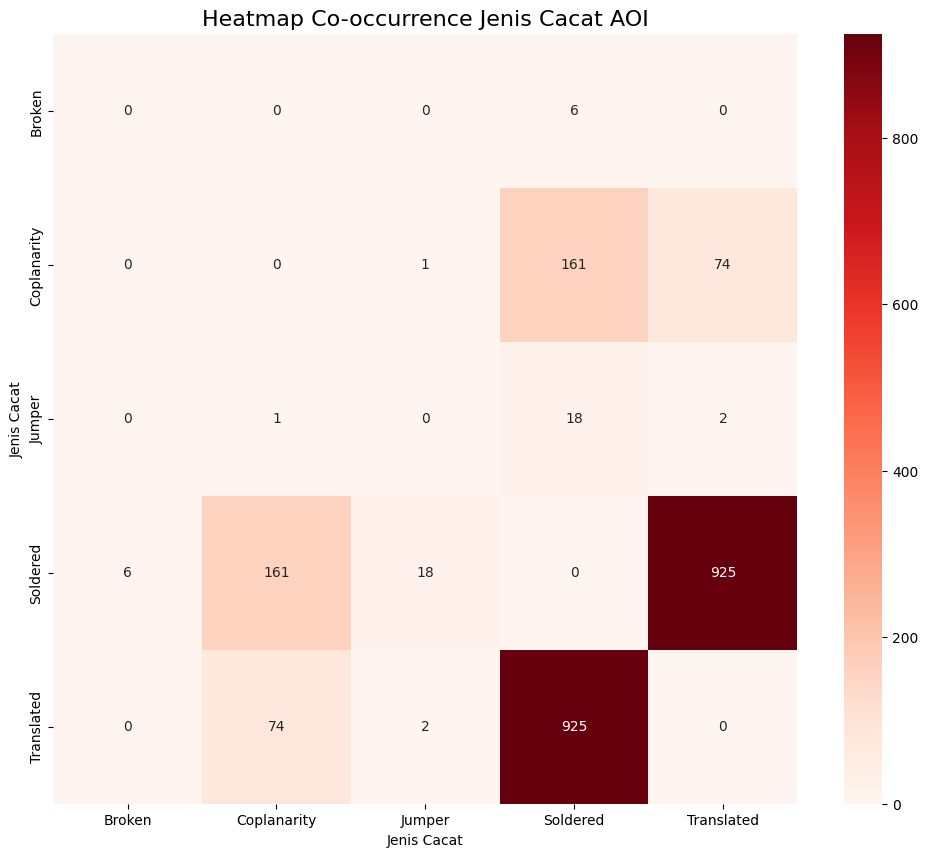

Top 10 Pasangan Cacat yang Paling Sering Muncul Bersamaan:
[(('Soldered', 'Translated'), 925), (('Coplanarity', 'Soldered'), 161), (('Coplanarity', 'Translated'), 74), (('Jumper', 'Soldered'), 18), (('Broken', 'Soldered'), 6), (('Jumper', 'Translated'), 2), (('Coplanarity', 'Jumper'), 1)]


In [ ]:
location_cols = ['PanelID', 'FigureID', 'ComponentID', 'PinNumber']
defect_counts_per_pin = aoi_train.groupby(location_cols).size()
multi_defect_pins = defect_counts_per_pin[defect_counts_per_pin > 1].index
df_multi_defect = aoi_train[aoi_train.set_index(location_cols).index.isin(multi_defect_pins)]
defect_groups = df_multi_defect.groupby(location_cols)['AOILabel'].apply(list).values.tolist()

co_occurrence_counts = Counter()
for group in defect_groups:
    for pair in combinations(sorted(list(set(group))), 2):
        co_occurrence_counts[pair] += 1

all_items = sorted(list(set(item for group in defect_groups for item in group)))
co_occurrence_matrix = pd.DataFrame(0, index=all_items, columns=all_items)

for pair, count in co_occurrence_counts.items():
    co_occurrence_matrix.loc[pair[0], pair[1]] = count
    co_occurrence_matrix.loc[pair[1], pair[0]] = count
plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence_matrix, annot=True, fmt='d', cmap='Reds')
plt.title('Heatmap Co-occurrence Jenis Cacat AOI', fontsize=16)
plt.xlabel('Jenis Cacat')
plt.ylabel('Jenis Cacat')
plt.show()


print("Top 10 Pasangan Cacat yang Paling Sering Muncul Bersamaan:")
print(co_occurrence_counts.most_common(10))

Heatmap dan daftar pasangan cacat yang muncul bersamaan secara definitif menunjukkan adanya hubungan yang sangat kuat antara beberapa jenis cacat, sementara yang lainnya cenderung terjadi secara terisolasi.

* Translated + Soldered
Pasangan cacat yang paling sering muncul bersamaan, dengan selisih yang sangat jauh dari yang lain, adalah Translated (Pergeseran Posisi) dan Soldered (Masalah Penyolderan), yang terjadi bersamaan sebanyak 925 kali.

Interpretasi dan kesimpulan:
* Akar masalah utama kemungkinan besar adalah pergeseran posisi komponen (Translated).
* Ketika sebuah komponen bergeser, sangat mungkin kaki-kakinya menjadi tidak rata atau miring (Coplanarity).
* Posisi yang bergeser dan tidak rata ini kemudian hampir pasti akan menyebabkan masalah pada proses penyolderan (Soldered).



Distribusi Fitur Kategorikal

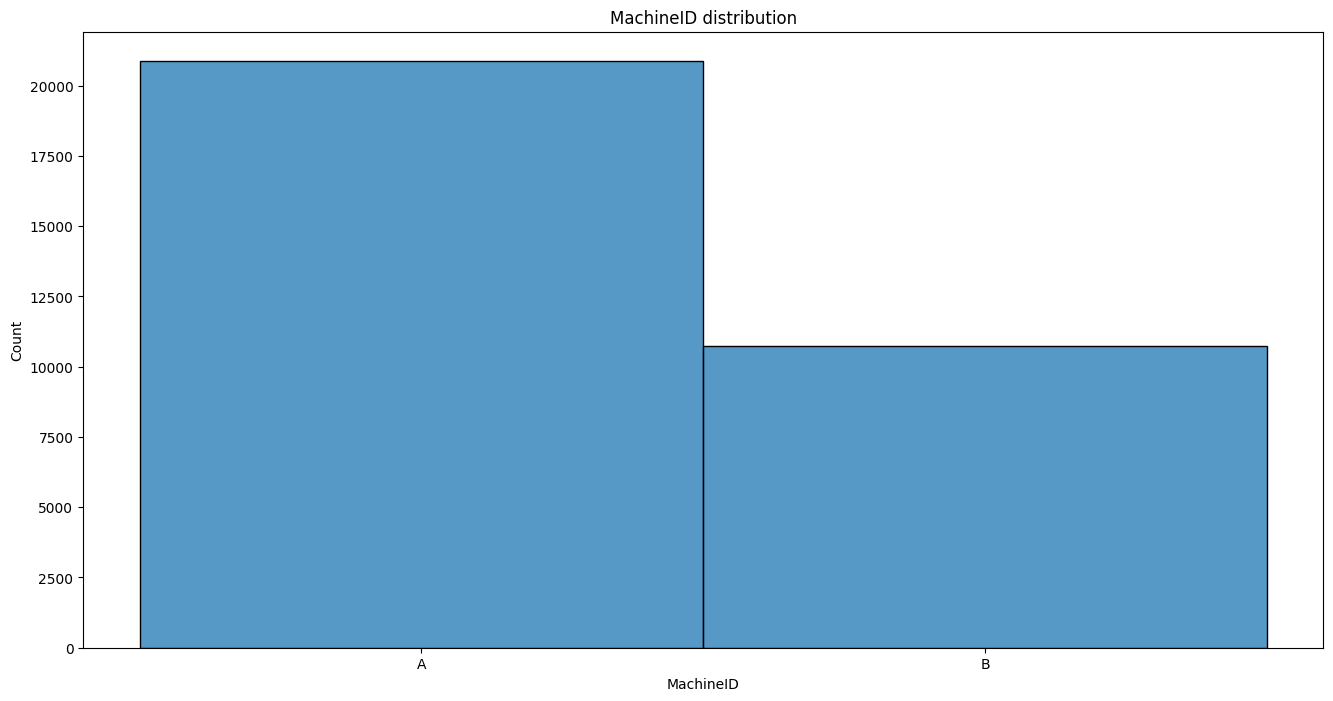

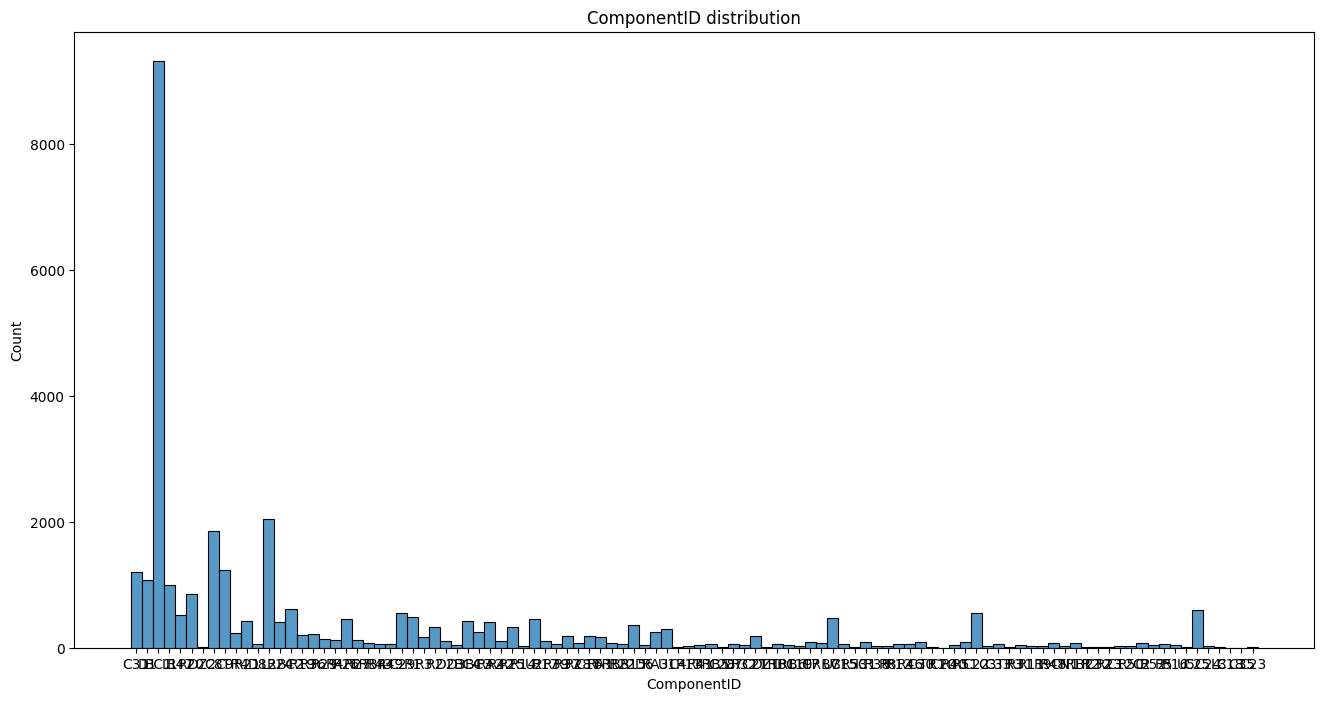

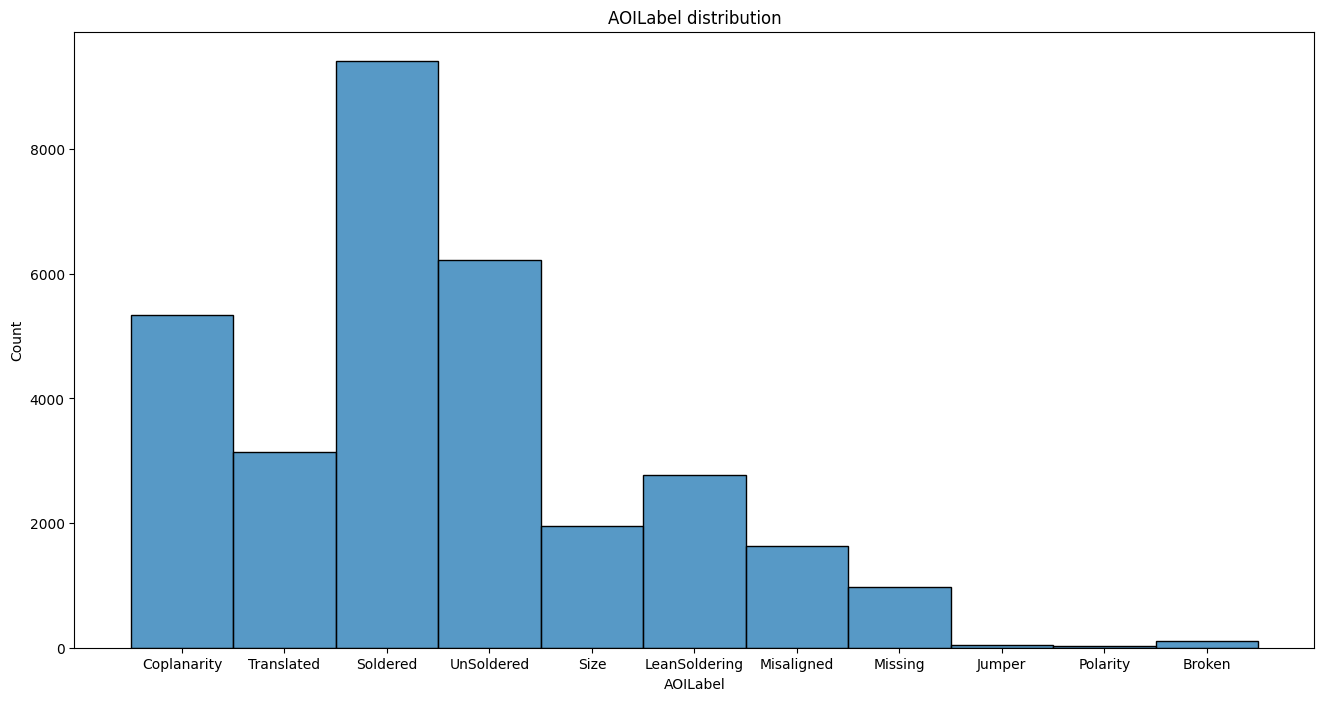

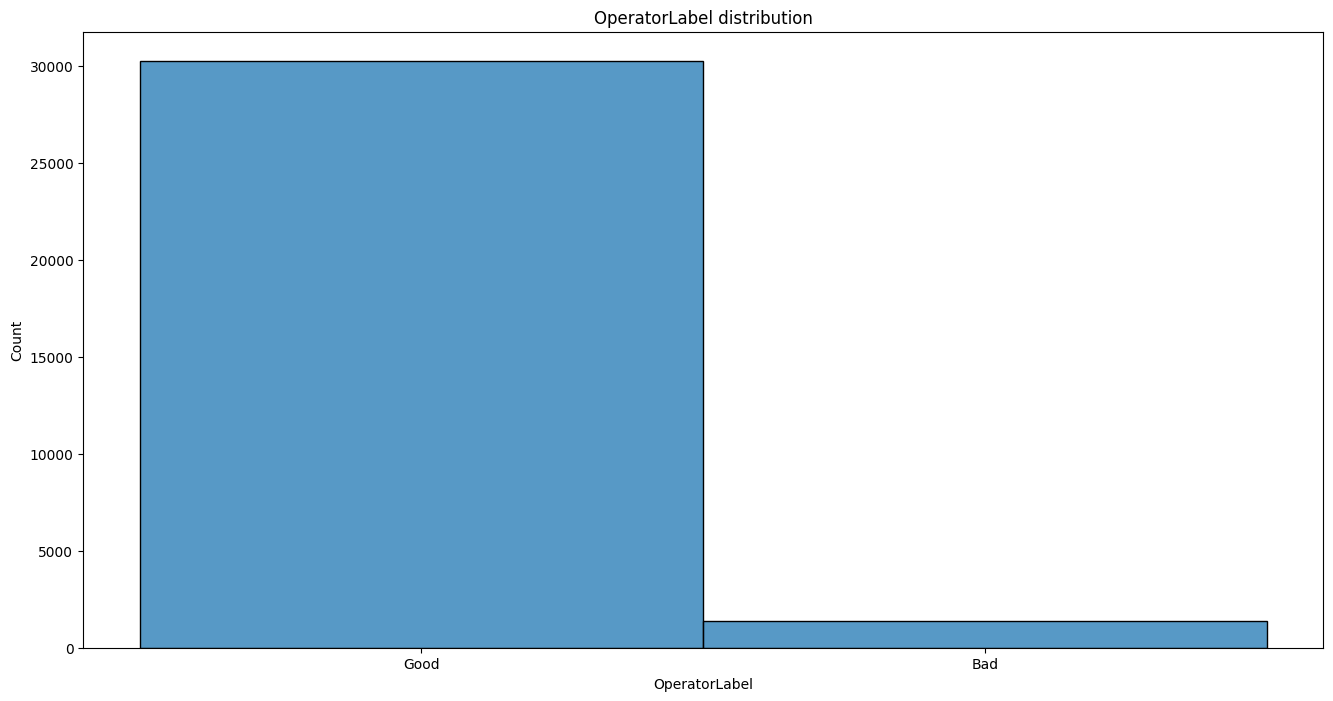

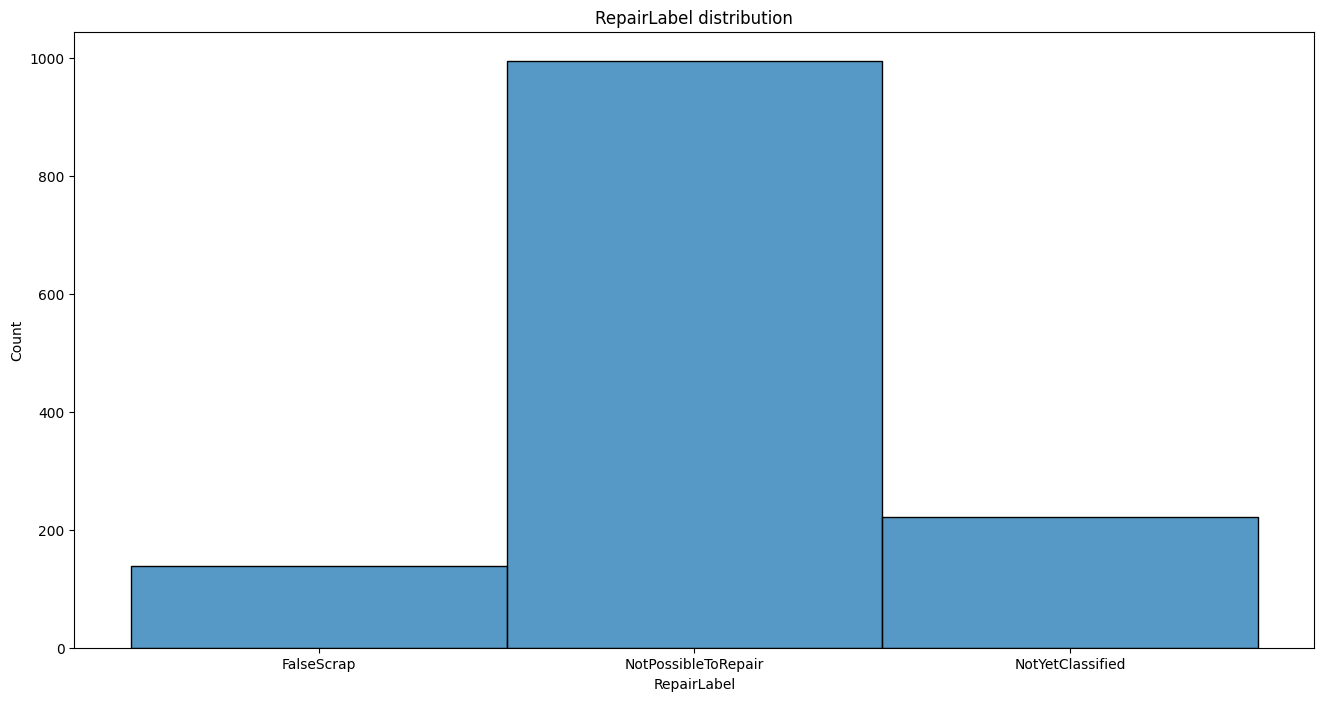

In [ ]:
categorical_to_show = [col for col in categorical_cols if col not in ["PanelID"]]
for col in categorical_to_show:
  plt.figure(figsize=(16, 8))
  sns.histplot(data=aoi_train, x=col)
  plt.title(f"{col} distribution")
  plt.xlabel(col)
  plt.ylabel("Count")
  plt.show()

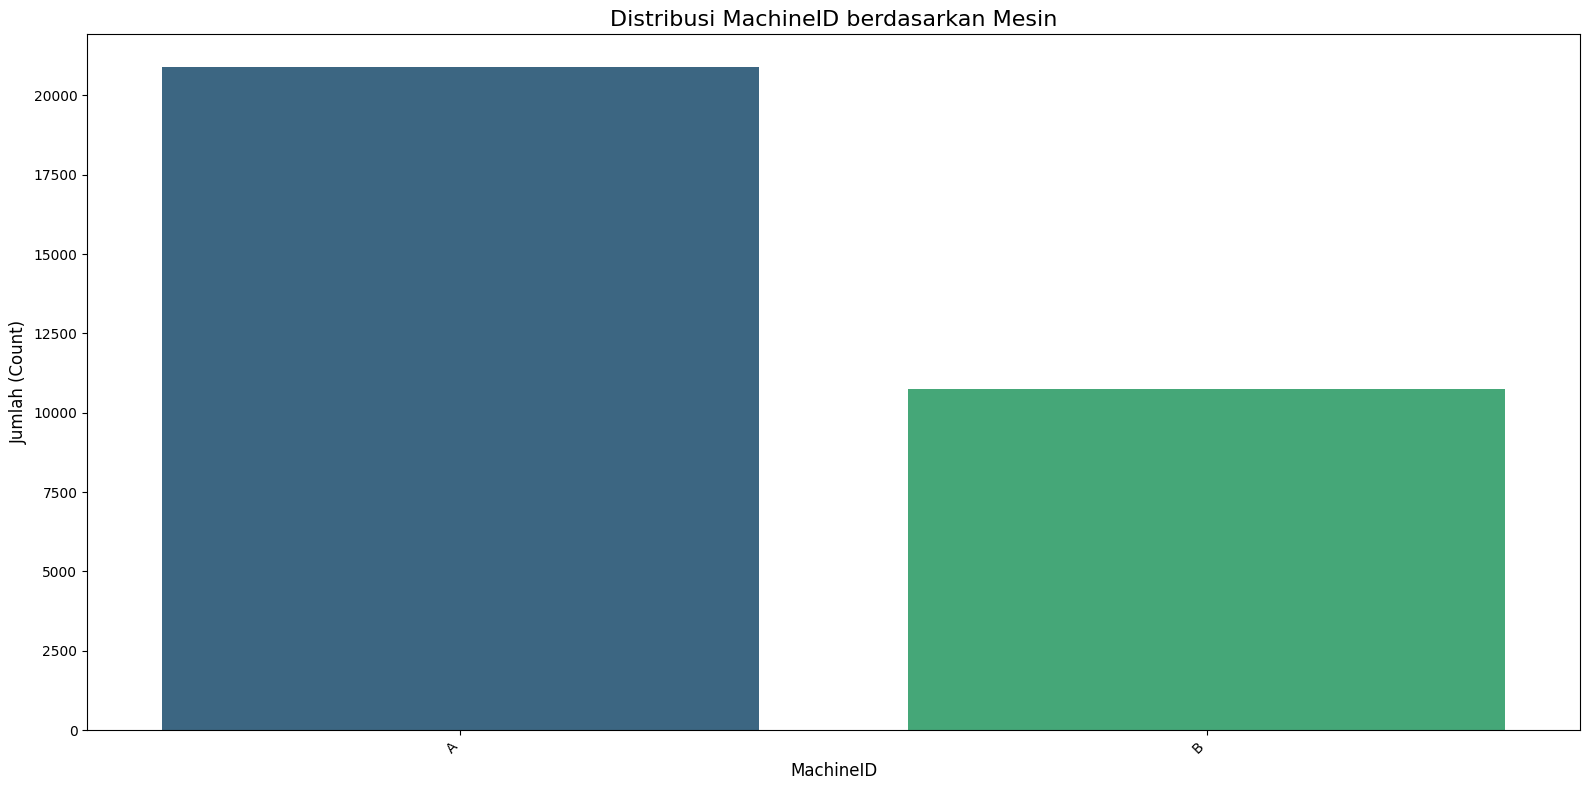

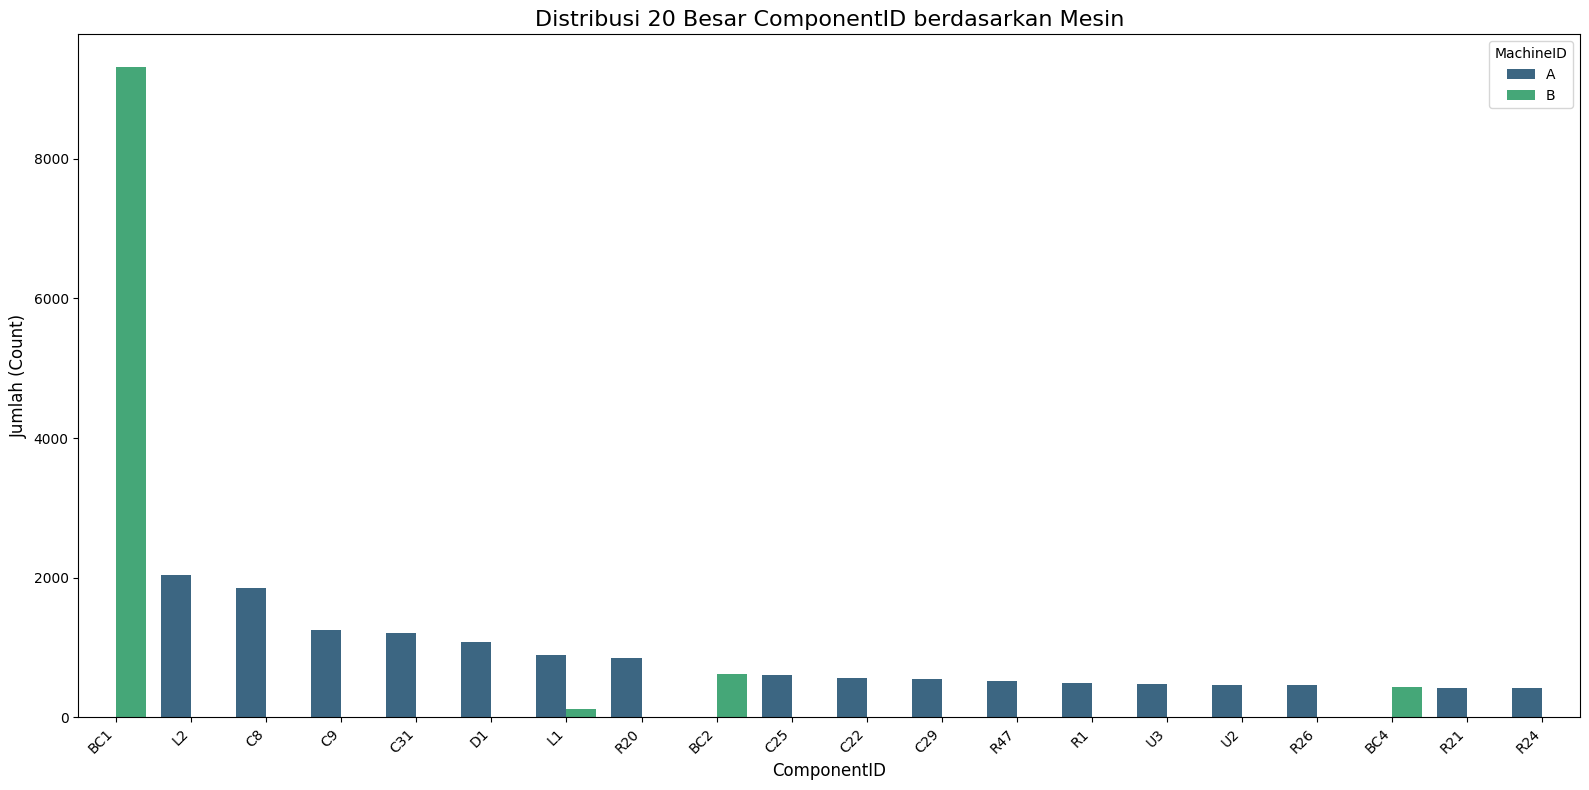

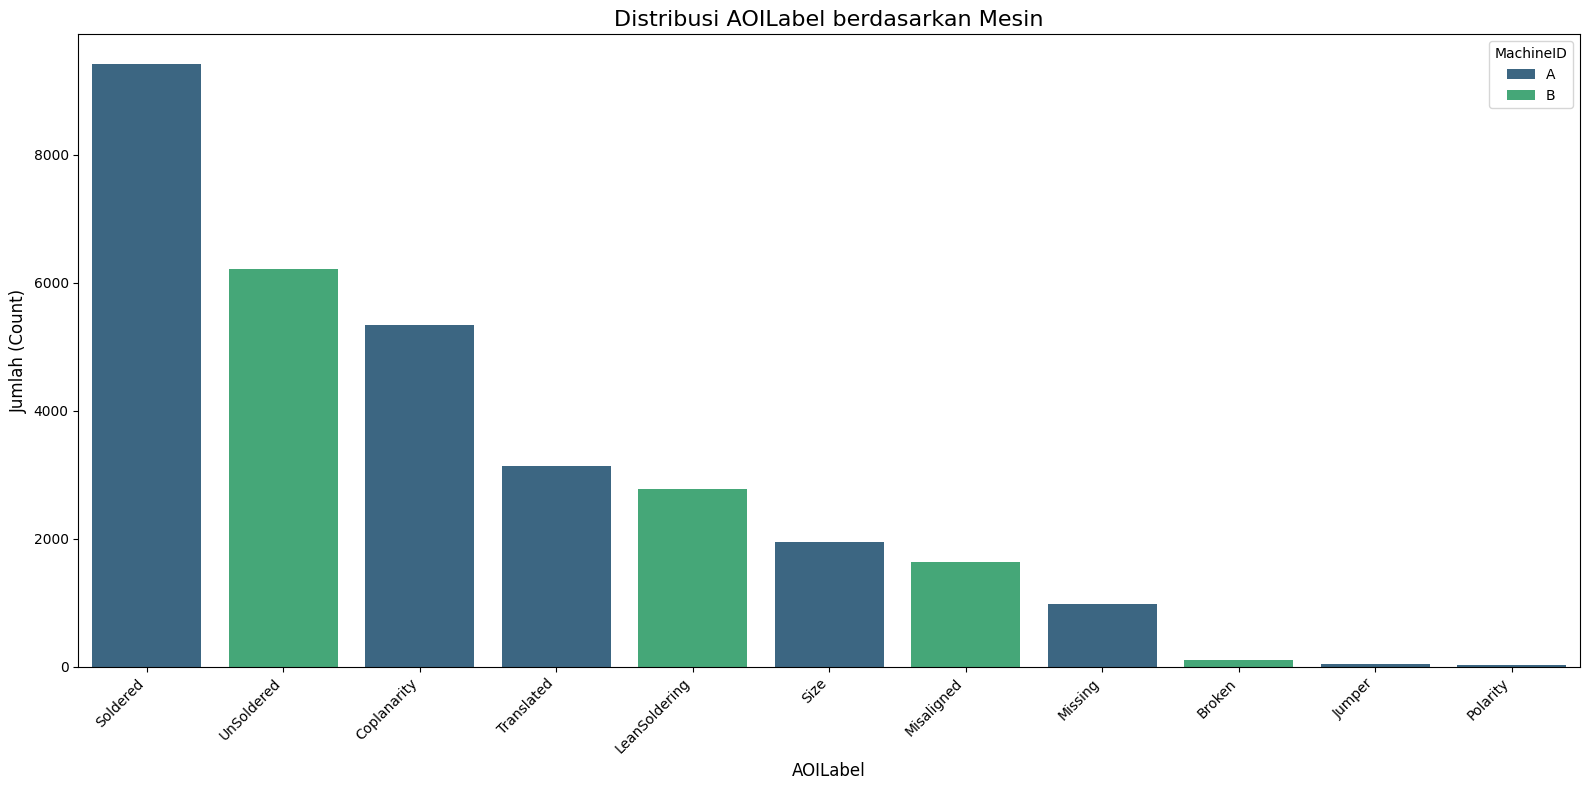

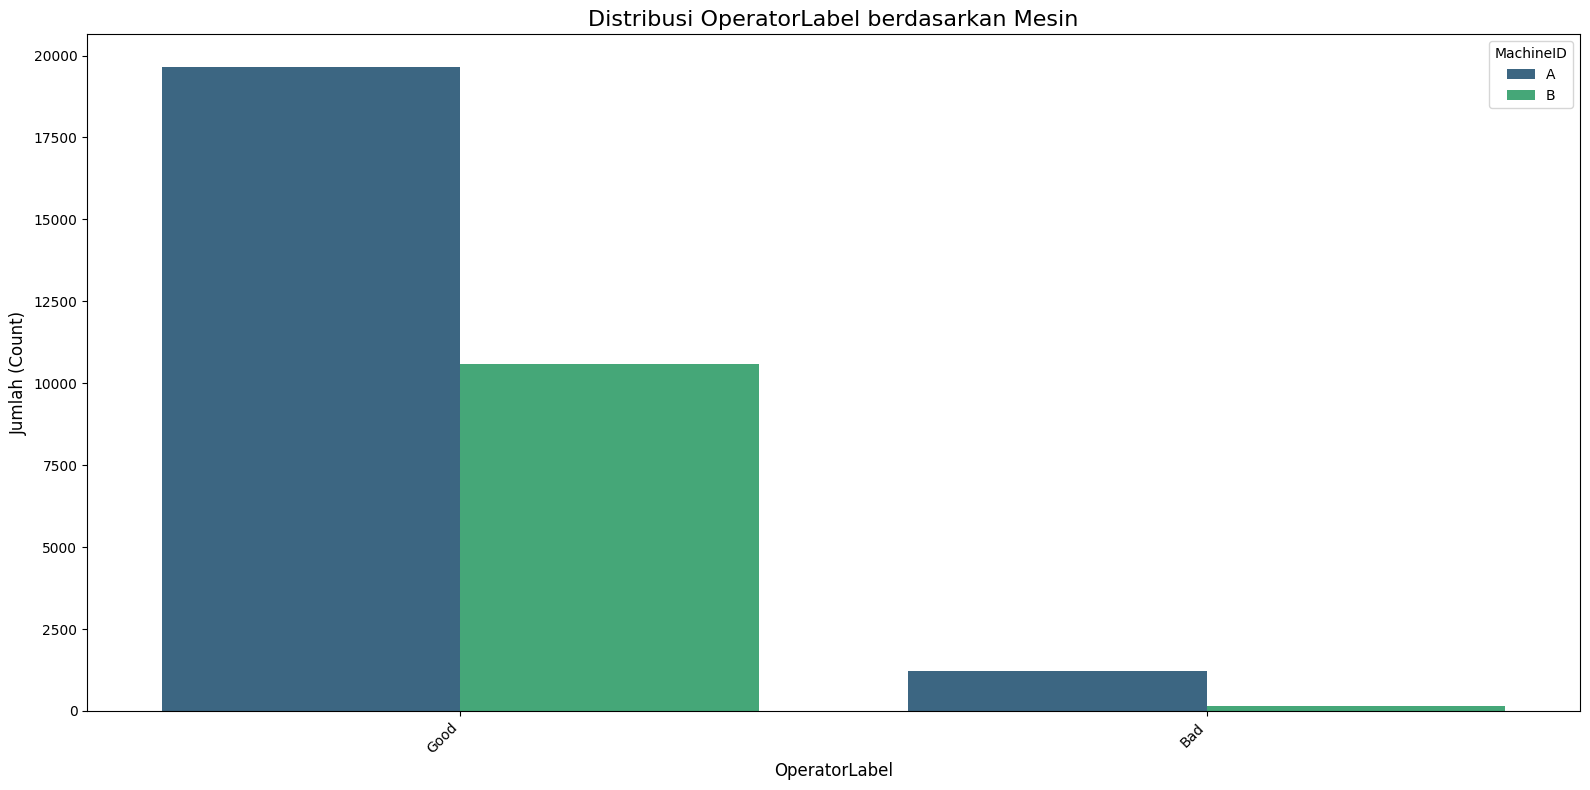

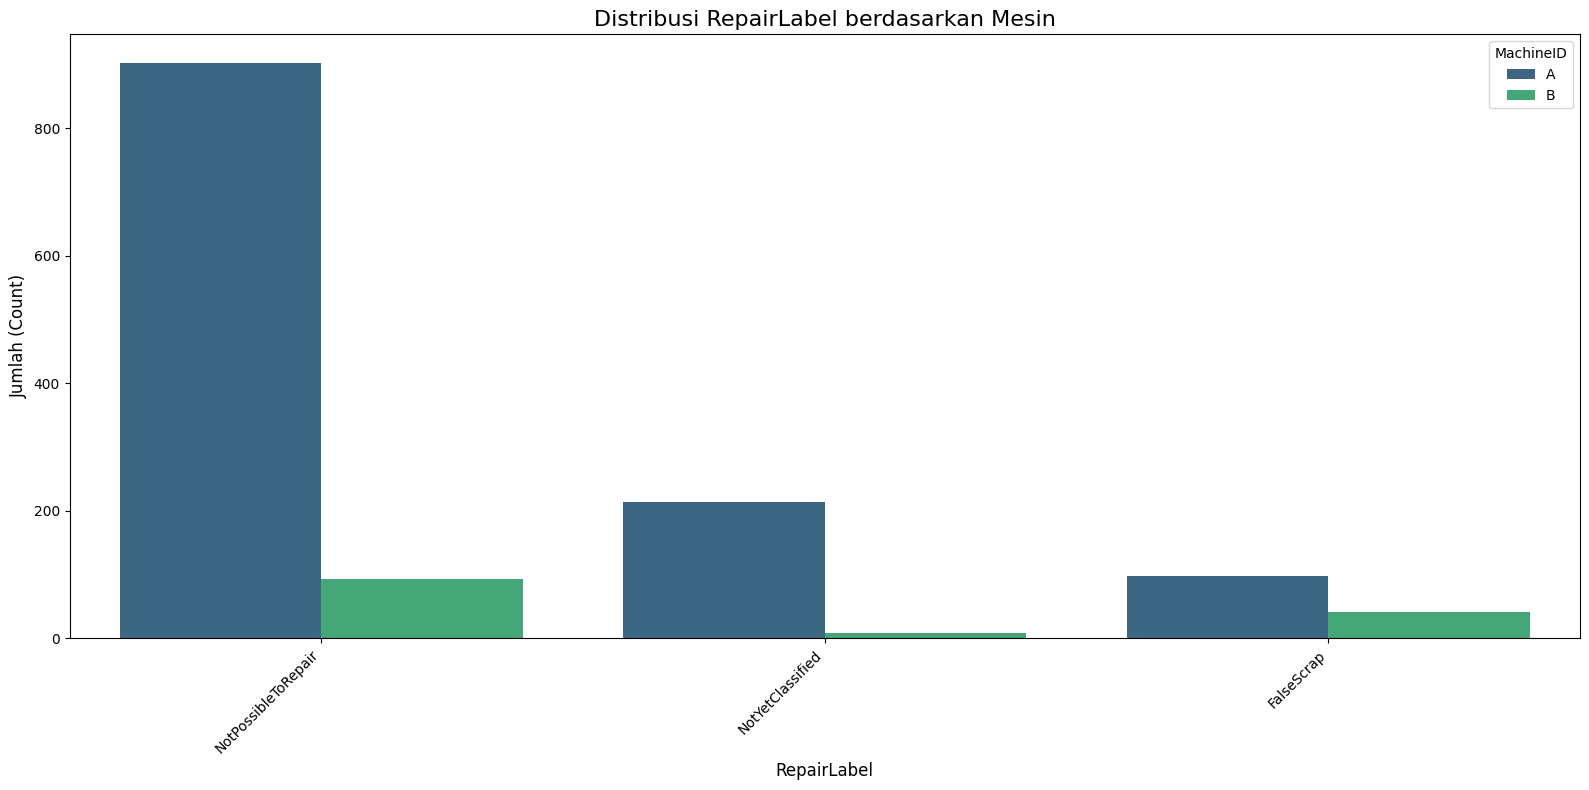

In [ ]:
categorical_to_show = ['MachineID', 'ComponentID', 'AOILabel', 'OperatorLabel', 'RepairLabel']
for col in categorical_to_show:
    plt.figure(figsize=(16, 8))
    if aoi_train[col].nunique() > 15:
        order = aoi_train[col].value_counts().nlargest(20).index
        plot_title = f'Distribusi 20 Besar {col} berdasarkan Mesin'
    else:
        order = aoi_train[col].value_counts().index
        plot_title = f'Distribusi {col} berdasarkan Mesin'
    sns.countplot(data=aoi_train, x=col, hue="MachineID", order=order, palette="viridis")
    plt.title(plot_title, fontsize=16)
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Jumlah (Count)", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

Setelah memahami distribusi umum data AOI, analisis selanjutnya menggali lebih dalam untuk menghubungkan temuan awal mesin (AOILabel) dengan hasil diagnosis akhir (RepairLabel). Analisis ini krusial untuk mengevaluasi dampak bisnis dari setiap jenis cacat yang terdeteksi.



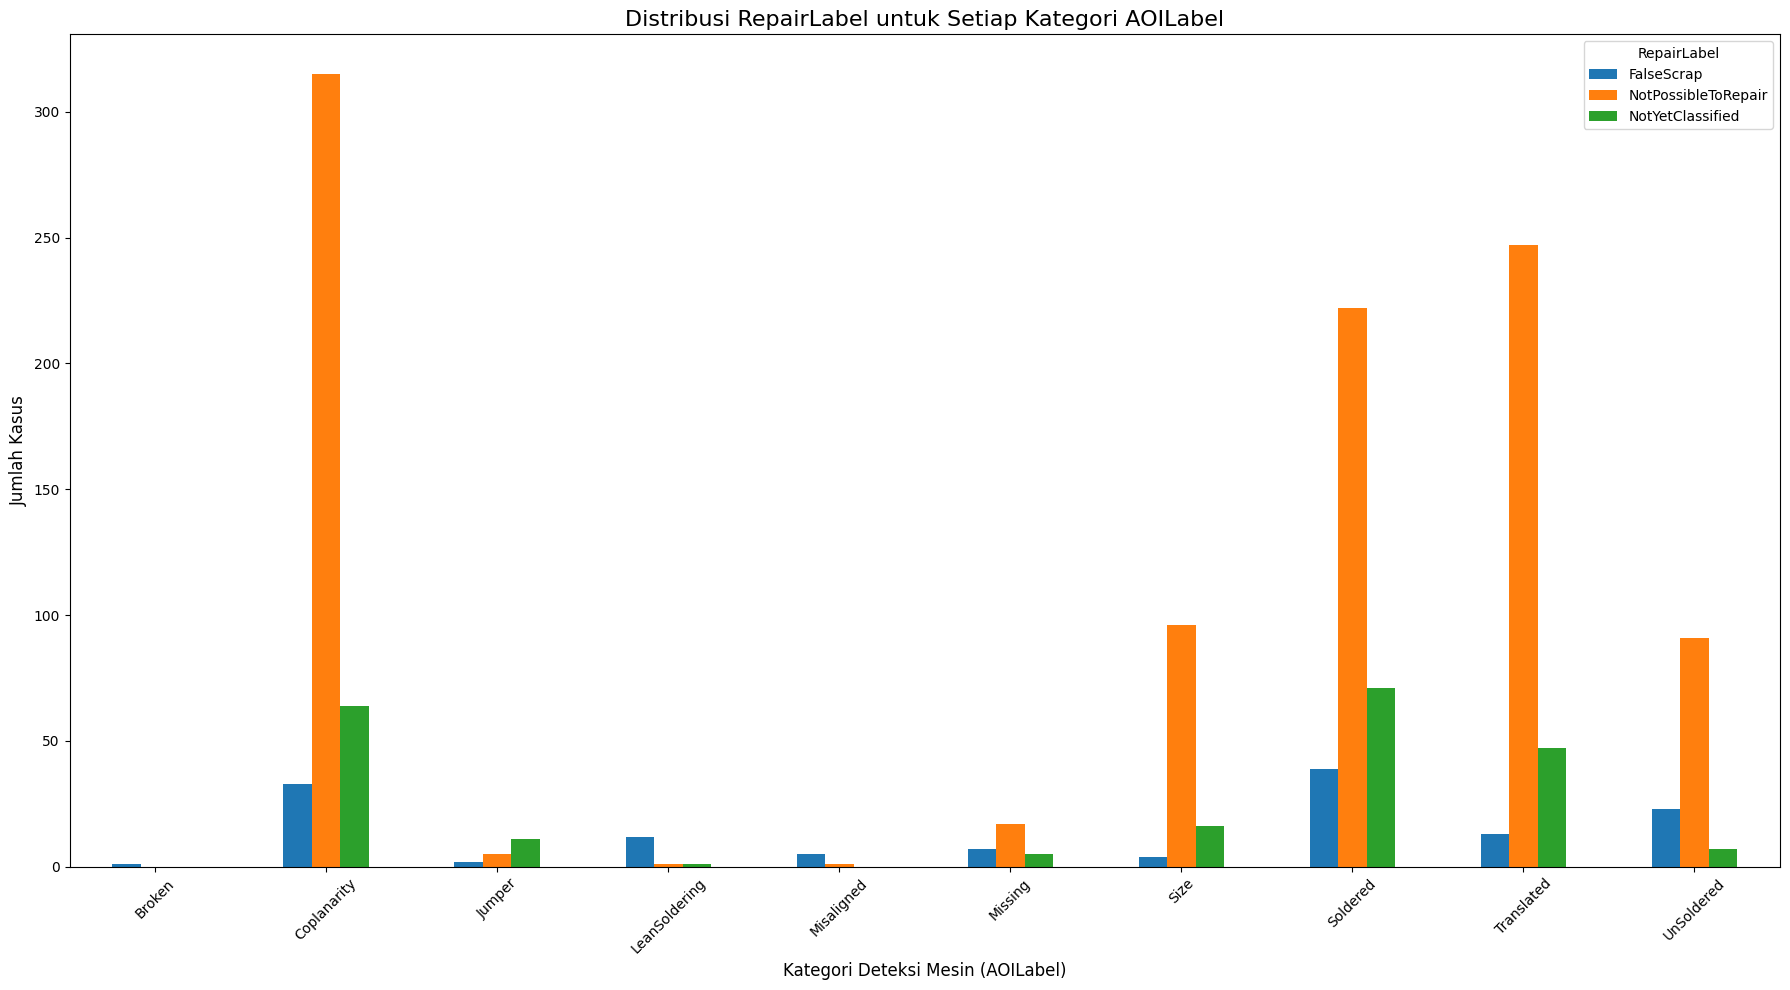

In [ ]:
crosstab_df = pd.crosstab(aoi_train['AOILabel'], aoi_train['RepairLabel'])
crosstab_df.plot.bar(rot=45, figsize=(18, 10))
plt.title('Distribusi RepairLabel untuk Setiap Kategori AOILabel', fontsize=16)
plt.xlabel('Kategori Deteksi Mesin (AOILabel)', fontsize=12)
plt.ylabel('Jumlah Kasus', fontsize=12)
plt.legend(title='RepairLabel')
plt.tight_layout()
plt.show()

* Untuk hampir semua kategori AOILabel, hasil akhir yang paling dominan adalah NotPossibleToRepair. Ini mengindikasikan bahwa sebagian besar cacat yang terdeteksi pada tahap AOI sudah tidak dapat diperbaiki dan akan menjadi produk gagal (scrap).

* Di sisi lain, jumlah kasus FalseScrap (mesin salah mendeteksi cacat) sangatlah rendah. Ini adalah temuan positif yang menunjukkan bahwa mesin AOI memiliki tingkat presisi yang tinggi. Ketika mesin melaporkan adanya cacat, laporan tersebut hampir selalu valid.

Analisis sebelumnya telah menunjukkan jumlah absolut dari setiap hasil perbaikan. Namun, untuk mendapatkan perbandingan yang adil antar jenis cacat, kita perlu melihatnya dari sisi proporsi. Melalui analisis ini, kami dapat menormalisasi data untuk mengetahui berapa persen suatu jenis cacat itu tergolong fatal.

RepairLabel    FalseScrap  NotPossibleToRepair  NotYetClassified
AOILabel                                                        
Broken           1.000000             0.000000          0.000000
Coplanarity      0.080097             0.764563          0.155340
Jumper           0.111111             0.277778          0.611111
LeanSoldering    0.857143             0.071429          0.071429
Misaligned       0.833333             0.166667          0.000000
Missing          0.241379             0.586207          0.172414
Size             0.034483             0.827586          0.137931
Soldered         0.117470             0.668675          0.213855
Translated       0.042345             0.804560          0.153094
UnSoldered       0.190083             0.752066          0.057851


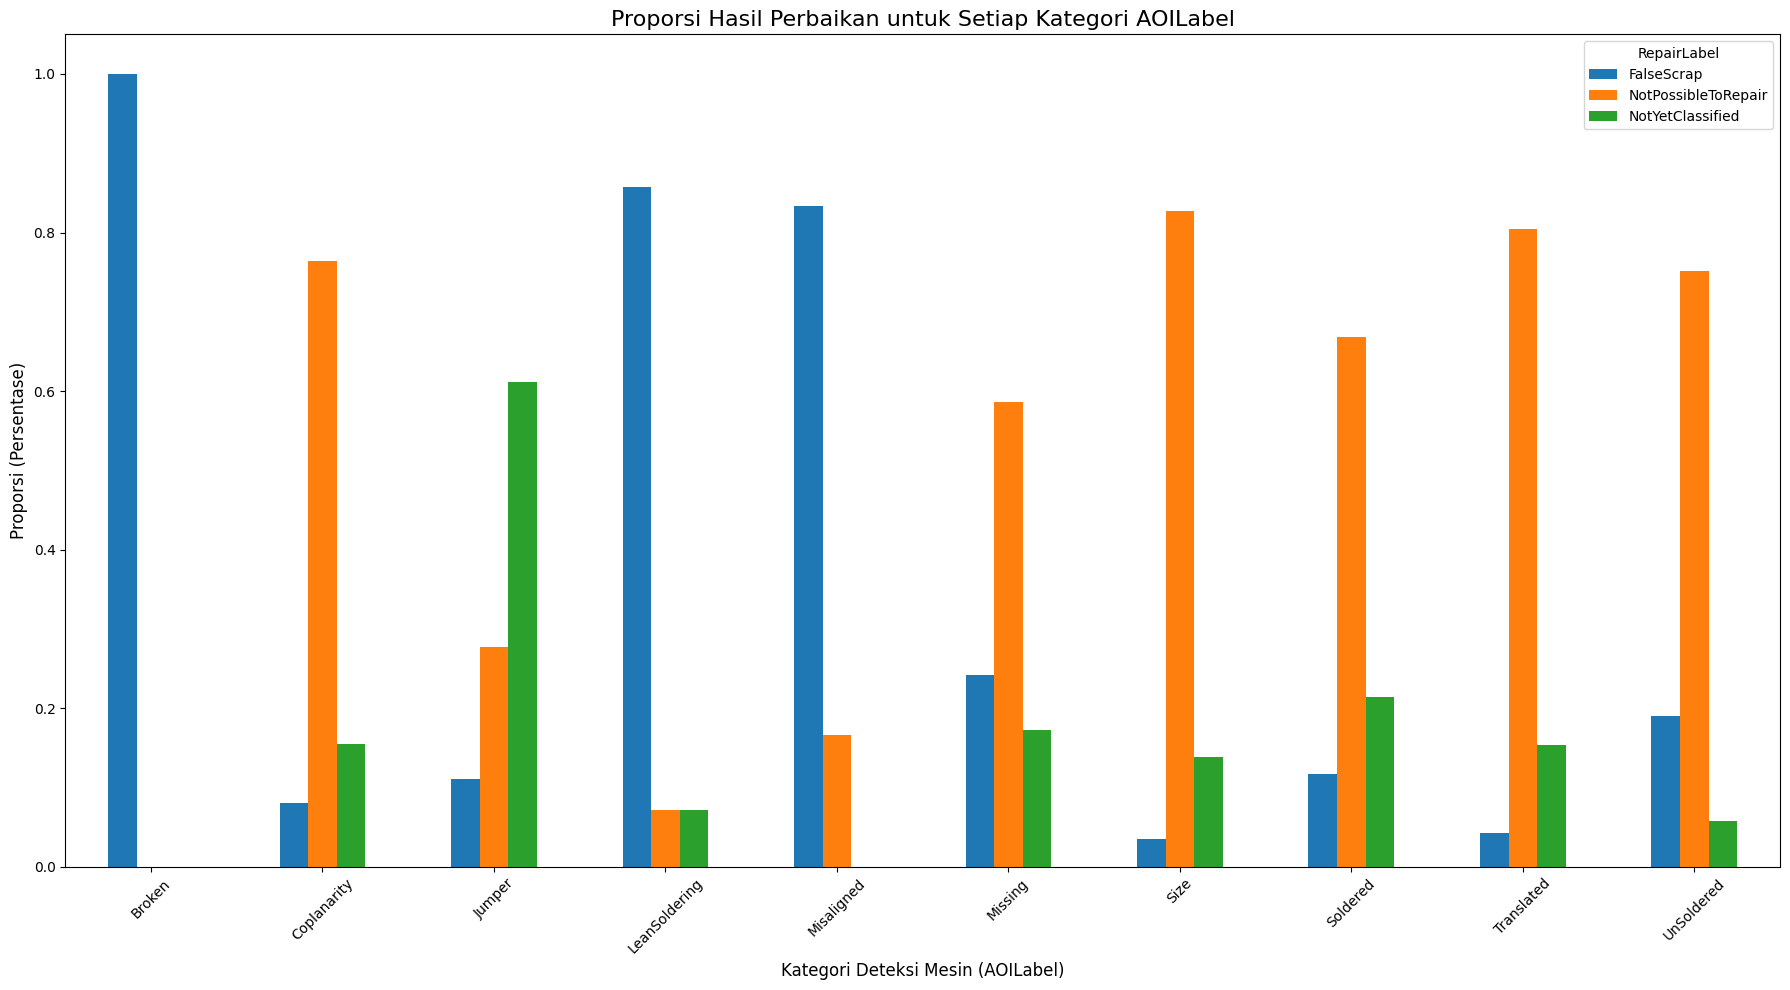

In [ ]:
df_counts = pd.crosstab(aoi_train['AOILabel'], aoi_train['RepairLabel'])
df_proportions = df_counts.div(df_counts.sum(axis=1), axis=0)
print(df_proportions)
df_proportions.plot.bar(rot=45, figsize=(18, 10))
plt.title('Proporsi Hasil Perbaikan untuk Setiap Kategori AOILabel', fontsize=16)
plt.xlabel('Kategori Deteksi Mesin (AOILabel)', fontsize=12)
plt.ylabel('Proporsi (Persentase)', fontsize=12)
plt.legend(title='RepairLabel')
plt.tight_layout()
plt.show()

* Analisis ini menyoroti cacat mana yang memiliki dampak paling parah. Terlihat jelas bahwa jika mesin mendeteksi cacat Size, Translated, dan UnSoldered, maka probabilitasnya sangat tinggi (sekitar 75% - 83%) bahwa produk tersebut akan berakhir NotPossibleToRepair. Cacat-cacat inilah yang harus menjadi prioritas utama untuk dicegah karena dampak kerugiannya paling tinggi per kejadian.

* Untuk cacat LeanSoldering dan Misaligned, proporsi terbesar justru jatuh pada kategori FalseScrap. Ini adalah indikasi kuat bahwa mesin AOI mungkin terlalu sensitif atau kurang terkalibrasi dengan baik untuk mendeteksi kedua jenis cacat ini. Banyaknya false positive untuk kategori ini dapat menyebabkan pemborosan waktu operator untuk melakukan verifikasi yang tidak perlu.

Upaya perbaikan tidak hanya harus fokus pada pencegahan cacat yang sering terjadi, tetapi juga pada pencegahan cacat dengan tingkat keparahan tertinggi

Setelah menganalisis karakteristik data AOI, langkah ini bertujuan untuk melakukan evaluasi kuantitatif pertama terhadap kinerja mesin. Sebuah model klasifikasi biner sederhana dibuat dengan asumsi bahwa label Soldered dianggap 'Good' dan semua label lainnya dianggap 'Bad'. Kinerja model sederhana ini kemudian dibandingkan dengan OperatorLabel sebagai ground truth.

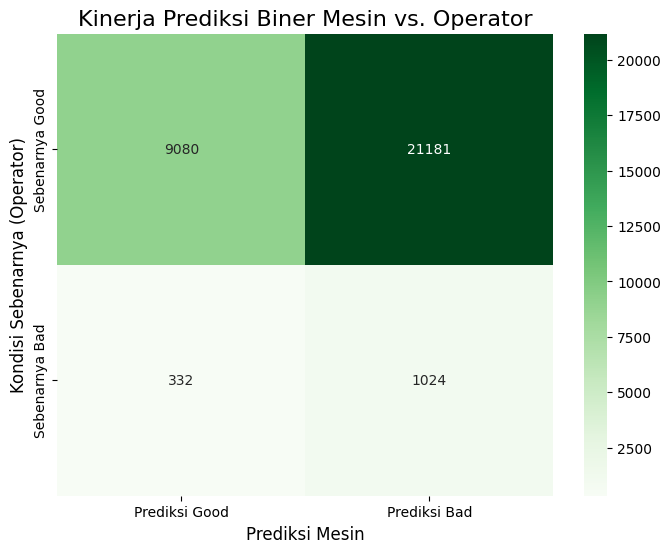


Kinerja Mesin AOI (untuk kelas 'Bad'):
              precision    recall  f1-score   support

        Good       0.96      0.30      0.46     30261
         Bad       0.05      0.76      0.09      1356

    accuracy                           0.32     31617
   macro avg       0.51      0.53      0.27     31617
weighted avg       0.93      0.32      0.44     31617



In [ ]:
aoi_train['MachinePrediction'] = aoi_train['AOILabel'].apply(lambda x: 'Good' if x == 'Soldered' else 'Bad')
cm = confusion_matrix(aoi_train['OperatorLabel'], aoi_train['MachinePrediction'], labels=['Good', 'Bad'])
cm_df = pd.DataFrame(cm, index=['Sebenarnya Good', 'Sebenarnya Bad'], columns=['Prediksi Good', 'Prediksi Bad'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Greens')
plt.title('Kinerja Prediksi Biner Mesin vs. Operator', fontsize=16)
plt.xlabel('Prediksi Mesin', fontsize=12)
plt.ylabel('Kondisi Sebenarnya (Operator)', fontsize=12)
plt.show()

print("\nKinerja Mesin AOI (untuk kelas 'Bad'):")
print(classification_report(aoi_train['OperatorLabel'], aoi_train['MachinePrediction'], labels=['Good', 'Bad']))

* Mesin ini sangat sensitif dan berhasil menemukan 76% dari semua kasus yang sebenarnya 'Bad'

* Presisi mesin sangat rendah, hanya 5%. Artinya, dari semua kasus yang diprediksi 'Bad' oleh mesin, hanya 5% yang benar-benar 'Bad' menurut operator. Sisanya (95%) adalah false positive

Akurasi keseluruhan yang hanya 32% mengonfirmasi bahwa aturan biner sederhana ('Soldered' = Good) ini bukanlah cara yang tepat untuk merepresentasikan logika kerja mesin.

Mesin AOI tampaknya dikalibrasi untuk memiliki sensitivitas maksimum (recall tinggi) dengan mengorbankan presisi. Tujuannya adalah untuk menangkap segala data yang mencurigakan dan menyerahkan tugas verifikasi akhir kepada operator manusia.

AOILabel
UnSoldered       28.785232
Coplanarity      23.247250
Translated       13.337425
LeanSoldering    13.021104
Size              8.668146
Misaligned        7.709740
Missing           4.475709
Broken            0.509891
Jumper            0.132194
Polarity          0.113309
Name: count, dtype: float64


/tmp/ipython-input-39-1509373284.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fp_counts.index,y=fp_counts.values, palette='Oranges_r')


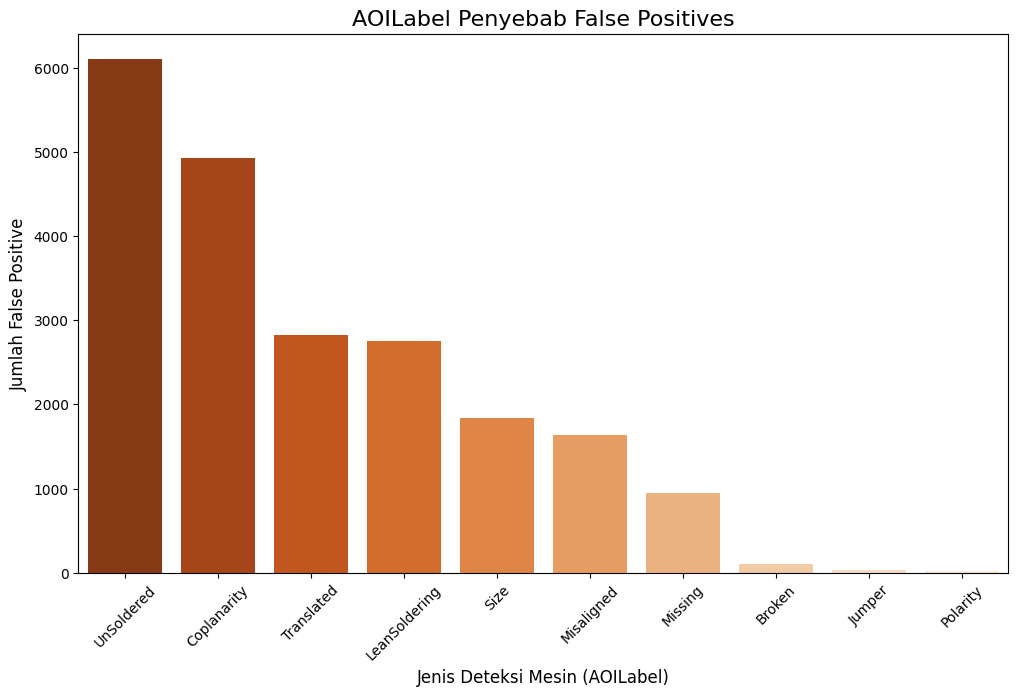

In [ ]:
false_positives = aoi_train[(aoi_train['MachinePrediction'] == 'Bad') & (aoi_train['OperatorLabel'] == 'Good')]
fp_counts = false_positives['AOILabel'].value_counts()
fp_counts_percentage = false_positives['AOILabel'].value_counts() * 100 / len(false_positives["AOILabel"])
print(fp_counts_percentage)
plt.figure(figsize=(12, 7))
sns.barplot(x=fp_counts.index,y=fp_counts.values, palette='Oranges_r')
plt.title('AOILabel Penyebab False Positives', fontsize=16)
plt.xlabel('Jenis Deteksi Mesin (AOILabel)', fontsize=12)
plt.ylabel('Jumlah False Positive', fontsize=12)
plt.xticks(rotation=45)
plt.show()

Ditemukan bahwa hampir 80% dari seluruh false positive berasal hanya dari empat kategori deteksi mesin, yaitu Unsoldered, Coplanarity, Translated, LeanSoldering.

Tingginya false positive pada kategori ini kemungkinan besar bukan karena mesin rusak, melainkan karena adanya perbedaan definisi atau ambang batas toleransi (threshold). Mesin mungkin diatur untuk menjadi sangat sensitif dan melaporkan penyimpangan Coplanarity atau UnSoldered yang sangat minor, yang oleh operator manusia masih dianggap dalam batas wajar dan tidak akan mempengaruhi fungsi produk.

/tmp/ipython-input-40-1573266394.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=real_defect_counts.index, y=real_defect_counts.values, palette='plasma')


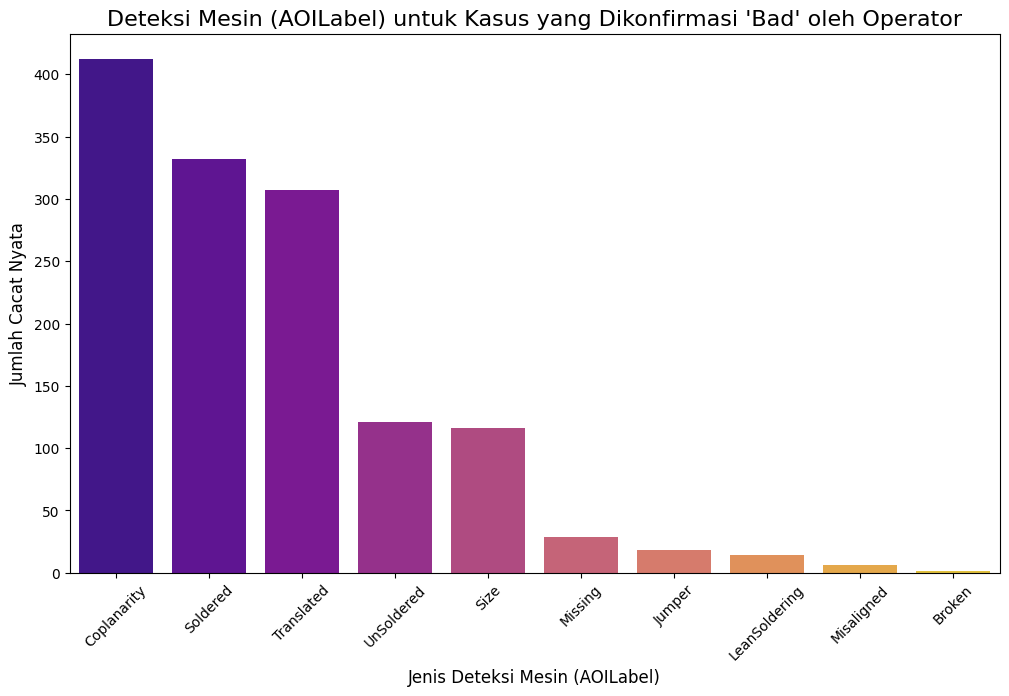

In [ ]:
real_defects = aoi_train[aoi_train['OperatorLabel'] == 'Bad']
real_defect_counts =real_defects['AOILabel'].value_counts()
plt.figure(figsize=(12, 7))
sns.barplot(x=real_defect_counts.index, y=real_defect_counts.values, palette='plasma')
plt.title("Deteksi Mesin (AOILabel) untuk Kasus yang Dikonfirmasi 'Bad' oleh Operator", fontsize=16)
plt.xlabel('Jenis Deteksi Mesin (AOILabel)', fontsize=12)
plt.ylabel('Jumlah Cacat Nyata', fontsize=12)
plt.xticks(rotation=45)
plt.show()

Saat sebuah PCB dipastikan benar-benar cacat oleh operator, mesin AOI paling sering mendeteksinya sebagai masalah Coplanarity, Soldered, dan Translated. Ketiga kategori ini adalah penyebab utama kegagalan kualitas yang terdeteksi.

Permasalahannya adalah Soldered adalah label yang digunakan mesin saat menganggap tidak ada masalah. Namun, label ini menjadi penyumbang kedua terbesar untuk kasus yang ternyata 'Bad'.

Ini berarti mesin seringkali gagal mendeteksi adanya masalah dan keliru melabeli produk cacat sebagai produk bagus. Ini adalah kasus cacat kritis yang terlewatkan (False Negative), yang merupakan risiko kualitas terbesar karena bisa lolos ke pelanggan.

## **Investigasi Penyebab Jenis Cacat Coplanarity sebagai Masalah Utama**

---



/tmp/ipython-input-41-3338378598.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=coplanarity_defects, y='MachineID', ax=axes[0], palette='magma')
/tmp/ipython-input-41-3338378598.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=coplanarity_defects, y='ComponentID', ax=axes[1], palette='viridis', order=top_components)


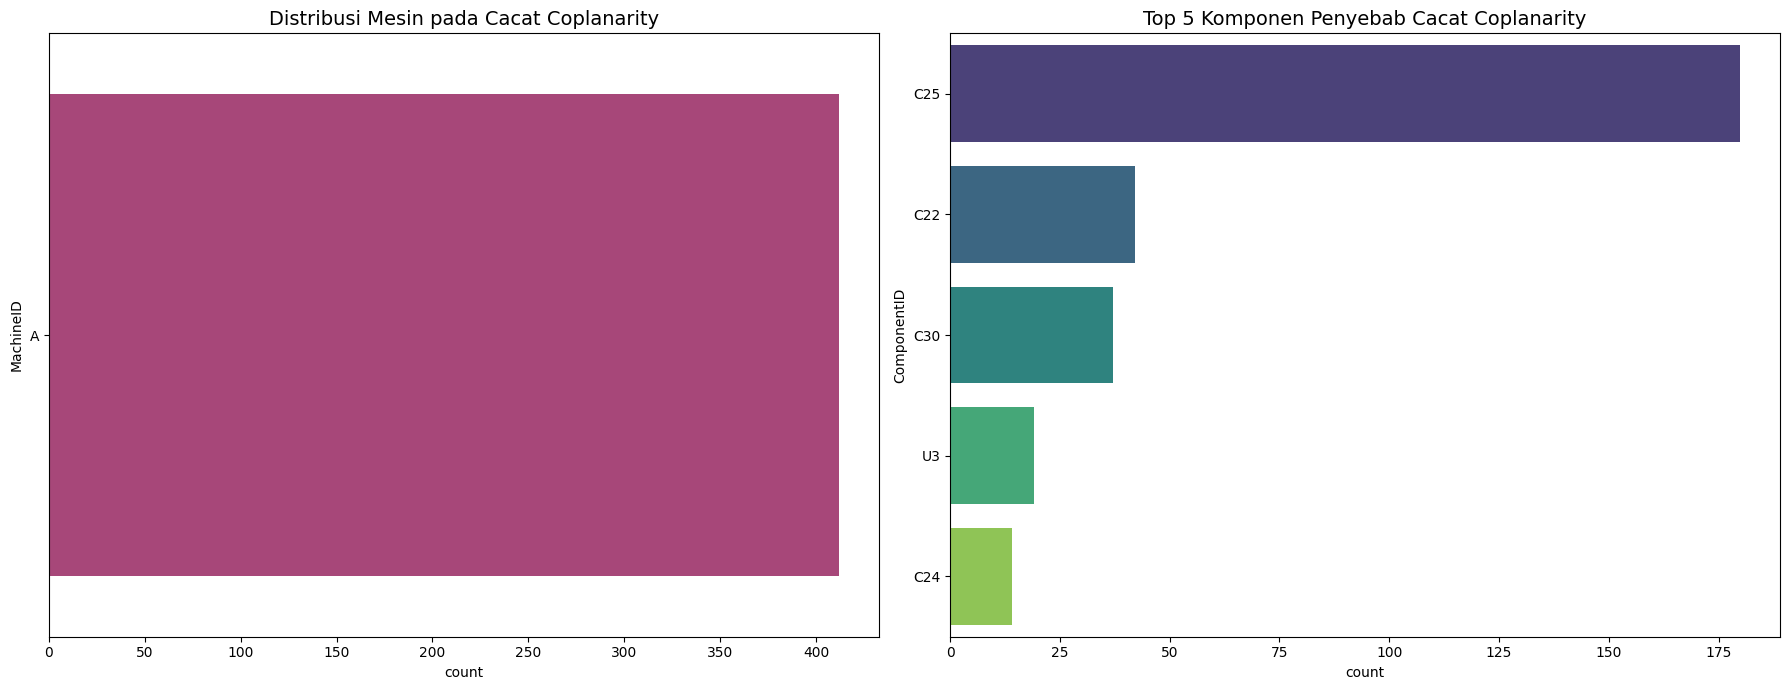

In [ ]:
coplanarity_defects = aoi_train[(aoi_train['OperatorLabel'] == 'Bad') & (aoi_train['AOILabel'] == 'Coplanarity')]
fig, axes =plt.subplots(1, 2, figsize=(18, 7))
sns.countplot(data=coplanarity_defects, y='MachineID', ax=axes[0], palette='magma')
axes[0].set_title('Distribusi Mesin pada Cacat Coplanarity', fontsize=14)
top_components = coplanarity_defects['ComponentID'].value_counts().nlargest(5).index
sns.countplot(data=coplanarity_defects, y='ComponentID', ax=axes[1], palette='viridis', order=top_components)
axes[1].set_title('Top 5 Komponen Penyebab Cacat Coplanarity', fontsize=14)
plt.tight_layout()
plt.show()

Seluruh jenis cacat Coplanarity terdeteksi menggunakan Mesin A

Cacat Coplanarity paling sering terjadi ketika memasang komponen C25


Membandingkan distribusi fitur numerik antara 'Good' dan 'Bad' (Coplanarity)...


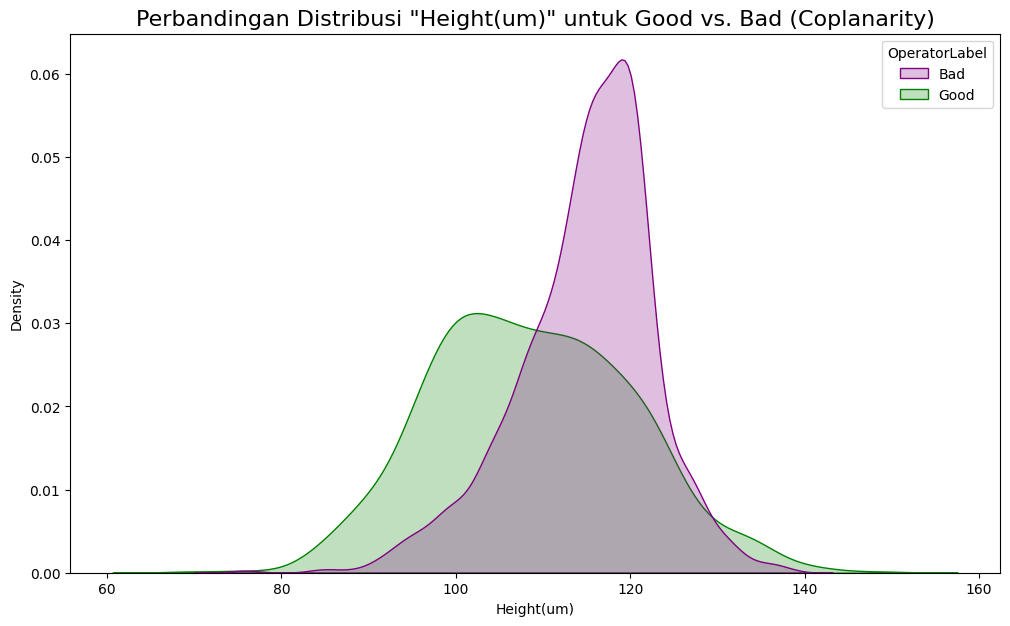

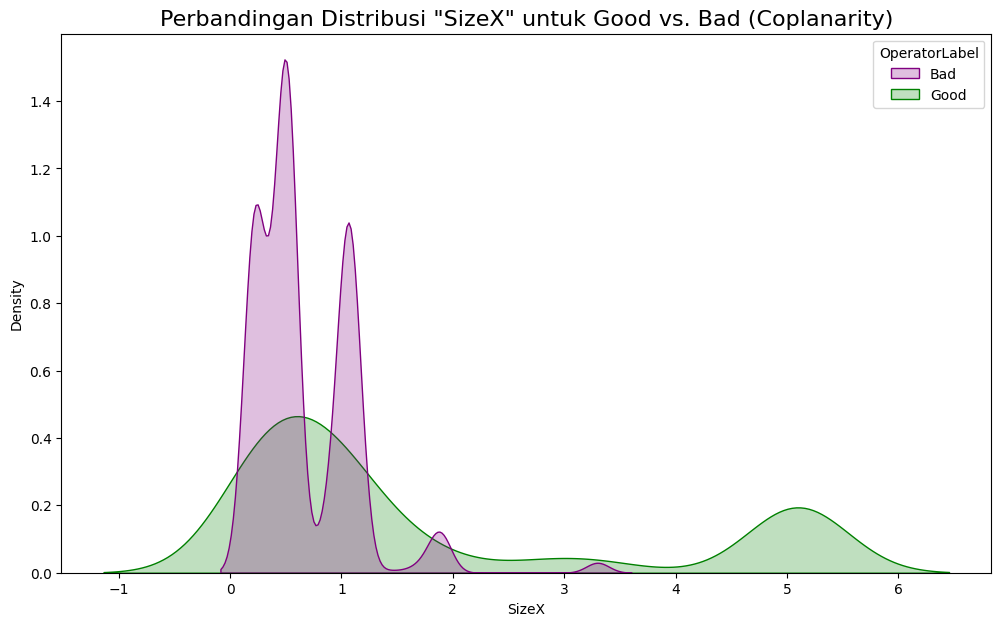

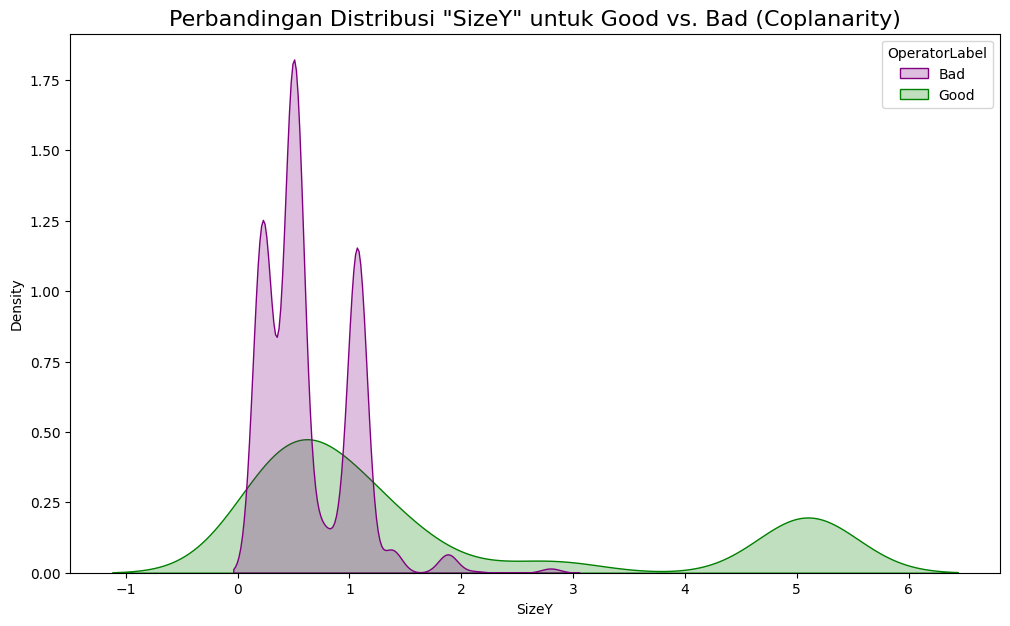

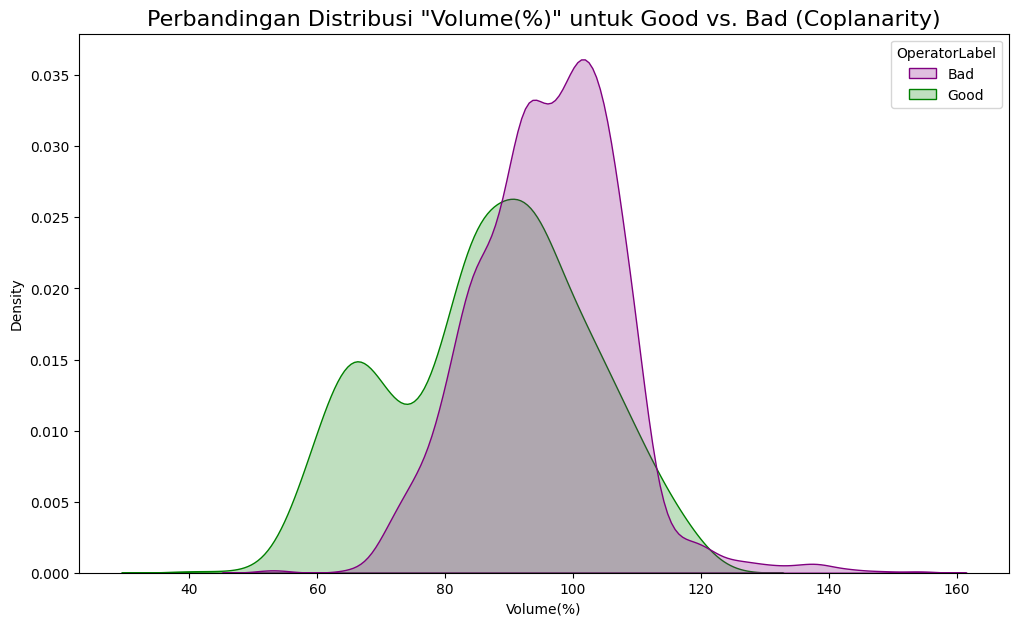

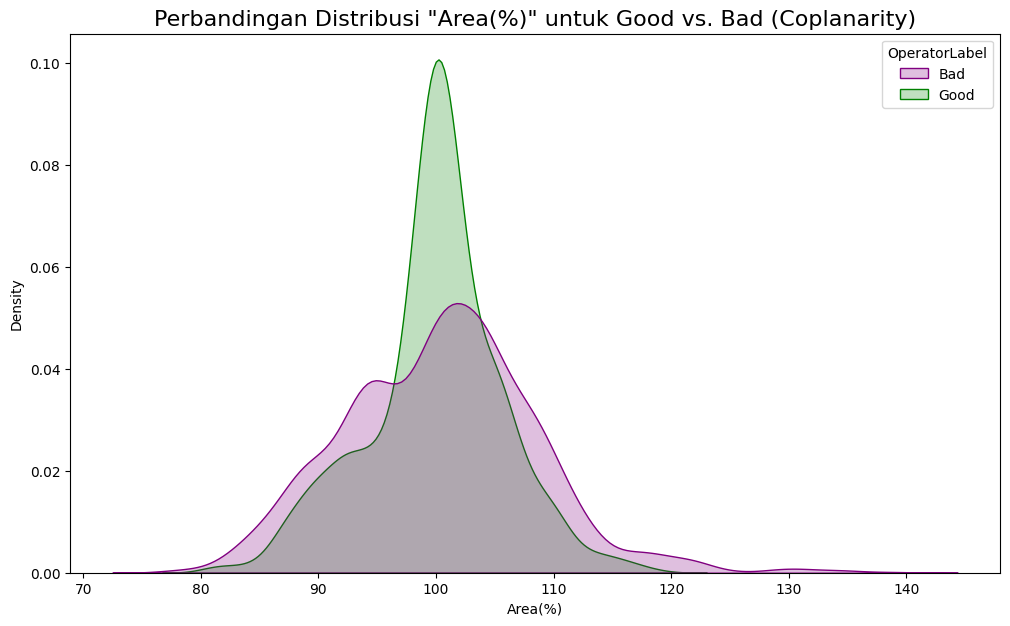

In [ ]:
good_sample = aoi_train[aoi_train['OperatorLabel'] == 'Good'].sample(n=len(coplanarity_defects), random_state=42)

# Gabung dengan data SPI buat dapet fitur numerik
coplanarity_defects_spi = pd.merge(coplanarity_defects, merged_spi, on=["PanelID", "FigureID", "ComponentID"], how='left', suffixes=('_aoi', '_spi'))
good_sample_spi = pd.merge(good_sample, merged_spi, on=["PanelID", "FigureID", "ComponentID"], how='left', suffixes=('_aoi', '_spi'))

# Gabung kedua dataset untuk perbandingan
comparison_df_spi = pd.concat([coplanarity_defects_spi, good_sample_spi])
comparison_df_spi.reset_index(drop=True, inplace=True)
features_to_compare = ['Height(um)', 'SizeX', 'SizeY', 'Volume(%)', 'Area(%)']
print("\nMembandingkan distribusi fitur numerik antara 'Good' dan 'Bad' (Coplanarity)...")
for col in features_to_compare:
    plt.figure(figsize=(12, 7))
    sns.kdeplot(data=comparison_df_spi, x=col, hue='OperatorLabel', fill=True, common_norm=False, palette={'Good':'green', 'Bad':'purple'})

    plt.title(f'Perbandingan Distribusi "{col}" untuk Good vs. Bad (Coplanarity)', fontsize=16)
    plt.show()

Analisis gabungan dari ketiga grafik ini mengungkapkan anomali yang menjadi kunci untuk memecahkan masalah Coplanarity. Temuan utamanya adalah bahwa akar masalahnya bukanlah jumlah solder, melainkan bentuk tiga dimensi dari solder yang tidak ideal. Data menunjukkan bahwa saat cacat Coplanarity terjadi, ketinggian (Height) pasta solder secara signifikan lebih tinggi dari produk normal, namun volume (Volume) totalnya hanya sedikit lebih banyak. Secara logika, satu-satunya cara untuk mendapatkan ketinggian ekstra tanpa menambah banyak volume adalah dengan mengorbankan luas area dasarnya, yang terbukti dari distribusi Area(%) pada produk cacat yang lebih landai dan tidak sekonsisten produk bagus. Ini membuktikan bahwa pasta solder untuk cacat ini cenderung membentuk "kubah" yang tinggi dan ramping, bukan mendatar dan lebar seperti seharusnya. Bentuk "kubah" inilah yang secara fisik mendorong kaki komponen ke atas saat proses penempatan, mencegahnya duduk rata dan pada akhirnya menyebabkan cacat Coplanarity.

Setelah mengetahui masalahnya yaitu bentuk "kubah" dari pasta solder, Invesitigasi berikutnya adalah "MENGAPA" dan "DI MANA" bentuk kubah ini terjadi? Apakah ini masalah acak, atau ada faktor pemicu yang memperparahnya?

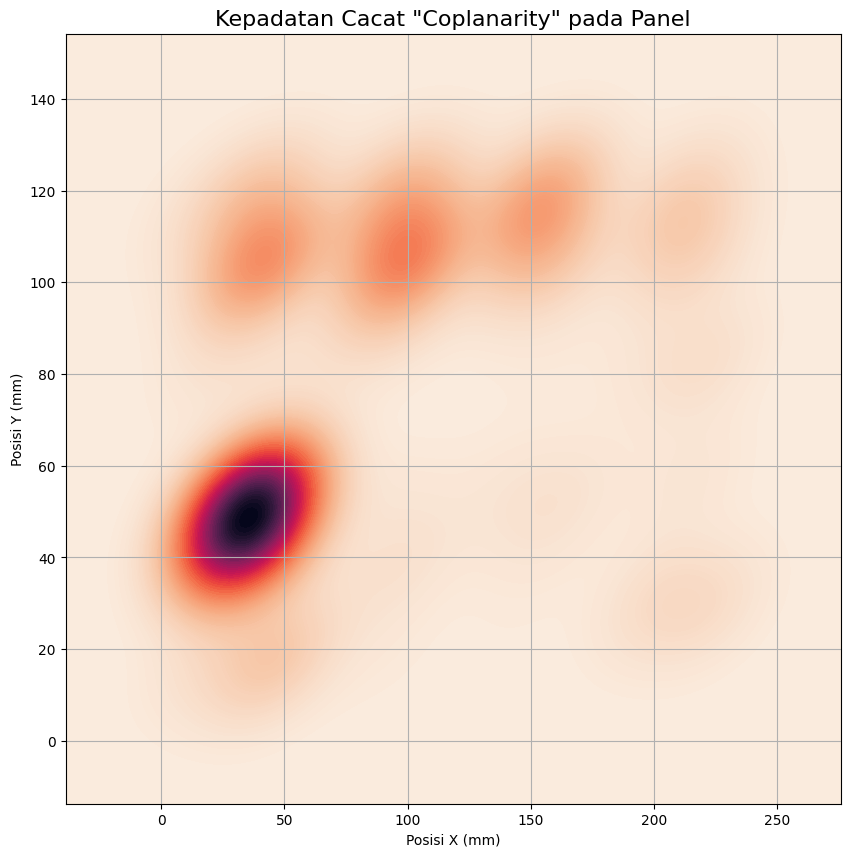

In [ ]:
#Spatial Analysis
coplanarity_defects = aoi_train[(aoi_train['OperatorLabel'] == 'Bad') & (aoi_train['AOILabel'] == 'Coplanarity')]
coplanarity_defects_spi = pd.merge(coplanarity_defects, merged_spi, on=["PanelID", "FigureID", "ComponentID"], how='left', suffixes=('_aoi', '_spi'))
coplanarity_defects_spi.dropna(subset=['PosX(mm)', 'PosY(mm)'], inplace=True)
plt.figure(figsize=(10, 10))
sns.kdeplot(data=coplanarity_defects_spi, x='PosX(mm)', y='PosY(mm)', fill=True, thresh=0, levels=100, cmap="rocket_r")
plt.title('Kepadatan Cacat "Coplanarity" pada Panel', fontsize=16)
plt.xlabel('Posisi X (mm)')
plt.ylabel('Posisi Y (mm)')
plt.grid(True)
plt.show()

 Peta menunjukkan bahwa cacat Coplanarity tidak tersebar secara acak. Terdapat satu "hotspot" utama dengan konsentrasi sangat tinggi di area kiri bawah (sekitar X=50, Y=45), dan beberapa titik panas sekunder lainnya.

 Ini adalah bukti kuat bahwa ada masalah yang sistematis dan berulang pada lokasi fisik tertentu. Ini mengesampingkan kemungkinan bahwa cacat ini murni disebabkan oleh faktor acak. Penyebabnya kemungkinan besar bersifat mekanis atau terkait dengan kalibrasi pada area spesifik tersebut.

Komponen yang paling sering mengalami Coplanarity: C25


/tmp/ipython-input-44-776008100.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pin_counts.index, y=pin_counts.values, palette='cool_d', order=pin_counts.index)


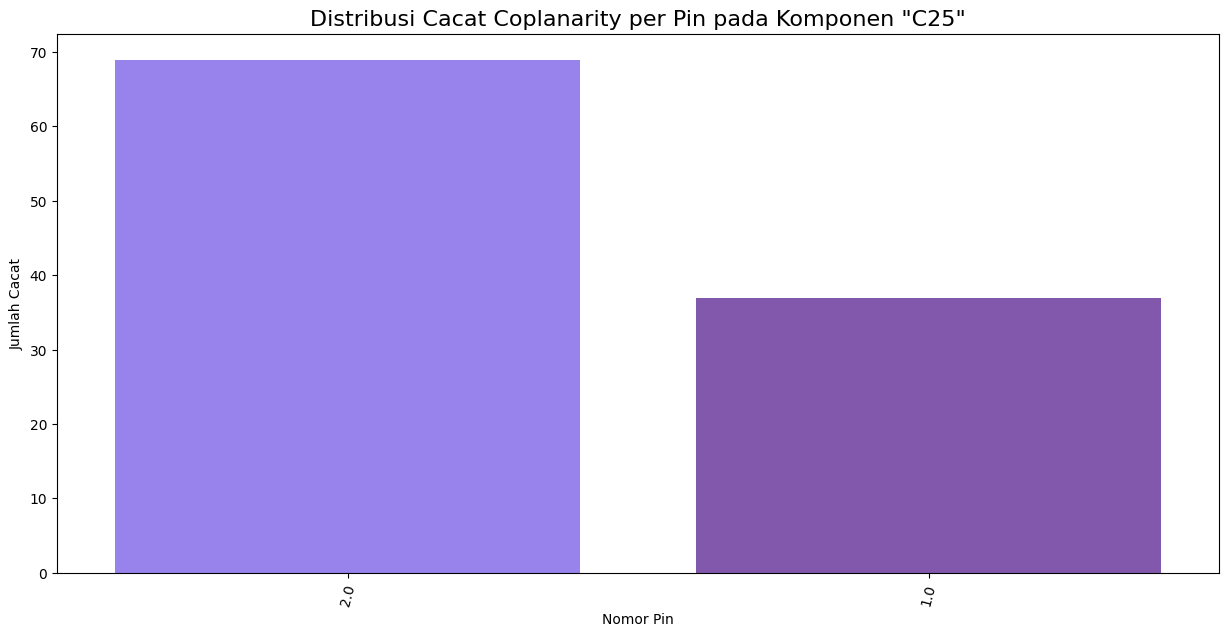

In [ ]:
#Identifikasi Komponen / Pin yang paling sering mengalami Coplanarity

if not coplanarity_defects.empty:
    top_component_for_coplanarity = coplanarity_defects['ComponentID'].value_counts().idxmax()
    print(f"Komponen yang paling sering mengalami Coplanarity: {top_component_for_coplanarity}")
    component_specific_defects = coplanarity_defects[coplanarity_defects['ComponentID'] == top_component_for_coplanarity]
    if not component_specific_defects['PinNumber'].isnull().all():
        plt.figure(figsize=(15, 7))
        pin_counts = component_specific_defects['PinNumber'].value_counts().nlargest(20)
        sns.barplot(x=pin_counts.index, y=pin_counts.values, palette='cool_d', order=pin_counts.index)
        plt.title(f'Distribusi Cacat Coplanarity per Pin pada Komponen "{top_component_for_coplanarity}"', fontsize=16)
        plt.xlabel('Nomor Pin')
        plt.ylabel('Jumlah Cacat')
        plt.xticks(rotation=75)
        plt.show()

Grafik menunjukkan bahwa dari total cacat Coplanarity pada komponen C25, Pin 2 gagal hampir dua kali lebih sering daripada Pin 1

Kegagalan yang tidak seimbang antara dua pin pada satu komponen adalah bukti kuat adanya masalah directional (terarah) atau gaya puntir (twisting force) saat komponen diletakkan oleh mesin. Mesin mungkin meletakkan komponen dengan sedikit putaran atau tekanan yang tidak merata, menyebabkan satu sisi (Pin 2) lebih sering terangkat.

Kesimpulan:
 kami menemukan bahwa penyebab utamanya bukanlah jumlah solder, melainkan profil pasta solder yang menyerupai 'kubah' tinggi, yang secara fisik mendorong komponen ke atas. analisis spasial kami menunjukkan bahwa masalah ini tidak terjadi secara acak. Terdapat hotspot kegagalan yang sangat terkonsentrasi di area sekitar (X=50, Y=45) pada panel, yang menunjuk pada masalah mekanis atau kalibrasi yang sistematis dan berulang di lokasi tersebut.
 Analisis pada komponen 'C25' sebagai komponen yang paling banyak mengalami Coplanarity membuktikan adanya masalah presisi saat penempatan. Fakta bahwa Pin 2 gagal dua kali lebih sering dari Pin 1 adalah bukti kuat adanya gaya puntir yang menyebabkan komponen tidak duduk dengan rata.

Rekomendasi Aksi:


*   Turunkan target ketinggian pasta solder pada proses SPI
*   Periksa mekanisme penempatan pada mesin pick-and-place untuk menghilangkan gaya puntir
* Lakukan inspeksi fisik pada mekanik mesin di area hotspot (X=50, Y=45).



## **Investigasi Penyebab Jenis Cacat Soldered**

---



In [ ]:
good_products_aoi = aoi_train[aoi_train["OperatorLabel"] == "Good"]
missed_defects_aoi = aoi_train[(aoi_train["OperatorLabel"] == "Bad") & (aoi_train["AOILabel"] == "Soldered")]
detected_defects_aoi = aoi_train[(aoi_train["OperatorLabel"] == "Bad") & (aoi_train["AOILabel"] != "Soldered")]

print(f"Jumlah Good Products: {len(good_products_aoi)}\n")
print(f"Jumlah Missed Defects: {len(missed_defects_aoi)}\n")
print(f"Jumlah Detected Defects: {len(detected_defects_aoi)}")

Jumlah Good Products: 30261

Jumlah Missed Defects: 332

Jumlah Detected Defects: 1024


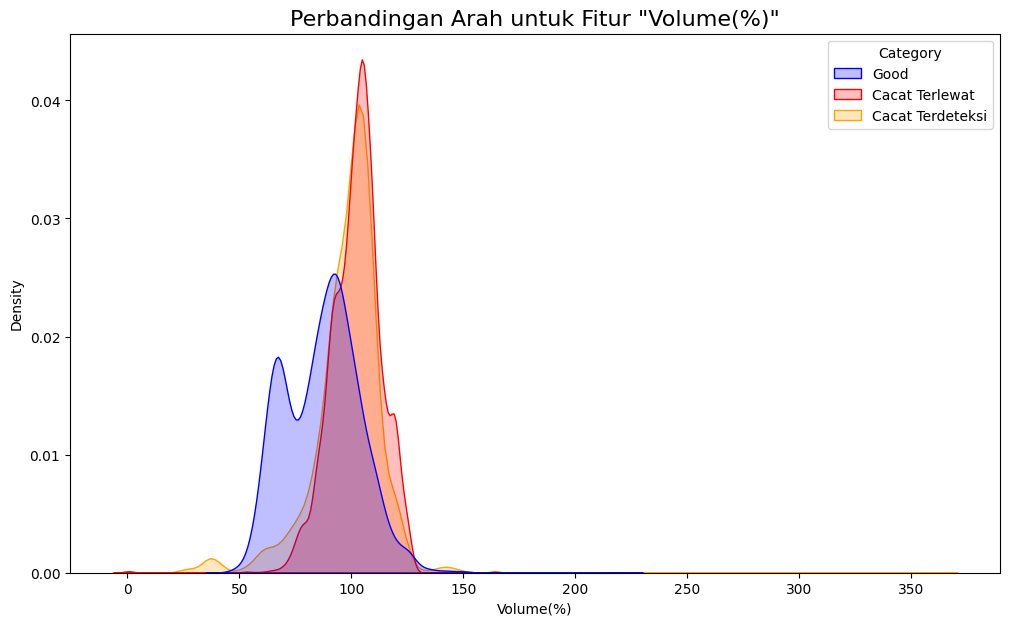

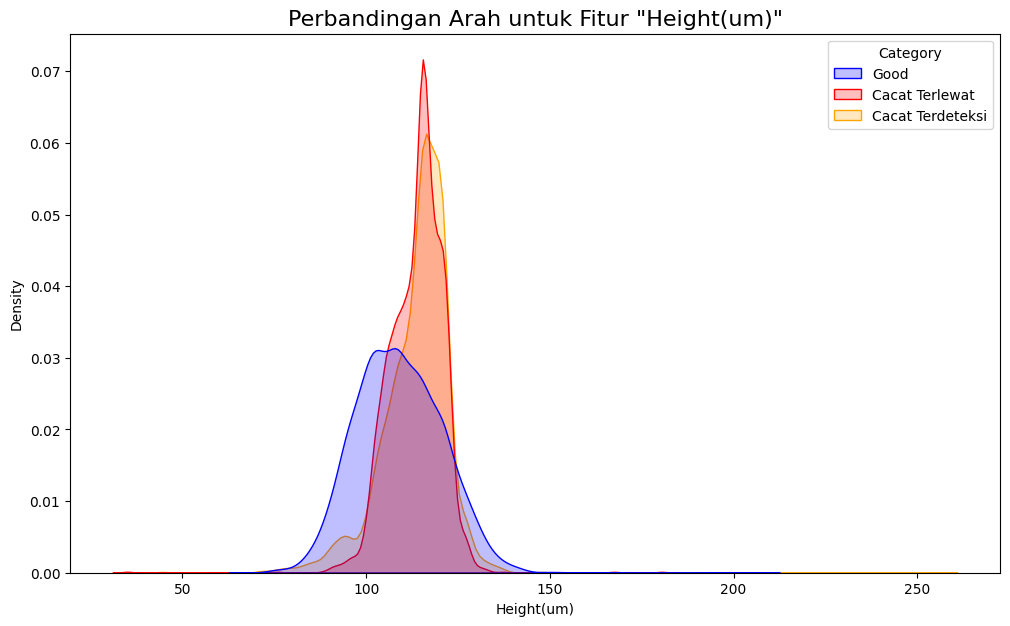

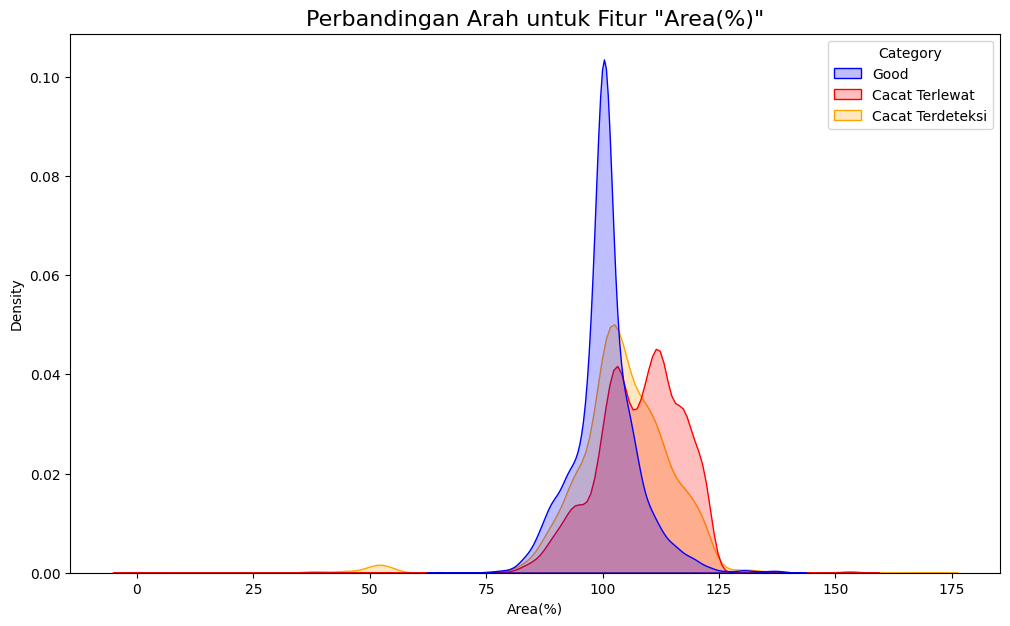

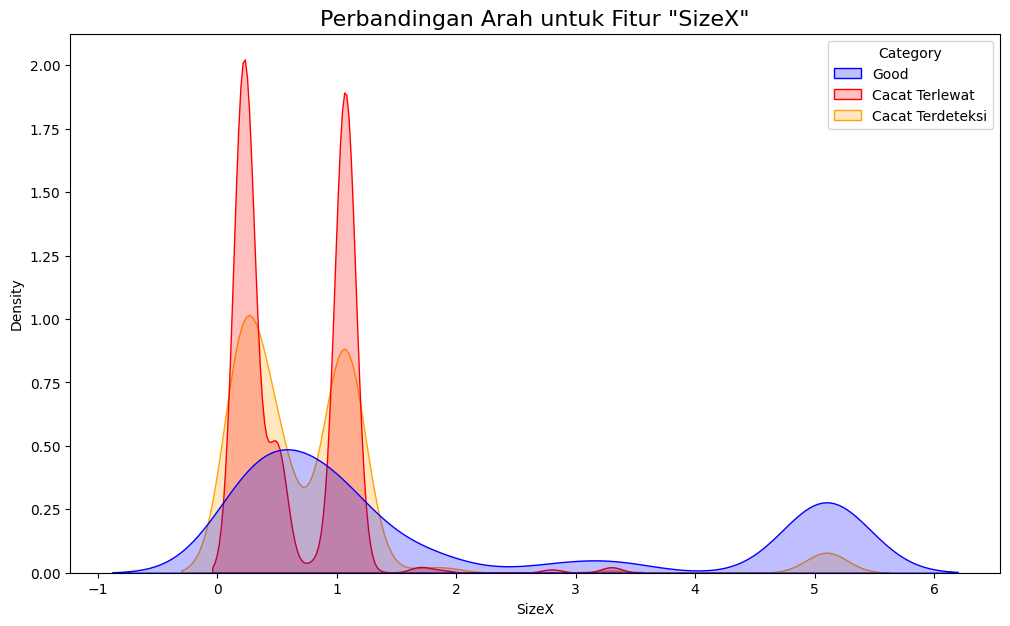

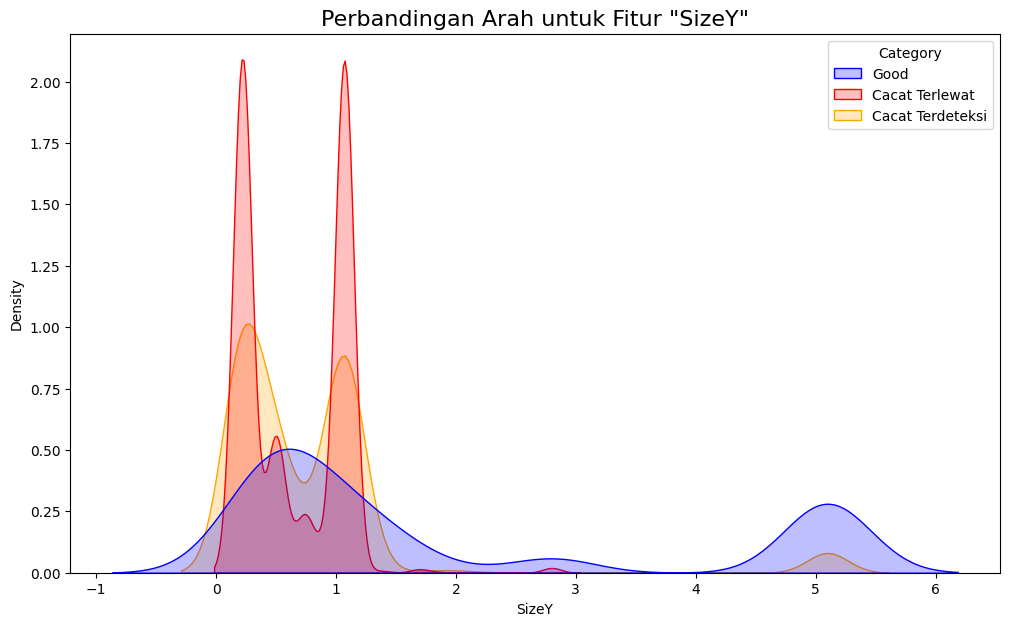

In [ ]:
merge_keys = ["PanelID", "FigureID", "ComponentID"]
good_spi = pd.merge(good_products_aoi, merged_spi, on=merge_keys, how='inner', suffixes=('_aoi', '_spi'))
missed_spi = pd.merge(missed_defects_aoi, merged_spi, on=merge_keys, how='inner', suffixes=('_aoi', '_spi'))
detected_spi = pd.merge(detected_defects_aoi, merged_spi, on=merge_keys, how='inner', suffixes=('_aoi', '_spi'))

sample_size = len(missed_spi)
good_sample = good_spi.sample(n=sample_size, random_state=42)
detected_sample = detected_spi.sample(n=sample_size, random_state=42)

good_sample['Category'] = 'Good'
missed_spi['Category'] = 'Cacat Terlewat'
detected_sample['Category'] = 'Cacat Terdeteksi'
comparison_df = pd.concat([good_sample, missed_spi, detected_sample]).reset_index(drop=True)
features_to_analyze = ['Volume(%)', 'Height(um)', 'Area(%)', 'SizeX', 'SizeY']
palettes = {'Good': 'blue', 'Cacat Terlewat': 'red', 'Cacat Terdeteksi': 'orange'}

for col in features_to_analyze:
    plt.figure(figsize=(12, 7))
    sns.kdeplot(data=comparison_df, x=col, hue='Category', fill=True,
                common_norm=False, palette=palettes)
    plt.title(f'Perbandingan Arah untuk Fitur "{col}"', fontsize=16)
    plt.show()


Melalui visualisasi tersebut, dapat ditemukan informasi penting:
- Untuk metrik-metrik utama seperti Volume, Tinggi, dan Area solder, distribusi cacat yang terlewat memiliki kemiripan yang kuat dengan kategori 'Good' dan 'Cacat Terdeteksi'. Namun, pada metrik dimensional seperti SizeX dan SizeY, profil 'Cacat Terlewat' memiliki kemiripan bentuk dengan 'Cacat Terdeteksi'. Hal tersebut menandakan adanya masalah geometris.

Mesin efektif mendeteksi anomali kasar pada kuantitas solder, tetapi gagal menangkap cacat yang lebih kompleks di mana jumlah soldernya terlihat benar namun terdapat masalah lain

/tmp/ipython-input-47-45376225.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=component_counts.values, y=component_counts.index, palette='rocket')


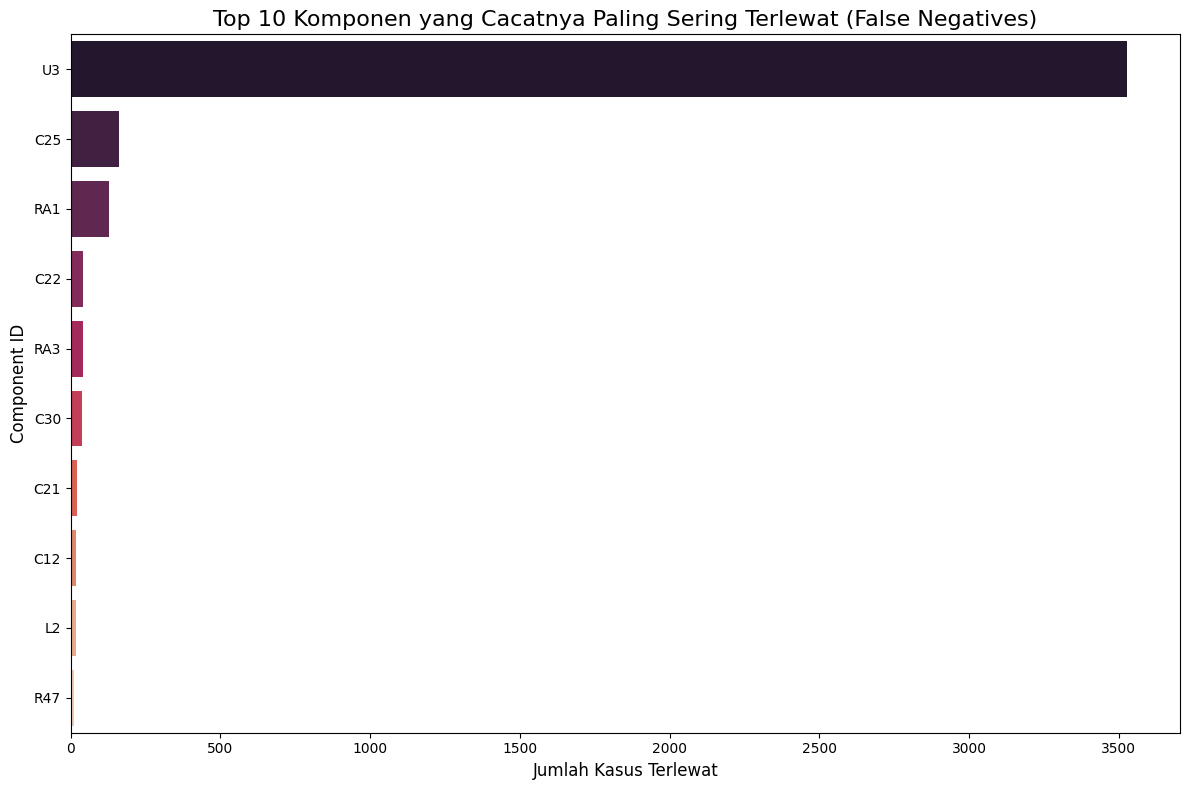

In [ ]:

if not missed_spi.empty:
    plt.figure(figsize=(12, 8))

    component_counts = missed_spi['ComponentID'].value_counts().nlargest(10)
    sns.barplot(x=component_counts.values, y=component_counts.index, palette='rocket')

    plt.title('Top 10 Komponen yang Cacatnya Paling Sering Terlewat (False Negatives)', fontsize=16)
    plt.xlabel('Jumlah Kasus Terlewat', fontsize=12)
    plt.ylabel('Component ID', fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("Tidak ada data 'Cacat Terlewat' untuk dianalisis.")

## **Investigasi Penyebab Jenis Cacat Translated**

Total kasus cacat 'Translated' yang terkonfirmasi: 5169 baris


/tmp/ipython-input-48-2034992900.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=translated_spi, y='MachineID', ax=axes[0], palette='YlGnBu_r')
/tmp/ipython-input-48-2034992900.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=translated_spi, y='ComponentID', order=top_components_translated, ax=axes[1], palette='summer')


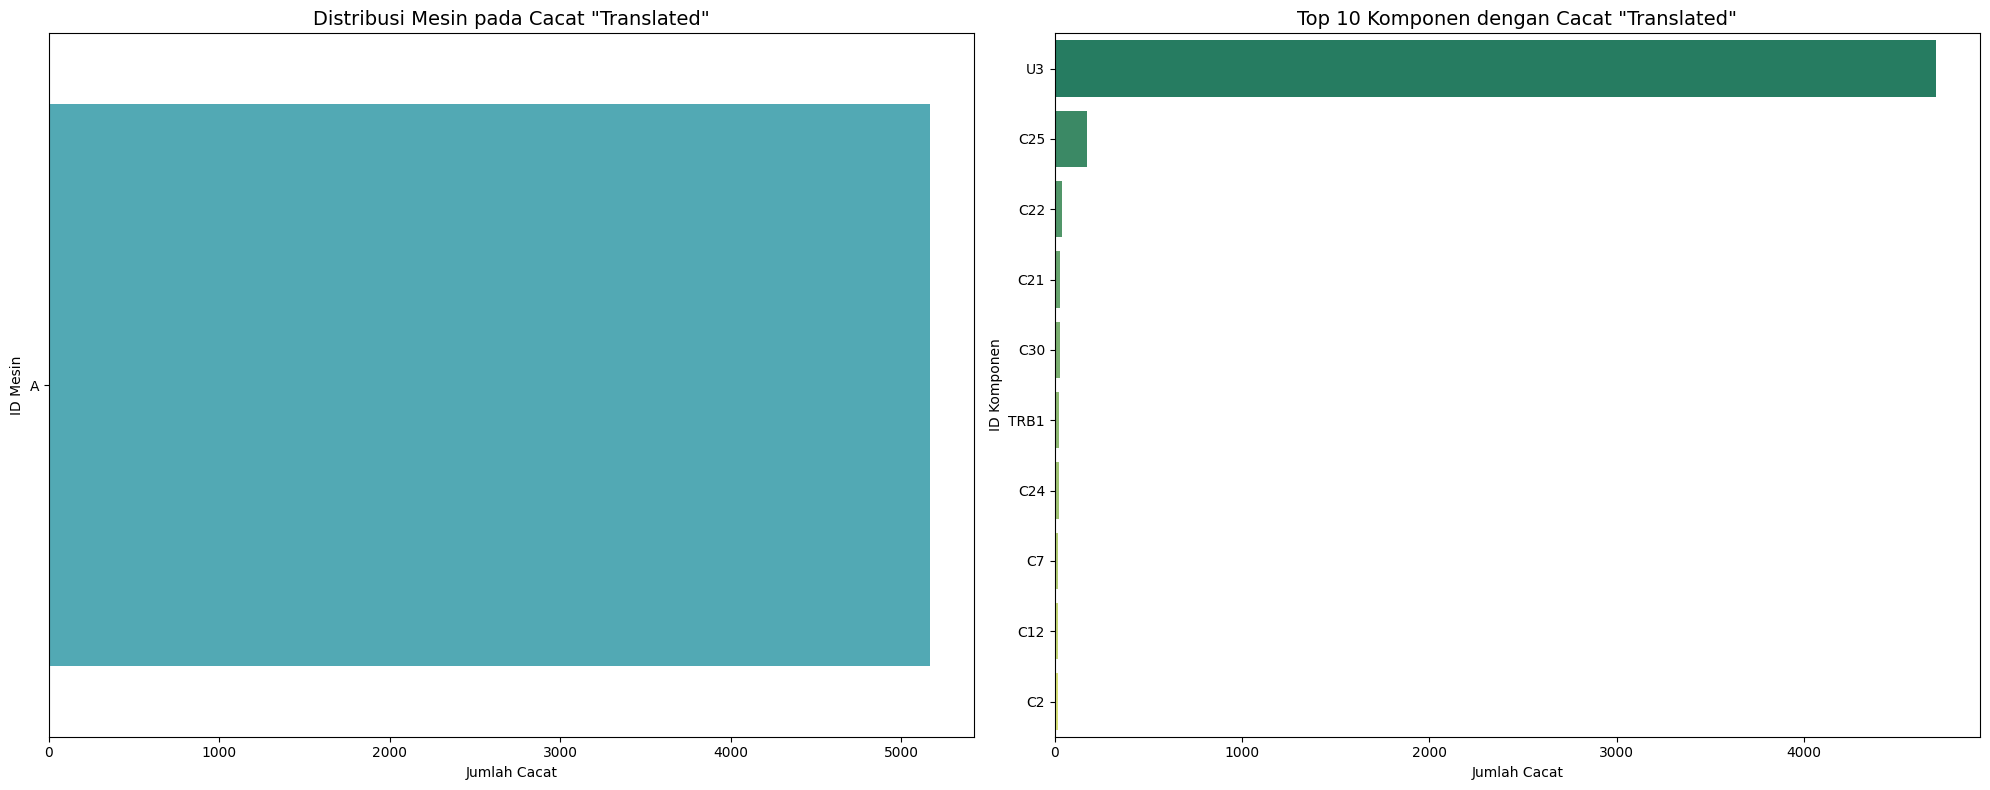

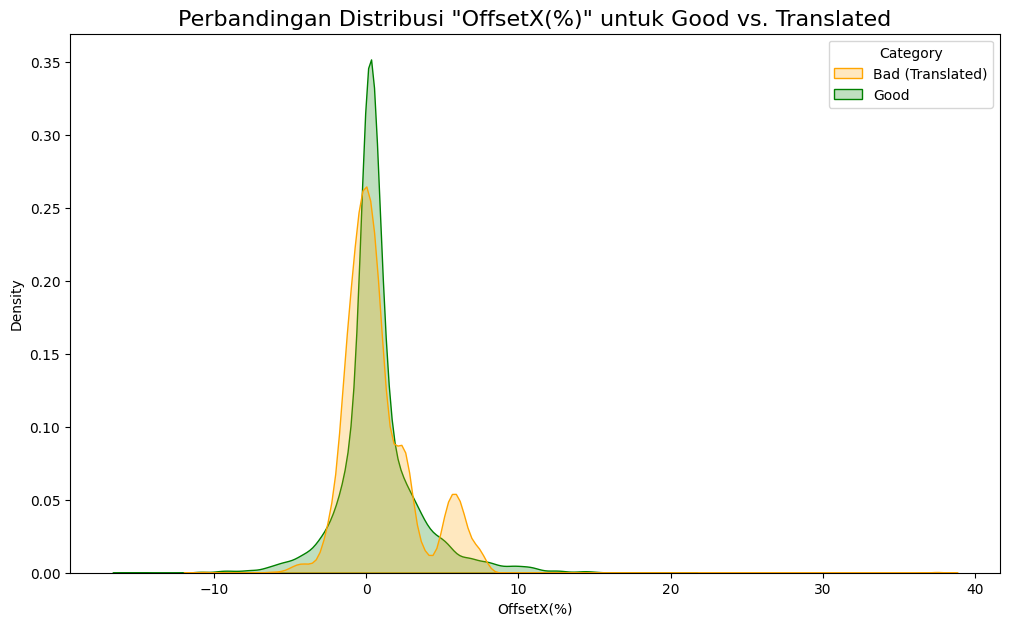

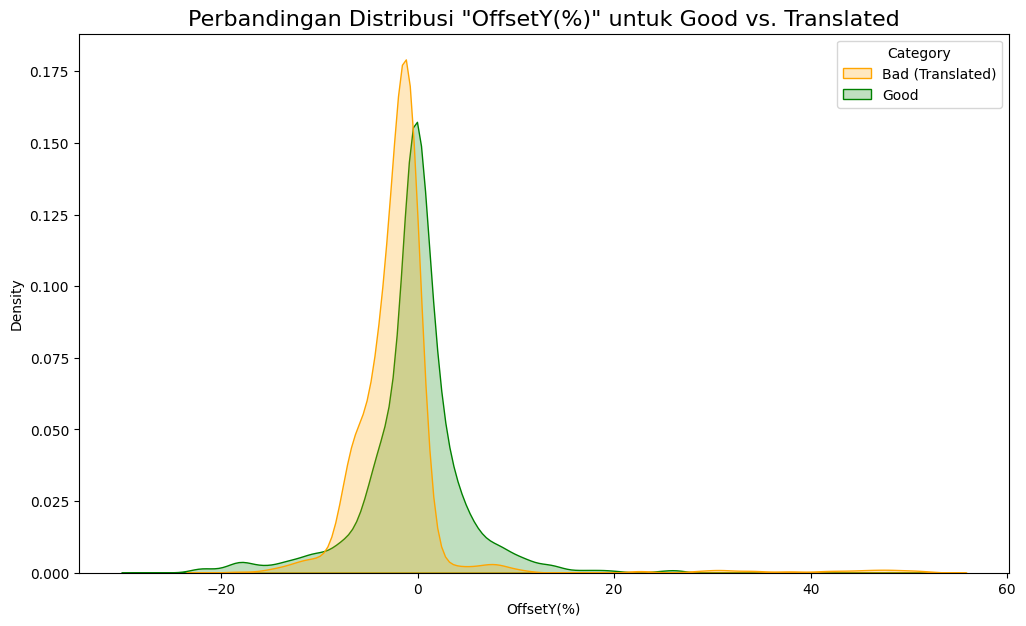

In [ ]:
translated_defects_aoi = aoi_train[(aoi_train['OperatorLabel'] == 'Bad') & (aoi_train['AOILabel'] == 'Translated')]

merge_keys = ["PanelID", "FigureID", "ComponentID"]
translated_spi = pd.merge(translated_defects_aoi, merged_spi, on=merge_keys, how='inner', suffixes=('_aoi', '_spi'))
print(f"Total kasus cacat 'Translated' yang terkonfirmasi: {len(translated_spi)} baris")

if not translated_spi.empty:
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    sns.countplot(data=translated_spi, y='MachineID', ax=axes[0], palette='YlGnBu_r')
    axes[0].set_title('Distribusi Mesin pada Cacat "Translated"', fontsize=14)
    axes[0].set_xlabel("Jumlah Cacat")
    axes[0].set_ylabel("ID Mesin")

    top_components_translated = translated_spi['ComponentID'].value_counts().nlargest(10).index
    sns.countplot(data=translated_spi, y='ComponentID', order=top_components_translated, ax=axes[1], palette='summer')
    axes[1].set_title('Top 10 Komponen dengan Cacat "Translated"', fontsize=14)
    axes[1].set_xlabel("Jumlah Cacat")
    axes[1].set_ylabel("ID Komponen")

    plt.tight_layout()
    plt.show()
else:
    print("Tidak ada data 'Translated' yang valid untuk dianalisis.")

# Perbandingan Fitur Posisi vs. Produk 'Good'
if not translated_spi.empty:
    good_products_aoi = aoi_train[aoi_train['OperatorLabel'] == 'Good']
    good_spi_for_comp = pd.merge(good_products_aoi, merged_spi, on=merge_keys, how='inner')
    good_sample_comp = good_spi_for_comp.sample(n=len(translated_spi), random_state=42)

    translated_spi['Category'] = 'Bad (Translated)'
    good_sample_comp['Category'] = 'Good'
    comparison_translated_df = pd.concat([translated_spi, good_sample_comp]).reset_index(drop=True)

    positional_features = ['OffsetX(%)', 'OffsetY(%)']
    palette_2way = {'Good': 'green', 'Bad (Translated)': 'orange'}

    for col in positional_features:
        plt.figure(figsize=(12, 7))
        sns.kdeplot(data=comparison_translated_df, x=col, hue='Category', fill=True,
                    common_norm=False, palette=palette_2way)
        plt.title(f'Perbandingan Distribusi "{col}" untuk Good vs. Translated', fontsize=16)
        plt.show()

Cacat pergeseran (Translated) terisolasi pada satu mesin dan dominan pada satu komponen tunggal.

Ketiga Grafik terkait Offset menunjukkan distribusi produk 'Good' sangat terpusat di titik nol, menunjukkan tidak ada pergeseran sama sekali. Sebaliknya, distribusi produk 'Bad' (Translated)  menyebar luas, menunjukkan adanya nilai pergeseran yang signifikan dan nyata.

## ***Key Takeaways* dari ketiga investigasi**

---



Analisis ini membongkar akar masalah kualitas pada lini produksi, membuktikan bahwa kegagalan yang terjadi bukanlah acak, melainkan serangkaian isu sistematis yang dapat didiagnosis dengan presisi. Kami menemukan bahwa cacat utama seperti **Coplanarity** disebabkan oleh profil pasta solder yang secara fisik terlalu tinggi menyerupai "kubah", di mana masalah ini menjadi kritis akibat kombinasi masalah mekanis di lokasi hotspot tertentu dan gaya puntir saat penempatan komponen. Berbeda dari itu, cacat pergeseran **(Translated)** terungkap sebagai sebuah kegagalan titik tunggal yang katastropis, karena 100% masalahnya terisolasi pada satu mesin spesifik yang menangani satu komponen spesifik. Lebih jauh lagi, investigasi ini juga mengungkap adanya anomali pada logika mesin AOI, yang secara konsisten melewatkan cacat nyata karena algoritmanya tertipu oleh parameter primer yang terlihat normal dan gagal mengenali anomali geometris yang lebih halus.

## **Menganalisa Hasil Penggabungan File AOI and Merged SPI**

---



In [ ]:
for df in [aoi_train, merged_spi]:
    for col in ['FigureID', 'PinNumber']:
        df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')

merged_cols = ["PanelID", "FigureID", "ComponentID", "PinNumber"]
final_df = pd.merge(aoi_train, merged_spi, on=merged_cols, how='left')

final_df['Has_SPI_Data'] = np.where(final_df['Datetime'].notna(), True, False)

print(f"\nUkuran DataFrame setelah digabungkan: {final_df.shape}")
print("\nJumlah nilai yang hilang setelah penggabungan:")
display(final_df.isna().sum())


Ukuran DataFrame setelah digabungkan: (31617, 30)

Jumlah nilai yang hilang setelah penggabungan:


PanelID                  0
FigureID                 0
MachineID                0
ComponentID              0
PinNumber             9124
AOILabel                 0
OperatorLabel            0
RepairLabel          30261
MachinePrediction        0
PadID                 9082
PadType               9082
Volume(%)             9082
Height(um)            9082
Area(%)               9082
OffsetX(%)            9082
OffsetY(%)            9082
SizeX                 9082
SizeY                 9082
Volume(um3)           9082
Area(um2)             9082
Shape(um)             9082
PosX(mm)              9082
PosY(mm)              9082
Result                9082
Datetime              9082
Hour                  9082
DayOfWeek             9082
Is_Defect             9082
Is_Defect_Label       9082
Has_SPI_Data             0
dtype: int64

Untuk semua kolom dari 'merged_spi' terdapat 9.082 data yang NaN.
Dari 31,617 temuan cacat di AOI, sebanyak 9,082 kasus (atau sekitar 28.7%) tidak memiliki catatan inspeksi yang sesuai di data SPI.

Hal ini berarti hampir sepertiga dari cacat yang terdeteksi di tahap akhir terjadi pada proses setelah aplikasi pasta solder.

Untuk membedah 9,082 kasus ini lebih dalam. Kita akan menelusuri jenis cacat AOI mana yang paling sering tidak memiliki riwayat SPI.

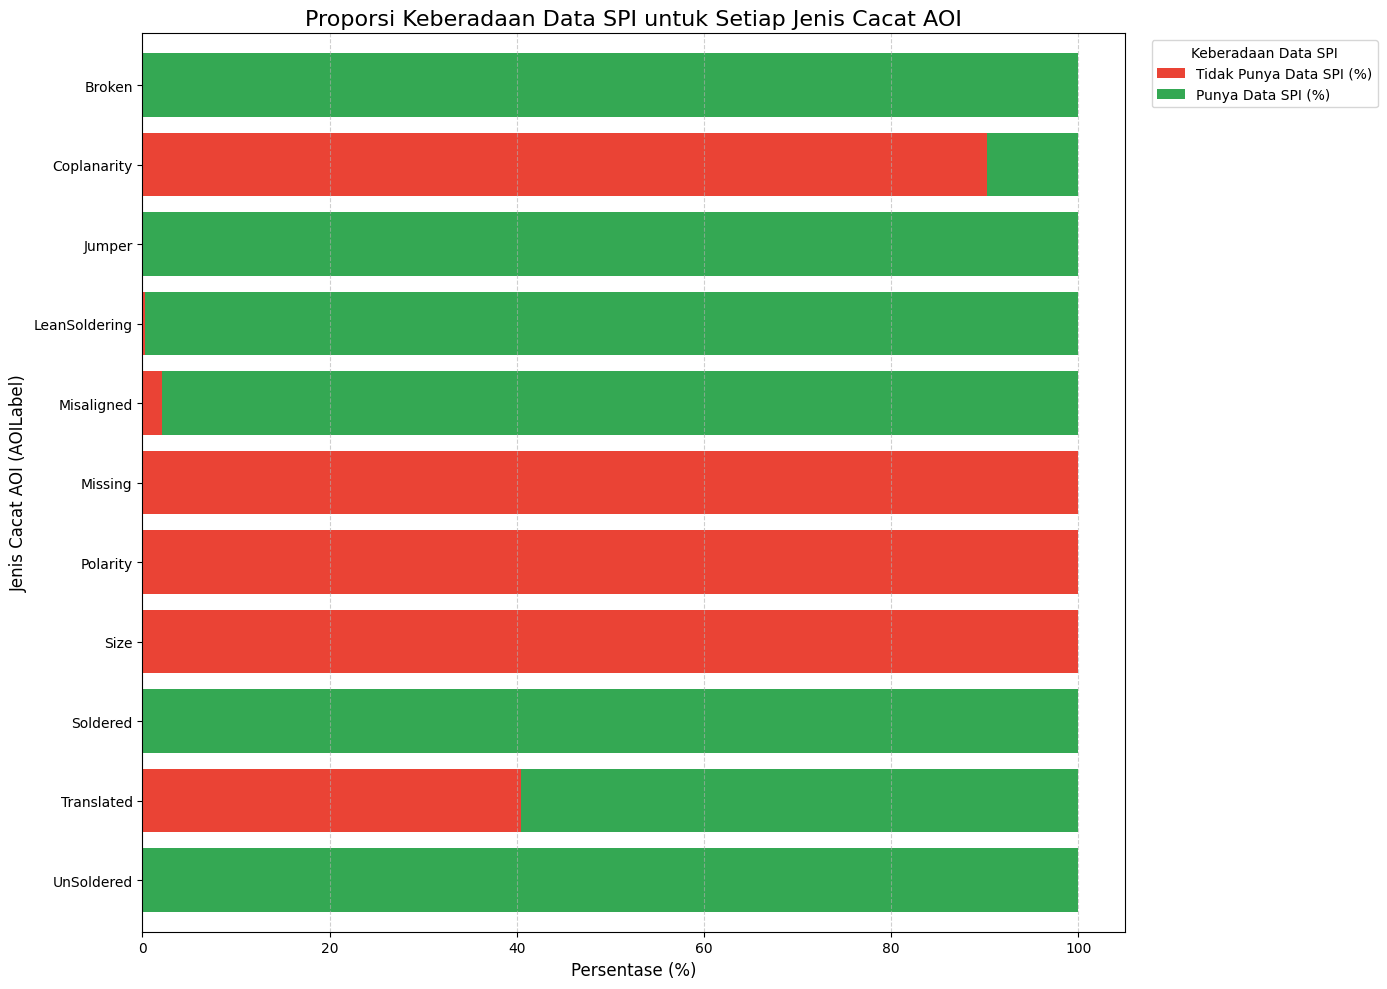

Tabel Proporsi Keberadaan Data SPI (%):


Tidak Punya Data SPI (%)  Punya Data SPI (%)
AOILabel                                                   
Polarity                     100.000000            0.000000
Missing                      100.000000            0.000000
Size                          99.948770            0.051230
Coplanarity                   90.254873            9.745127
Translated                    40.421456           59.578544
Misaligned                     2.074436           97.925564
LeanSoldering                  0.288600           99.711400
UnSoldered                     0.064329           99.935671
Soldered                       0.021249           99.978751
Jumper                         0.000000          100.000000
Broken                         0.000000          100.000000

In [ ]:

spi_data_summary = pd.crosstab(final_df['AOILabel'], final_df['Has_SPI_Data'], normalize='index') * 100
spi_data_summary.columns = ['Tidak Punya Data SPI (%)', 'Punya Data SPI (%)']


spi_data_summary.plot.barh(
    stacked=True,
    figsize=(14, 10),
    color=['#EA4335', '#34A853'],
    width=0.8
)

plt.title('Proporsi Keberadaan Data SPI untuk Setiap Jenis Cacat AOI', fontsize=16)
plt.xlabel('Persentase (%)', fontsize=12)
plt.ylabel('Jenis Cacat AOI (AOILabel)', fontsize=12)
plt.legend(title='Keberadaan Data SPI', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Tabel Proporsi Keberadaan Data SPI (%):")
display(spi_data_summary.sort_values(by='Tidak Punya Data SPI (%)', ascending=False))

Melalui visualisasi tersebut, kita dapat mengelompokkan cacat yang terjadi sebelum/saat aplikasi pasta solder dan cacat yang terjadi setelahnya.

* Jenis cacat seperti Polarity, Missing, Jumper, dan Broken secara konsisten 100% tidak memiliki riwayat data SPI. Ini adalah bukti kuat bahwa cacat-cacat ini disebabkan oleh masalah pada tahap penempatan komponen (pick-and-place) atau proses pemanasan di oven reflow

* Sebaliknya, cacat seperti LeanSoldering, UnSoldered, dan Soldered hampir selalu memiliki riwayat data SPI. Ini mengonfirmasi bahwa masalah-masalah penyolderan ini sangat erat kaitannya dengan kondisi awal pasta solder (volume, tinggi, posisi) yang diukur oleh SPI.

* Cacat Translated (Pergeseran) menunjukkan perilaku hibrida yang menarik. Sekitar 40% kasus tidak memiliki data SPI, sementara 60% memilikinya. Ini bisa mengindikasikan dua skenario pergeseran, yaitu pergeseran besar karena kesalahan mesin penempatan, atau pergeseran minor di mana komponen sedikit tergeser di atas pasta solder yang sudah ada.

Dengan demikian, penggunaan data SPI untuk memprediksi cacat seperti Missing, Polarity, Jumper, akan sia-sia, tetapi akan sangat relevan untuk Unsoldered, LeanSoldering, Soldered.



Setelah berhasil memetakan cacat mana saja yang memiliki riwayat SPI, langkah terakhir dari eksplorasi data ini adalah mencari hubungan sebab-akibat antara pengukuran di tahap awal (SPI) dengan hasil cacat di tahap akhir (AOI). Analisis ini bertujuan untuk membuktikan secara kuantitatif apakah kondisi pasta solder dapat menjadi prediktor untuk jenis kegagalan akhir.



/tmp/ipython-input-51-4089866941.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_connected[df_connected['AOILabel'].isin(aoi_outcomes)], x='AOILabel', y=feature, palette='viridis')


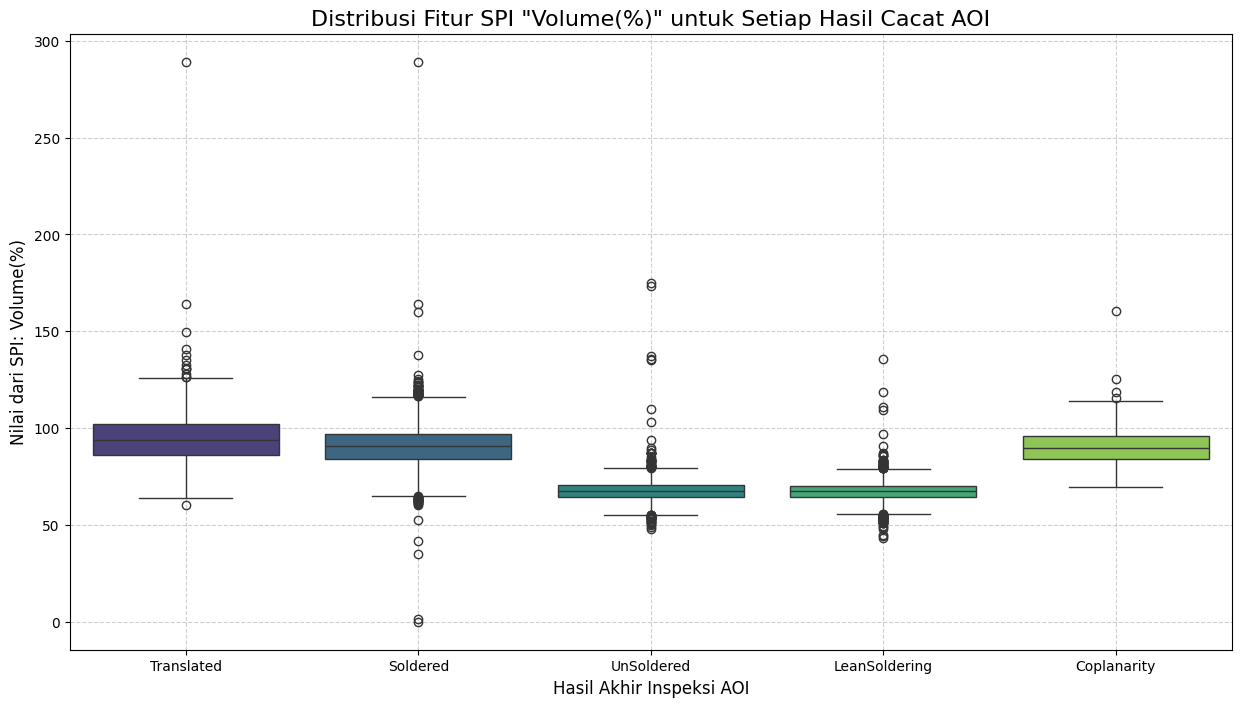

/tmp/ipython-input-51-4089866941.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_connected[df_connected['AOILabel'].isin(aoi_outcomes)], x='AOILabel', y=feature, palette='viridis')


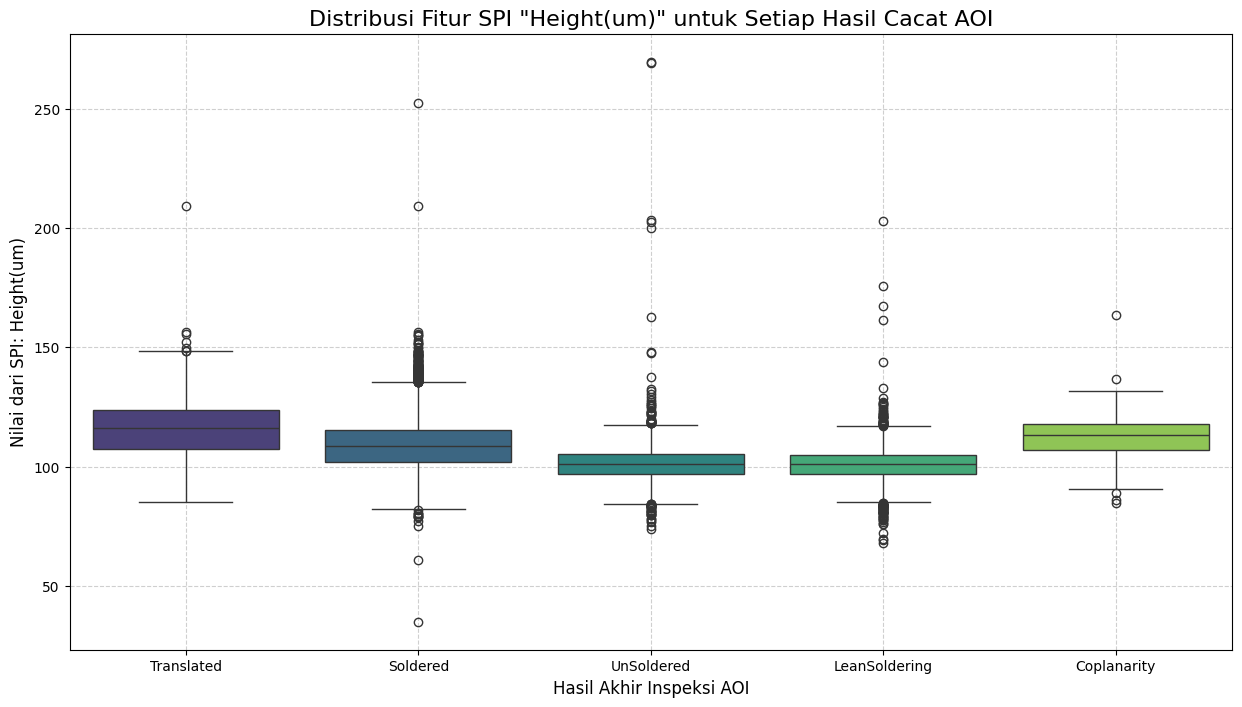

/tmp/ipython-input-51-4089866941.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_connected[df_connected['AOILabel'].isin(aoi_outcomes)], x='AOILabel', y=feature, palette='viridis')


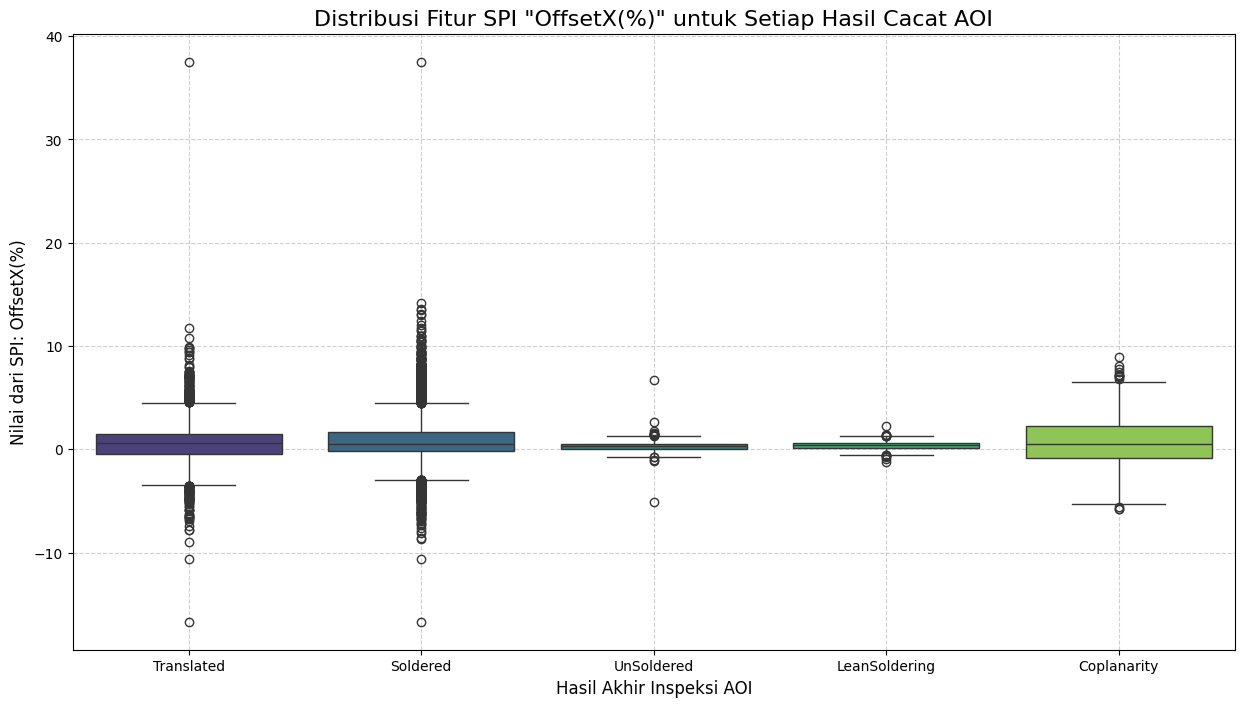

/tmp/ipython-input-51-4089866941.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_connected[df_connected['AOILabel'].isin(aoi_outcomes)], x='AOILabel', y=feature, palette='viridis')


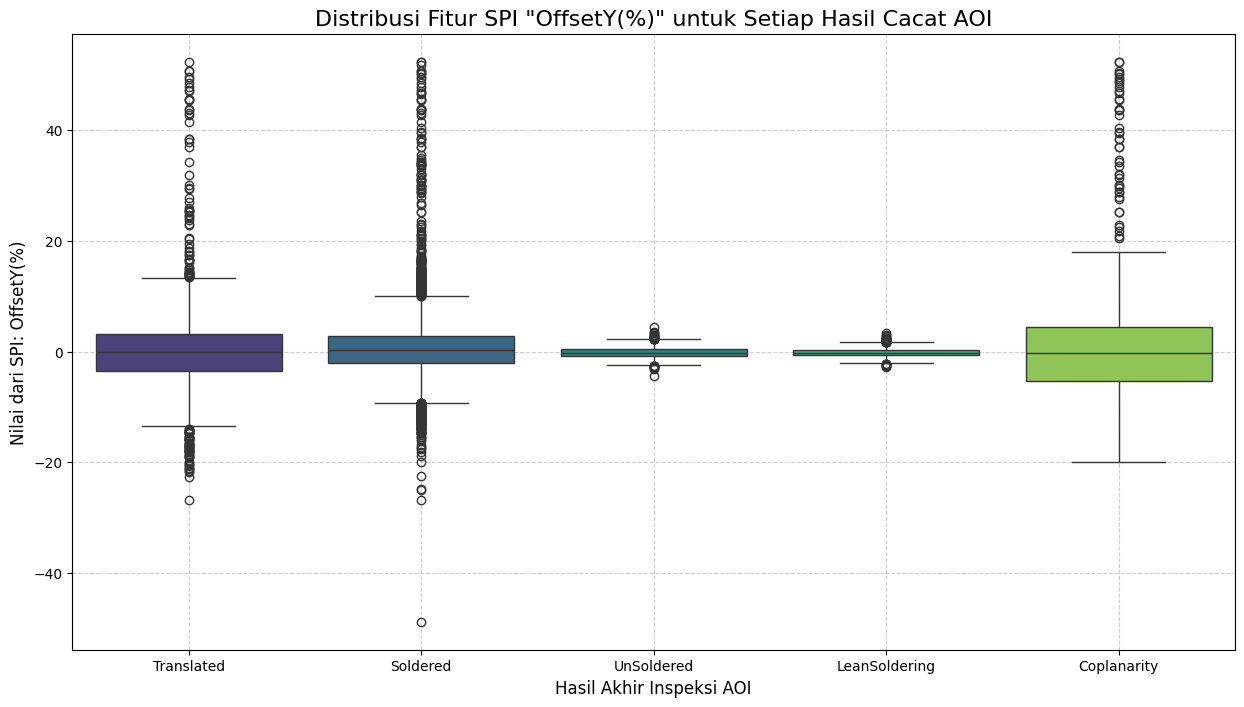

In [ ]:

df_connected = final_df[final_df['Has_SPI_Data'] == True].copy()

spi_features = ['Volume(%)', 'Height(um)', 'OffsetX(%)', 'OffsetY(%)']
aoi_outcomes = ['Soldered', 'UnSoldered', 'Translated', 'Coplanarity', 'LeanSoldering']

for feature in spi_features:
    plt.figure(figsize=(15, 8))
    sns.boxplot(data=df_connected[df_connected['AOILabel'].isin(aoi_outcomes)], x='AOILabel', y=feature, palette='viridis')
    plt.title(f'Distribusi Fitur SPI "{feature}" untuk Setiap Hasil Cacat AOI', fontsize=16)
    plt.xlabel('Hasil Akhir Inspeksi AOI', fontsize=12)
    plt.ylabel(f'Nilai dari SPI: {feature}', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

* Terbukti secara definitif bahwa cacat UnSoldered di AOI berkorelasi kuat dengan nilai Volume(%) dan Height(um) yang rendah pada saat inspeksi SPI.

* Sebaliknya, cacat Soldered di AOI menunjukkan variabilitas yang sangat tinggi pada Volume(%) dan Height(um) di SPI, dengan banyak kasus memiliki nilai yang jauh di atas normal, yang berpotensi menyebabkan solder bridge.

* Cacat Translated di AOI dengan jelas menunjukkan variansi yang jauh lebih besar pada OffsetX(%) dan OffsetY(%) di SPI. Ini membuktikan bahwa pergeseran posisi yang terdeteksi pada tahap awal merupakan indikator risiko yang kuat untuk cacat pergeseran di tahap akhir.

## **Kesimpulan Akhir dari Tahap Exploratory Data Analysis (EDA)**

---



## **Berdasarkan data SPI**

---


*  Ditemukan adanya ketidakseimbangan kelas yang ekstrem, di mana lebih dari 98% hasil inspeksi SPI adalah 'GOOD'. Ini berarti masalah utamanya bukan pada banyaknya cacat, tetapi pada bagaimana cara mendeteksi cacat yang langka tersebut secara akurat.

* Setiap jenis cacat (seperti Insufficient, Excessive, Shift) memiliki karakteristik numerik (Volume, Height, Offset) yang unik dan dapat dibedakan

* Tingkat cacat cenderung meningkat signifikan pada shift malam dan mencapai puncaknya pada hari Jumat. Ini mengindikasikan adanya faktor kelelahan operator atau penurunan performa mesin yang perlu perhatian khusus.

* Ditemukan adanya sejumlah kecil panel anomali dengan jumlah titik inspeksi yang tidak konsisten. Ini bukan "data rusak", melainkan bukti adanya variasi proses nyata di lantai produksi yang perlu dicatat.

## **Berdasarkan data AOI**

---


* Mayoritas cacat yang terdeteksi di tahap AOI diberi label NotPossibleToRepair. Ini berarti upaya perbaikan harus difokuskan pada pencegahan di tahap awal (SPI), karena sekali cacat lolos ke tahap AOI, potensi kerugiannya sangat tinggi.

* Mesin AOI dikalibrasi untuk memiliki recall yang tinggi namun presisi yang sangat rendah. Ia sangat baik dalam menemukan potensi cacat, tetapi menghasilkan banyak false positive yang perlu diverifikasi oleh operator. Sumber false positive terbesar adalah deteksi UnSoldered dan Coplanarity.

* Cacat pergeseran posisi (Translated) terbukti menjadi akar masalah yang seringkali menyebabkan cacat lain seperti Coplanarity dan masalah Soldered. Mengatasi masalah pergeseran akan memberikan dampak perbaikan yang luas.

## **Berdasarkan data gabungan (AOI & SPI)**

---


* Cacat dapat dibagi menjadi dua kelompok waktu:
  - Cacat Terkait SPI
    Masalah penyolderan seperti UnSoldered dan Soldered hampir selalu memiliki riwayat data SPI, membuktikan akarnya ada di proses aplikasi pasta solder.
  - Cacat Pasca-SPI
    Cacat seperti Missing (komponen hilang) dan Broken (komponen rusak) hampir tidak pernah memiliki riwayat data SPI, membuktikan masalahnya terjadi pada tahap penempatan komponen
* Terbukti bahwa parameter di SPI memiliki korelasi yang kuat dan logis dengan hasil akhir di AOI. Volume(%) yang rendah di SPI memprediksi cacat UnSoldered di AOI, dan OffsetX(%) yang bervariasi di SPI memprediksi cacat Translated di AOI.

